In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import Image, display

In [3]:
import arviz as az

In [4]:
from atlassampler import HMC
from atlassampler.util import PrintException

In [5]:
import sys
sys.path.append('../experiments/')
import diagnostics_jax as dg

In [6]:
reference_samples = {}
log_scale = np.random.normal(0, 3, 100000)
latents = np.array([np.random.normal(0, np.exp(log_scale/2)) for _ in range(10)]).T
log_scale = log_scale.reshape(-1, 1)
ref_samples_funnel = np.concatenate([log_scale, latents], axis=1)
reference_samples['funnel-11'] = ref_samples_funnel
# ref_samples_funnel = np.concatenate([ref_samples_funnel[:, 0:1], np.repeat(ref_samples_funnel[:, 1:2], 50, axis=1)], axis=1)
# reference_samples['funnel-51'] = ref_samples_funnel

x = np.random.normal(1, 1, 100000)
y = np.array([np.random.normal(x**2, 0.1) for _ in range(2-1)]).T
x = np.expand_dims(x, axis=1)
ref_samples_rosenbrock = np.concatenate([x, y], axis=1)
reference_samples['rosenbrock-2'] = ref_samples_rosenbrock


for exp in [ "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility", "corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
    try: reference_samples[exp] = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc/{exp}/samples.npy')
    except:  reference_samples[exp] = np.load(f'/mnt/ceph/users/cmodi/PosteriorDB//{exp}/samples.npy')

# Functions to use

In [7]:
relative1 = 'scatter'
relative2 = 'scatter'
nevals = None
nchains = 32

def load_rmse(path, samples, grads, ref, nsamples, relative1='scatter', relative2='scatter', nevals=None):
    if 'lotka' in path: 
        samples = samples[:30]
        grads = grads[:30]
    try:
        count, err1, err2 = np.load(f'{path}/rmse.npy')[..., :nsamples]
        assert count.shape[0] == samples.shape[0]
        assert count.shape[1] == samples.shape[1]
    except Exception as e:
        PrintException()
        count, err1 = dg.cumulative_rmse_per_chain(samples, counts=grads, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
        count, err2 = dg.cumulative_rmse_per_chain(samples, counts=grads, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
        np.save(f'{path}/rmse.npy', np.array([count, err1, err2]))
    return count, err1, err2

def get_data(path, key, data, nsamples):   
    ref = data['ref']
    try:
        suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])
        guturn = np.stack([np.load(f'{path}/gradcounts-{i}.npy')[:nsamples] for i in range(nchains)])
        assert suturn.shape[0] == data['nuts'][-1].shape[0]
        assert suturn.shape[1] == data['nuts'][-1].shape[1]
        count, err1, err2 = load_rmse(path, suturn, guturn, ref, nsamples, relative1, relative2, nevals)
        data[key] =  count, err1, err2, suturn
    except Exception as e:
        PrintException()
        count, err1, err2, suturn = np.NaN, np.NaN, np.NaN, None        
    return data


def get_boxes(data):
    boxgrads, boxerror, boxerror2, lbls = [], [], [], []
    for key in data.keys():
        if key == 'ref' : continue
        nutsgrads = data['nuts'][0][:, -1].mean(axis=0)

        boxgrads.append(data[key][0][:, -1]/nutsgrads)
        boxerror.append(data[key][1][:, -1])
        boxerror2.append(data[key][2][:, -1])
        lbls.append(key)
    return boxerror, boxerror2, boxgrads, lbls

In [8]:
def boxplot_experiments(alldata, fliers=False, baselines=2, logscale=False):
    
    nexps = len(alldata.keys())
    fig, ax = plt.subplots(3, nexps, figsize=(nexps*2.5, 6), sharex='col')

    for n, exp in enumerate(alldata.keys()):

        data = alldata[exp]
        boxerror, boxerror2, boxgrads, lbls = get_boxes(data)
        ax[0, n].boxplot(boxerror, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);
        ax[1, n].boxplot(boxerror2, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);
        ax[2, n].boxplot(boxgrads, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);

        ax[0, n].set_title(exp)
    # for axis in ax[-1,:]:
        ax[2, n].set_xticks(ax[2, n].get_xticks(), ax[2, n].get_xticklabels(), rotation=60, ha='right')
        if fliers or logscale: 
            ax[0, n].set_yscale('log')
            ax[1, n].set_yscale('log')
        
    for axis in ax.flatten():
        axis.grid(which='both', lw=0.1)
        axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)
        
    ax[0, 0].set_ylabel(r'RMSE-z($\theta$)', fontsize=12)
    ax[1, 0].set_ylabel(r'RMSE-z($\theta^2$)', fontsize=12)
    ax[2, 0].set_ylabel(r'#Grad/#Grad-NUTS', fontsize=12)
    plt.tight_layout()
    return fig, ax

In [9]:
def boxplot_funnel_rosenbrock(alldata, fliers=False, baselines=1):

    if 'funnel-51' in alldata.keys(): n = 3
    else:  n = 2
    fig, ax = plt.subplots(2, 2*n, figsize=(3*2*n, 5.5), sharex=True)
    fliers=False

    for i in range(n):
        for j in range(2):
            exp = ['rosenbrock-2', 'funnel-11', 'funnel-51'][i]
            data = alldata[exp]
            refs = reference_samples[exp]

            toplot, toplot2, lbls = [], [], []
            for key in data.keys():
                if key == 'ref': continue
                if j == 0:
                    toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
                    toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
                    ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
                    ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
                    ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)

                if j == 1:
                    toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
                    toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
                    ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
                    ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
                    ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
                lbls.append(key)
                # if 'dist' not in key: ikey += 1 

            ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
            ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
                        boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);


    for axis in ax[-1]:
        axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

    ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
    ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
    for axis in ax.flatten():
        axis.grid(which='both', lw=0.1)
        axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)

    return fig, ax


In [10]:
def histogram_funnel_rosenbrock(alldata, fliers=False, baselines=2):

    nkeys = len(alldata['funnel-11'].keys())-1
    if 'funnel-51' in alldata.keys(): n = 3
    else:  n = 2

    fig, ax = plt.subplots(n, nkeys, figsize=(nkeys*2.5, 2*n), sharex=False, sharey='row')

    for i in range(n):
        
        exp = ['rosenbrock-2', 'funnel-11', 'funnel-51'][i]
        data = alldata[exp]
        refs = reference_samples[exp]
       
        for j, key in enumerate(data.keys()):
            if key == 'ref': continue
            j -= 1
            ax[i, j].hist(refs[..., 0].flatten(), histtype='step', color='k', bins='auto', density=True)
            ax[i, j].hist(data[key][-1][..., 0].flatten(), bins='auto', density=True)
            if i ==0 : ax[i, j].set_title(key)
            ax[i, 0].set_ylabel(f'{exp}')
    return fig, ax


# Fig. 1-- validate simple approach

In [11]:
nchains = 32
alldata = {}

for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
# for exp in [ "irt_2pl", "stochastic_volatility"]:
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'rosenbrock-2' or exp == 'funnel-51':
        nsamples = 1999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        

    algfolder = 'atlas-hmc' 
    ik = 0
    keys = ['beta', 'logn-2', 'logn-1.5', 'logn-1.2', 'logn-1.1']
    # for suffix in [ '', '-sinitfac2.0','-lognormal', '-sinitfac2.0-lognormal']: 
    for suffix in [ '','-lognormal', '-lognormal-stepsig1.5', '-lognormal-stepsig1.2', '-lognormal-stepsig1.1']: 
        for offset in [1.0]:
            # key = f"nodr-off{offset:0.2f}{suffix}"
            key = f"{keys[ik]}"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            # print(key, path)
            data = get_data(path, key, data, nsamples)
    alldata[exp] = data
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
jit
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
funnel-11
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
jit
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
corr_normal95-100
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
jit
EXCEPTION IN (/tmp/ipykernel_351936/3424819675.py, LINE 11 "count, err1, err2 = np.load(f'{path}/rmse.npy')[..., :nsamples]"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/corr_normal95-100/

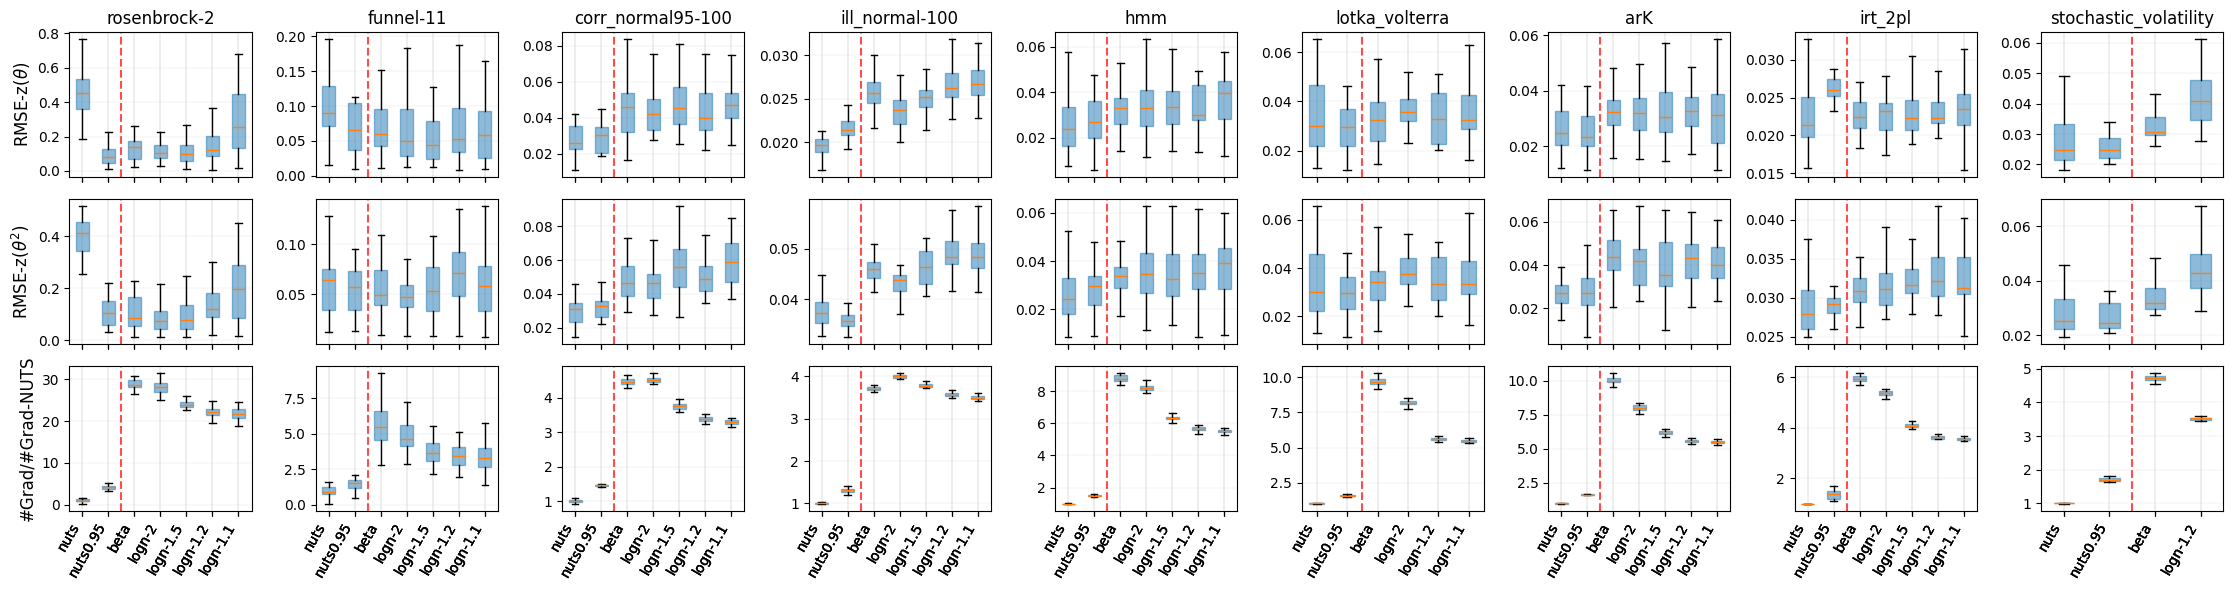

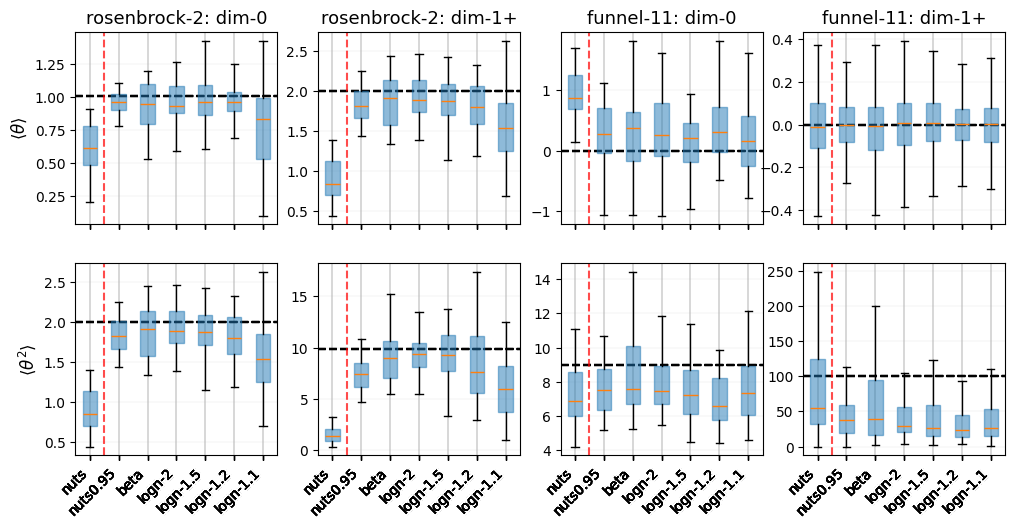

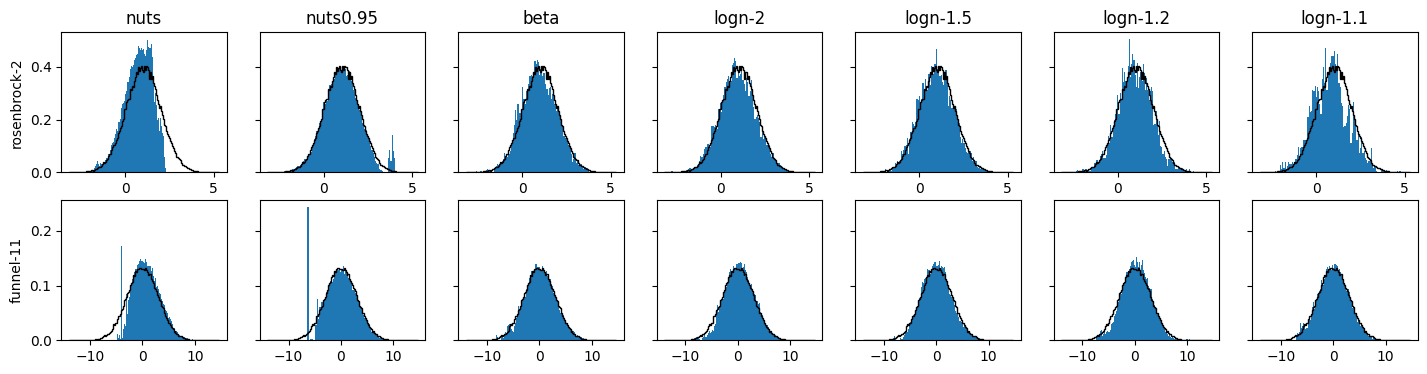

In [12]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

In [92]:
# fig, ax = plt.subplots(3, nexps, figsize=(15, 6), sharex=True)
# fliers=False

# for n, exp in enumerate(alldata.keys()):
    
#     data = alldata[exp]
#     boxerror, boxerror2, boxgrads, lbls = get_boxes(data)
#     ax[0, n].boxplot(boxerror, patch_artist=True,
#                 boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);
#     ax[1, n].boxplot(boxerror2, patch_artist=True,
#                 boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);
#     ax[2, n].boxplot(boxgrads, patch_artist=True,
#                 boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);

#     ax[0, n].set_title(exp)
# for axis in ax[-1,:]:
#     axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=60, ha='right')

# for axis in ax.flatten():
#     axis.grid(which='both', lw=0.1)
    
# # ax[0].set_ylim(0, 4)
# ax[0, 0].set_ylabel(r'RMSE-z($\theta$)', fontsize=12)
# ax[1, 0].set_ylabel(r'RMSE-z($\theta^2$)', fontsize=12)
# ax[2, 0].set_ylabel(r'#Grad/#Grad-NUTS', fontsize=12)
# plt.tight_layout()

In [12]:
# fig, ax = plt.subplots(2, 4, figsize=(13, 5), sharex=True)
# fliers=False

# for i in range(2):
#     for j in range(2):
#         exp = ['rosenbrock-2', 'funnel-11'][i]
#         data = alldata[exp]
#         refs = reference_samples[exp]

#         toplot, toplot2, lbls = [], [], []
#         for key in data.keys():
#             if key == 'ref': continue
#             if j == 0:
#                 toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
#                 toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
#                 ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
#                 ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
#                 ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)

#             if j == 1:
#                 toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
#                 toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
#                 ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
#                 ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
#                 ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
#             lbls.append(key)
#             # if 'dist' not in key: ikey += 1 

#         ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
#                     boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
#         ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
#                     boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);

    
# for axis in ax[-1]:
#     axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

# ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
# ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
# for axis in ax.flatten():
#     axis.grid(which='both', lw=0.3)


# compare stepadapt

In [767]:
nchains = 32
alldata = {}

for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:

    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'rosenbrock-2' or exp == 'funnel-51':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        


    # suffixes = [ '','-lognormal',  '-lognormal-stepsig1.2', '-uninleap','-uninleap-lognormal',  '-uninleap-lognormal-stepsig1.2']
    suffixes = [ '', '-lognormal-stepsig1.2', '-uninleap-lognormal-stepsig1.2']
    algfolder = 'compare_stepadapt' 
    ik = 0
    keys = ['beta', 'logn-2',  'logn-1.2', 'beta-uni', 'logn-2-uni',  'logn-1.2-uni']
    # for suffix in [ '', '-sinitfac2.0','-lognormal', '-sinitfac2.0-lognormal']: 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = f"nodr-off{offset:0.2f}{suffix}"
            key = f"{keys[ik]}"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target0.80{suffix}/'
            # print(key, path)
            data = get_data(path, key, data, nsamples)

    algfolder = 'compare_stepadapt-indep' 
    ik = 0
    # for suffix in [ '', '-sinitfac2.0','-lognormal', '-sinitfac2.0-lognormal']: 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = f"nodr-off{offset:0.2f}{suffix}"
            key = f"{keys[ik]}-indep"
            ik += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target0.80{suffix}/'
            # print(key, path)
            data = get_data(path, key, data, nsamples)


    suffixes = [ '-prob1-ctraj1',  '-prob1-ctraj2']#, '-prob1-ctraj1-uninleap',  '-prob1-ctraj2-uninleap']
    algfolder = 'atlasv2-nuts' 
    keys = ['all-ctraj1', 'all-ctraj2', 'all-ctraj3' ]#'all-ctraj1-unif', 'all-ctraj2-unif']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    alldata[exp] = data
    
    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
funnel-11
corr_normal95-100
EXCEPTION IN (/tmp/ipykernel_1461233/3087326118.py, LINE 24 "suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/corr_normal95-100//compare_stepadapt/target0.80-uninleap-lognormal-stepsig1.2//samples_constrained-0.npy'
ill_normal-100
hmm
lotka_volterra
arK
irt_2pl
EXCEPTION IN (/tmp/ipykernel_1461233/3087326118.py, LINE 24 "suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/irt_2pl//compare_stepadapt/target0.80-uninleap-lognormal-stepsig1.2//samples_constrained-0.npy'
stochastic_volatility
EXCEPTION IN (/tmp/ipykernel_1461233/3087326118.py, LINE 24 "suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])"): [Errno 2] No such file or directory: '/mnt

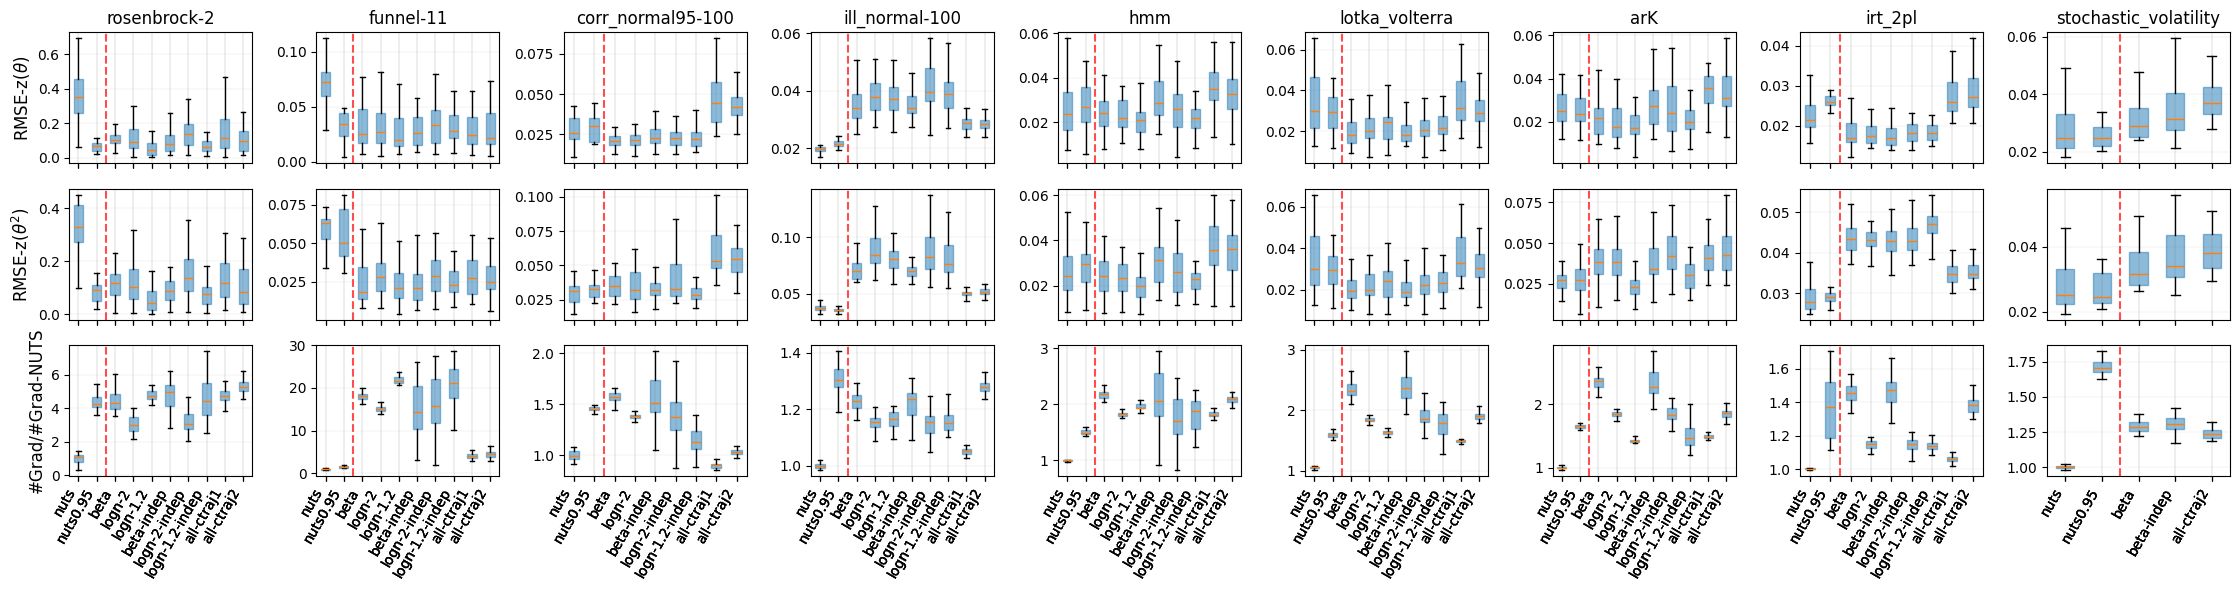

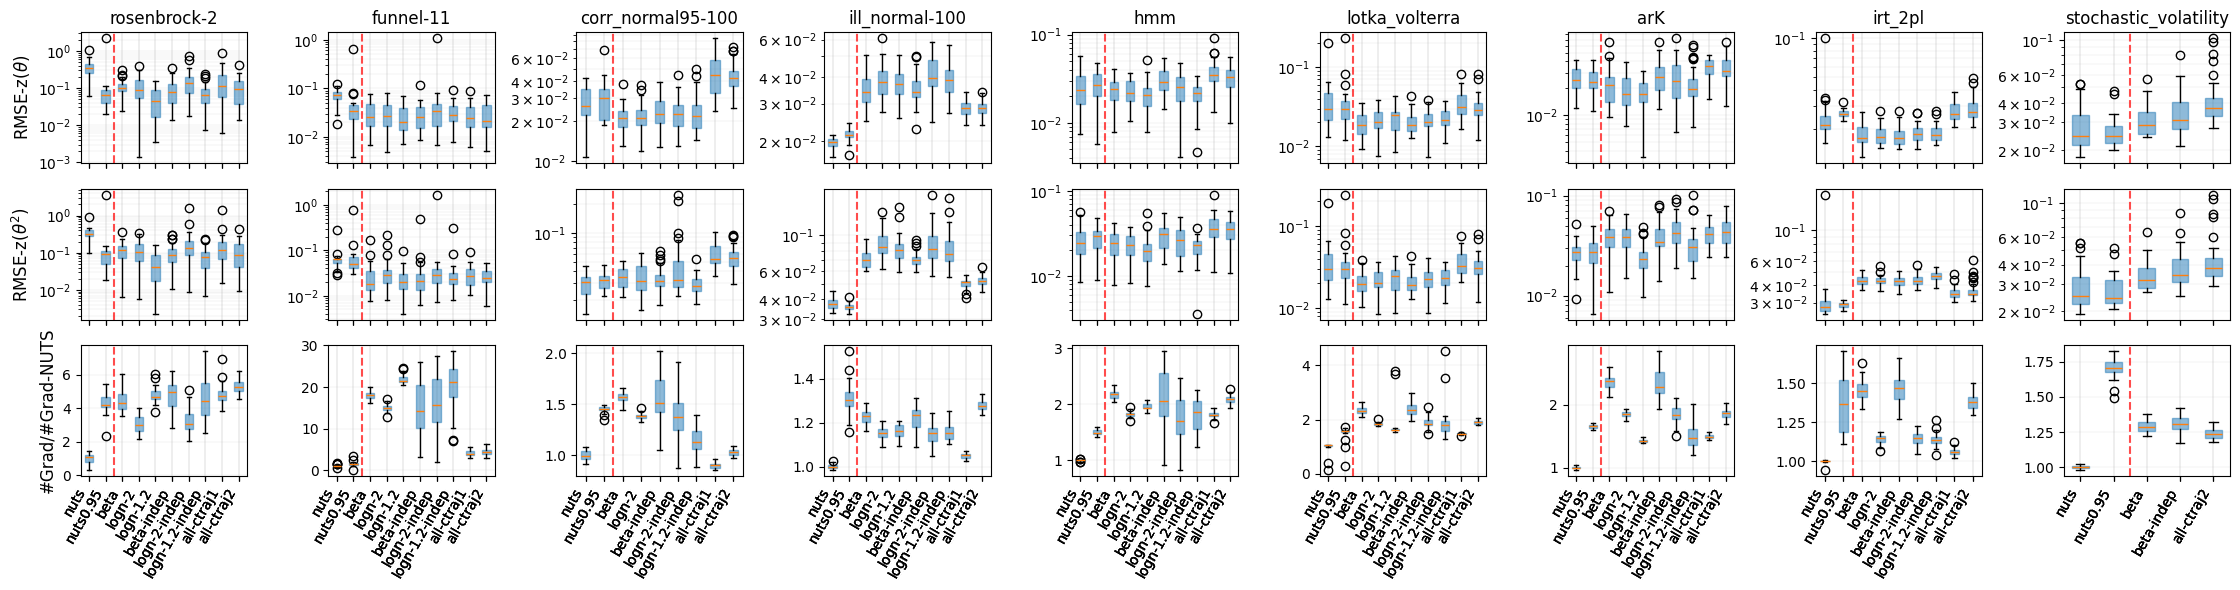

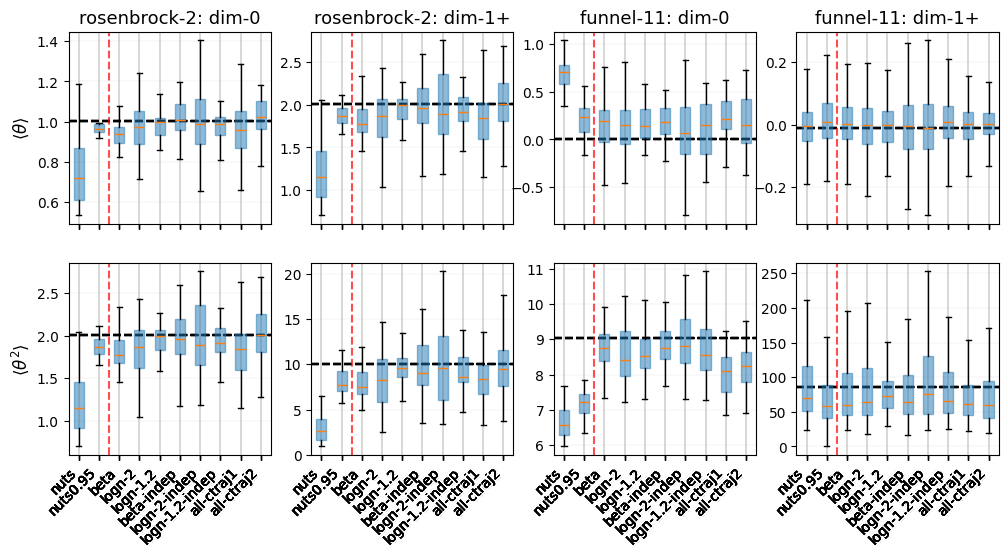

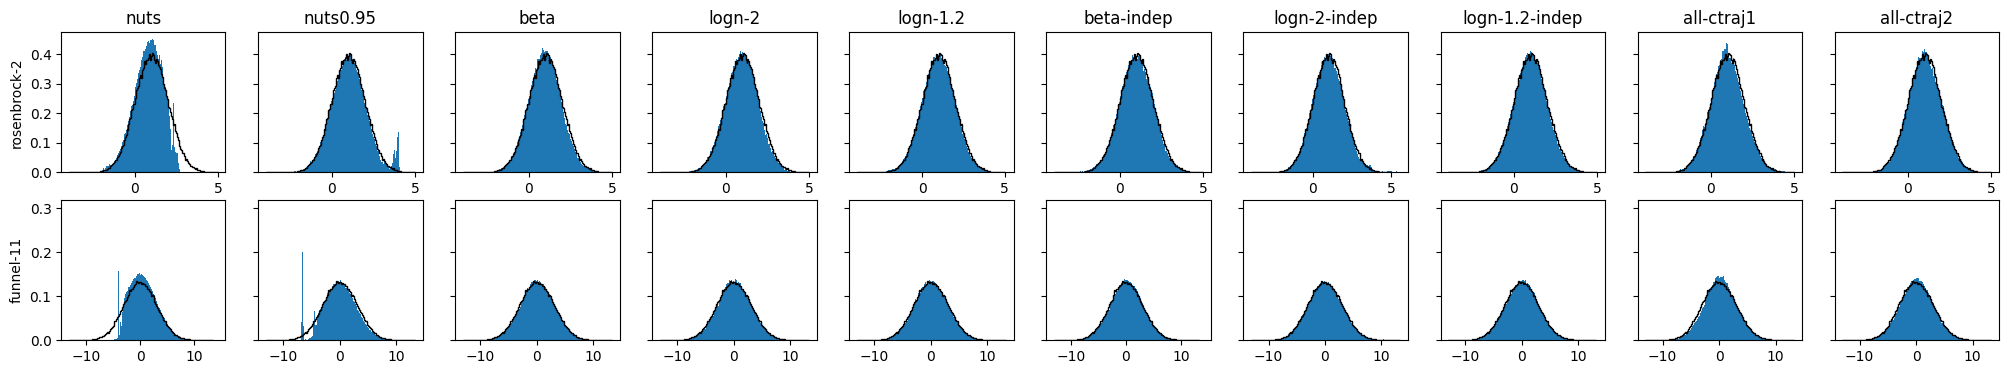

In [745]:
boxplot_experiments(alldata)
plt.show()
boxplot_experiments(alldata, fliers=True)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Compare three path lengths of atlas

In [51]:
nchains = 32
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [  "funnel-51"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    algfolder = 'atlasv2-nuts' 
    keys = ['atlas-allchains']
    i = 0 
    for suffix in [ '-prob1-ctraj1']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    keys = ['atlas-independent']
    i = 0 
    for suffix in [ '-prob1-ctraj1']: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    # algfolder = 'atlas-uturn' 
    # keys = ['atlas-uturn']
    # i = 0 
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1']: 
    #         for offset in [ 1.0]:
    #             key = keys[i] #f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             i += 1
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             data = get_data(path, key, data, nsamples)

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
funnel-11
corr_normal95-100
ill_normal-100
hmm
lotka_volterra
EXCEPTION IN (/tmp/ipykernel_755628/3182661342.py, LINE 8 "count, err1, err2 = np.load(f'{path}/rmse.npy')[..., :nsamples]"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/lotka_volterra//atlasv2-nuts/offset1.00-prob1-ctraj1//rmse.npy'
arK
irt_2pl
stochastic_volatility
EXCEPTION IN (/tmp/ipykernel_755628/3182661342.py, LINE 22 "suturn = np.stack([np.load(f'{path}/samples_constrained-{i}.npy')[:nsamples] for i in range(nchains)])"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/stochastic_volatility//atlasv2-nuts/offset1.00-prob1-ctraj1//samples_constrained-0.npy'


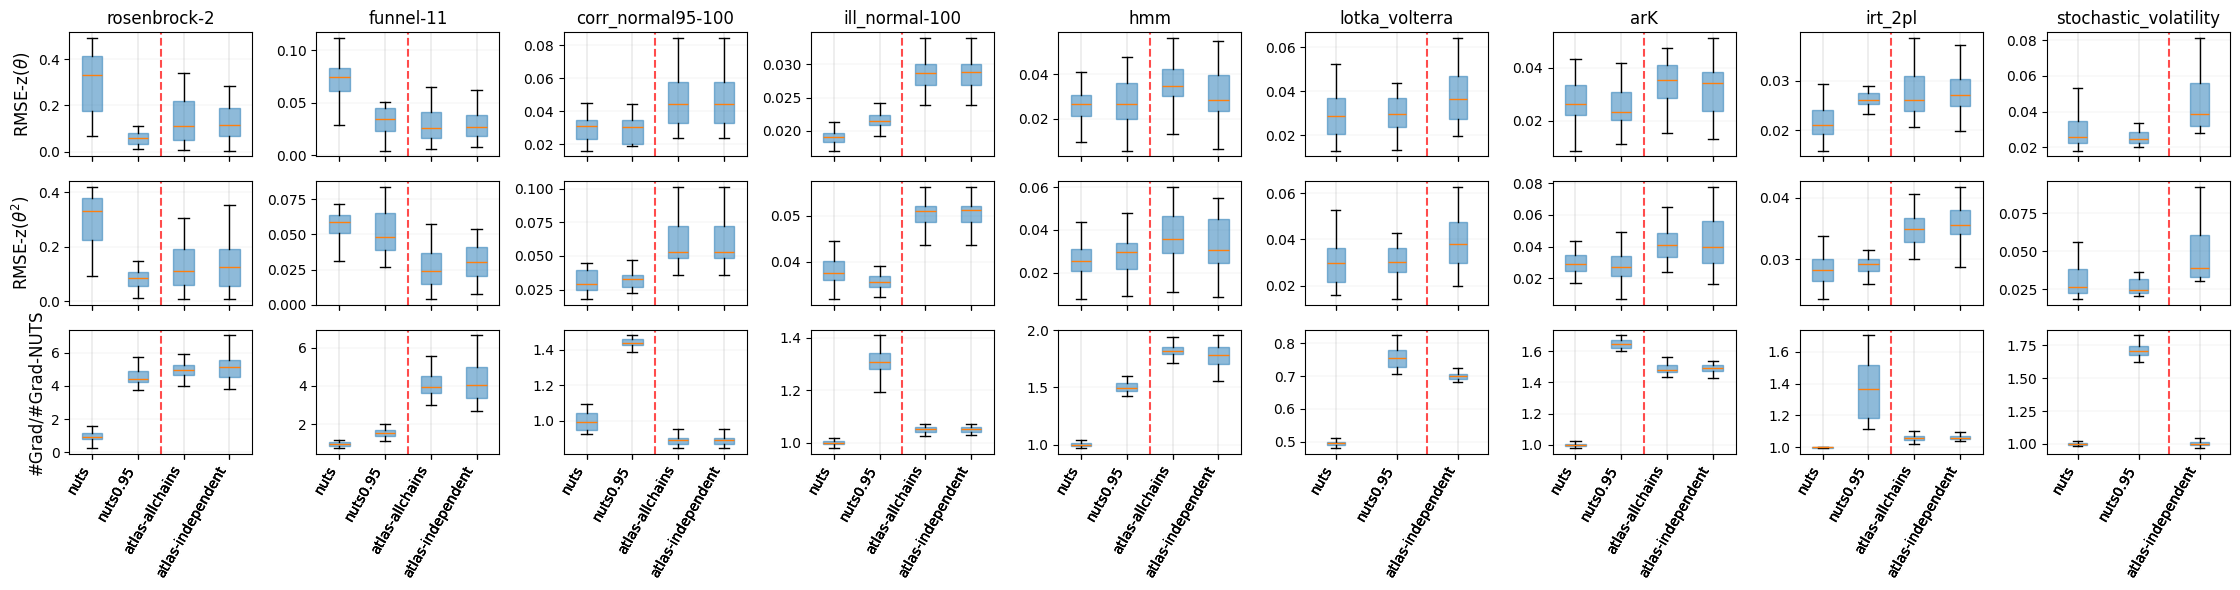

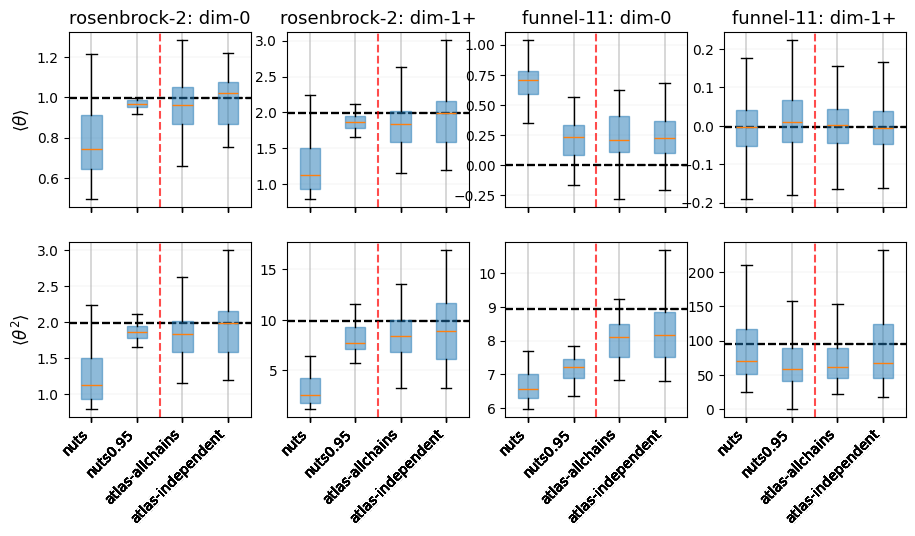

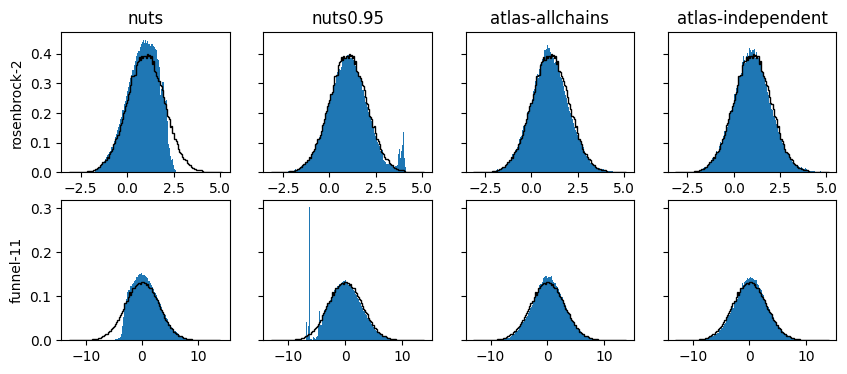

In [45]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Uniform trajectories


In [46]:
nchains = 32
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [  "funnel-51"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    suffixes = [ '-prob1-ctraj1',  '-prob1-ctraj1-uninleap']
    keys = ['allchains', 'allchains-uniform']
    algfolder = 'atlasv2-nuts' 
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    keys = ['independent', 'independent-uniform']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
funnel-11
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2443033155.py, LINE 11 "raise"): No activ

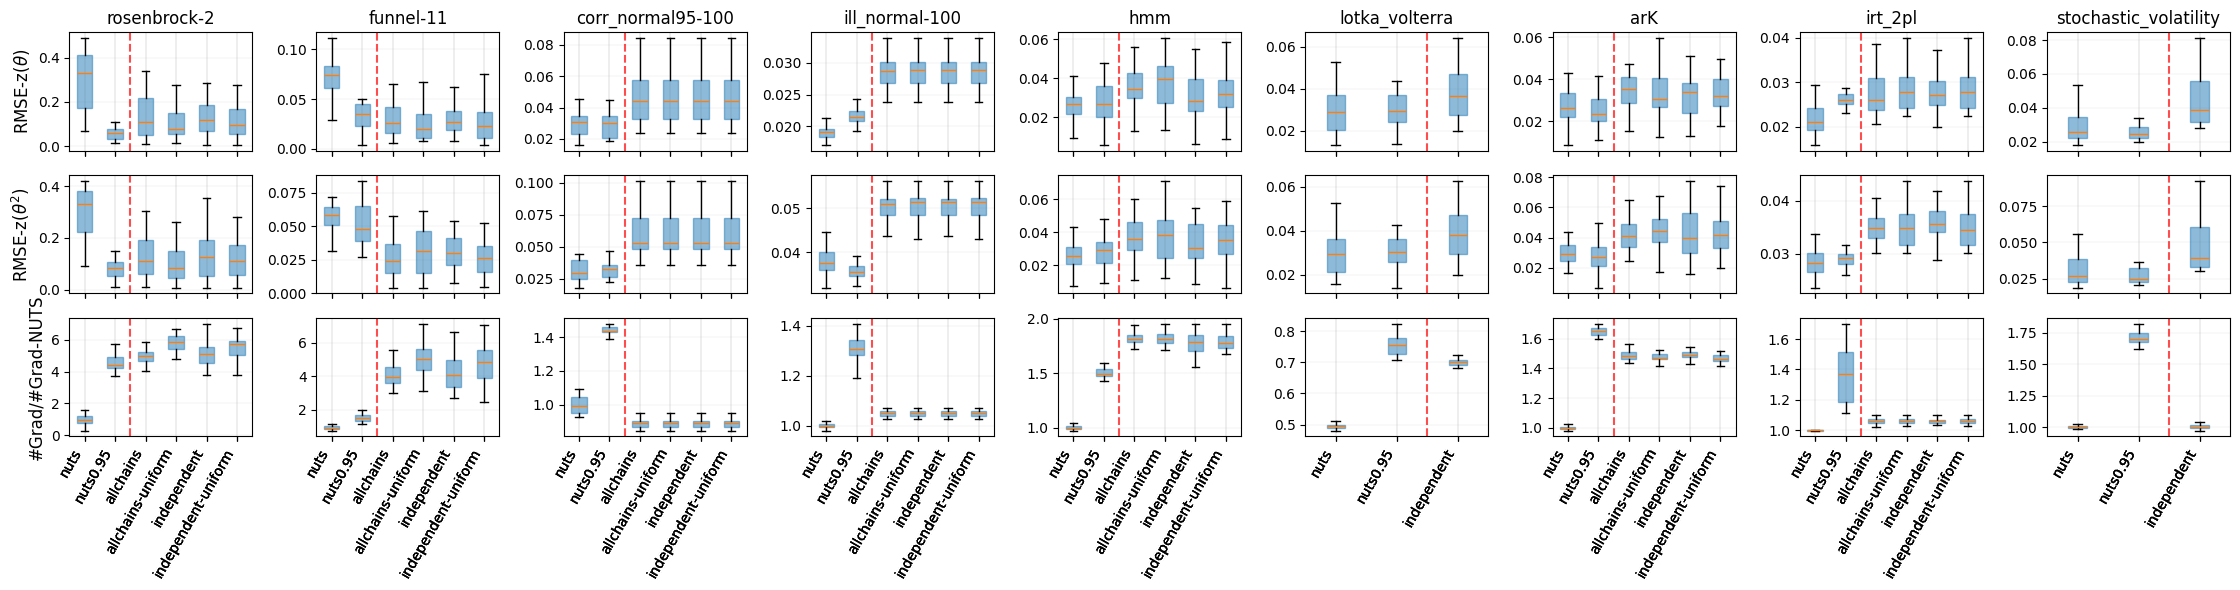

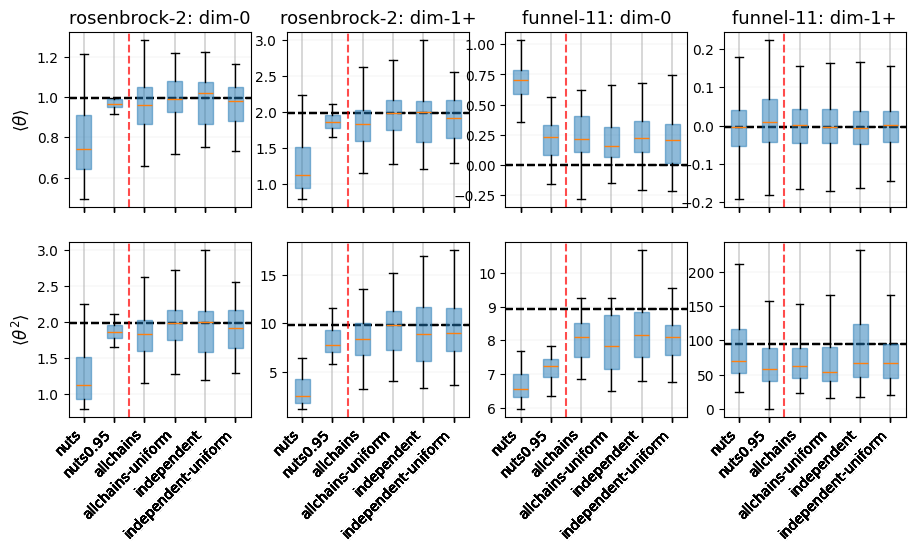

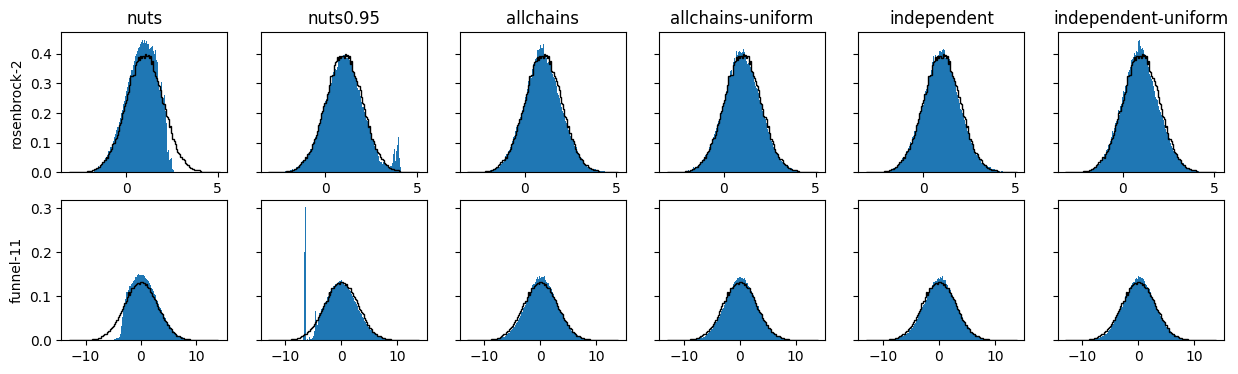

In [47]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# constant traj 2

In [201]:
nchains = 32
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [ "lotka_volterra", "hmm"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    suffixes = [ '-prob1-ctraj1',  '-prob1-ctraj2']#, '-prob1-ctraj1-uninleap',  '-prob1-ctraj2-uninleap']
    algfolder = 'atlasv2-nuts' 
    keys = ['all-ctraj1', 'all-ctraj2', 'all-ctraj3' ]#'all-ctraj1-unif', 'all-ctraj2-unif']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    keys = ['indep-ctraj1', 'indep-ctraj2', 'indep-ctraj1-unif', 'indep-ctraj2-unif']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

    algfolder = 'atlasv2-nuts-indep' 
    keys = ['indep-ctraj1', 'indep-ctraj2', 'indep-ctraj3'] #'indep-ctraj1-unif', 'indep-ctraj2-unif']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

lotka_volterra
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 14 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
(32, 1999, 8) (30, 1999)
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
(32, 1999, 8) (30, 1999)
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
(32, 1999, 8) (30, 1999)
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 12 "assert count.shape[0] == samples.shape[0]"): 
(32, 1999, 8) (30, 1999)
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 14 "raise"): No active exception to reraise
(32, 1999, 8) (30, 1999)
EXCEPTION IN (/tmp/ipykernel_755628/2671868004.py, LINE 14 "raise"): No active exception to reraise
(32, 1999, 8) (30, 1999)
hmm
E

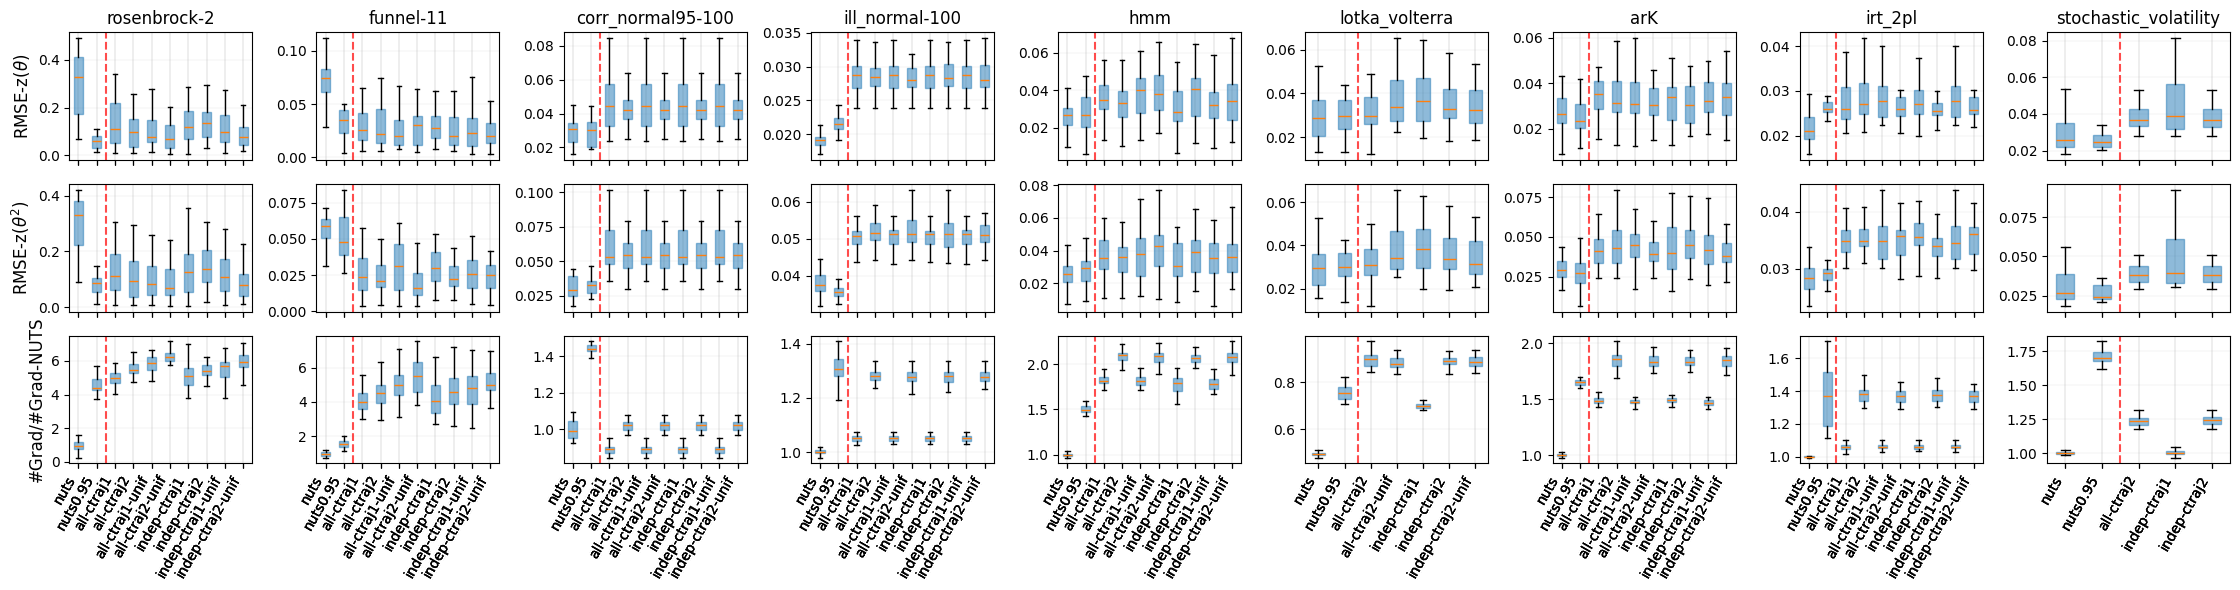

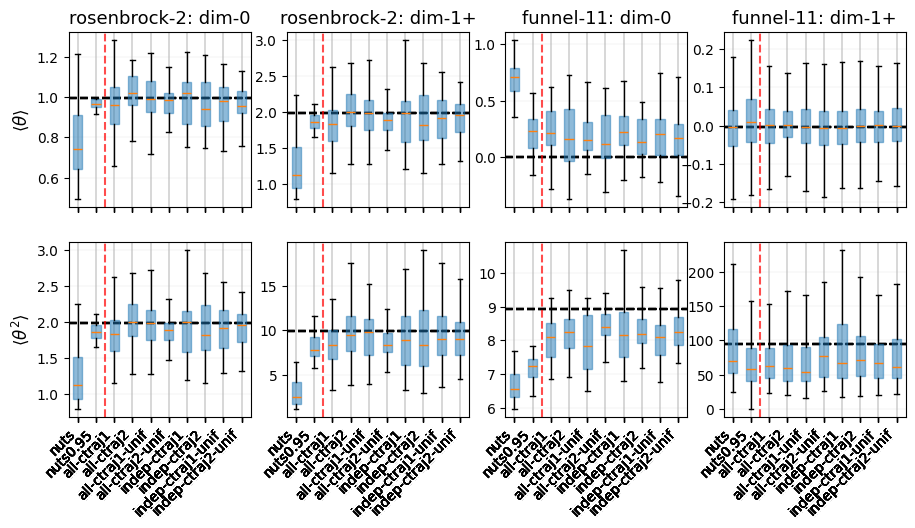

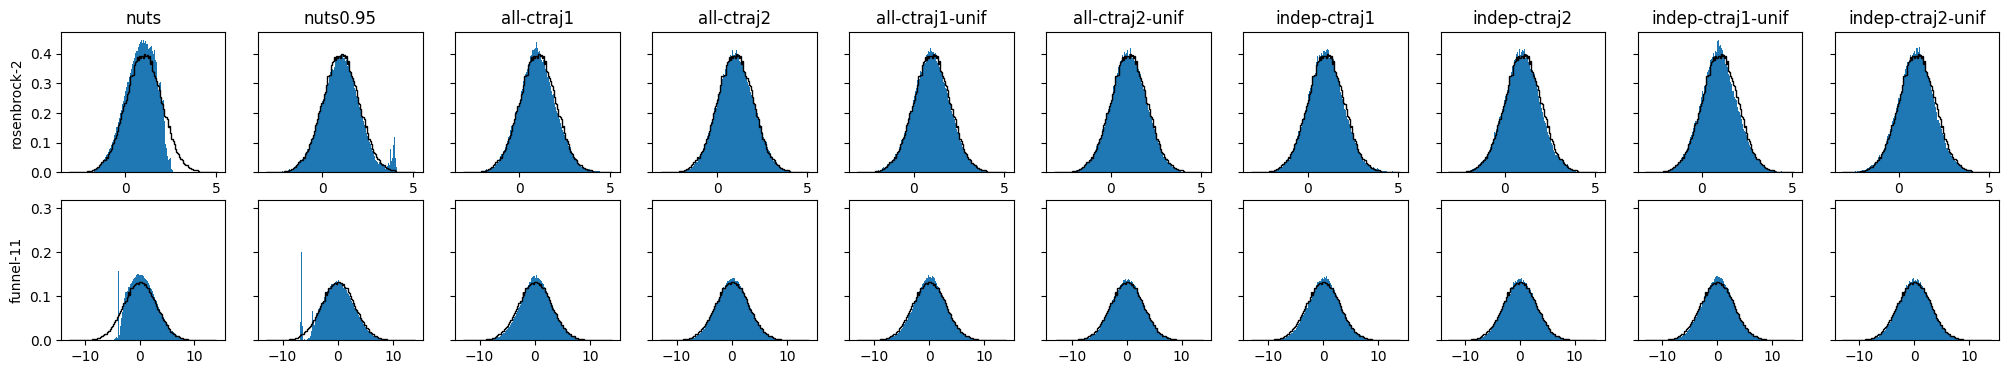

In [49]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Hessian 5 

In [393]:
# 0.42/2**9,  0.42/250
# (0.42/2**9 ) / (0.42/250)

0.48828125

In [35]:
nchains = 32
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [  "funnel-51"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    suffixes = [ '-prob1-ctraj1-uninleap',  '-prob1-ctraj1-uninleap-hess5']
    algfolder = 'atlas-nuts' 
    keys = ['allchains-uniform', 'allchains-uniform-hess5']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlas-nuts-indep' 
    keys = ['indep-uniform', 'indep-uniform-hess5']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
funnel-11
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LINE 10 "assert count.shape[1] == samples.shape[1]"): 
EXCEPTION IN (/tmp/ipykernel_3522325/693538.py, LI

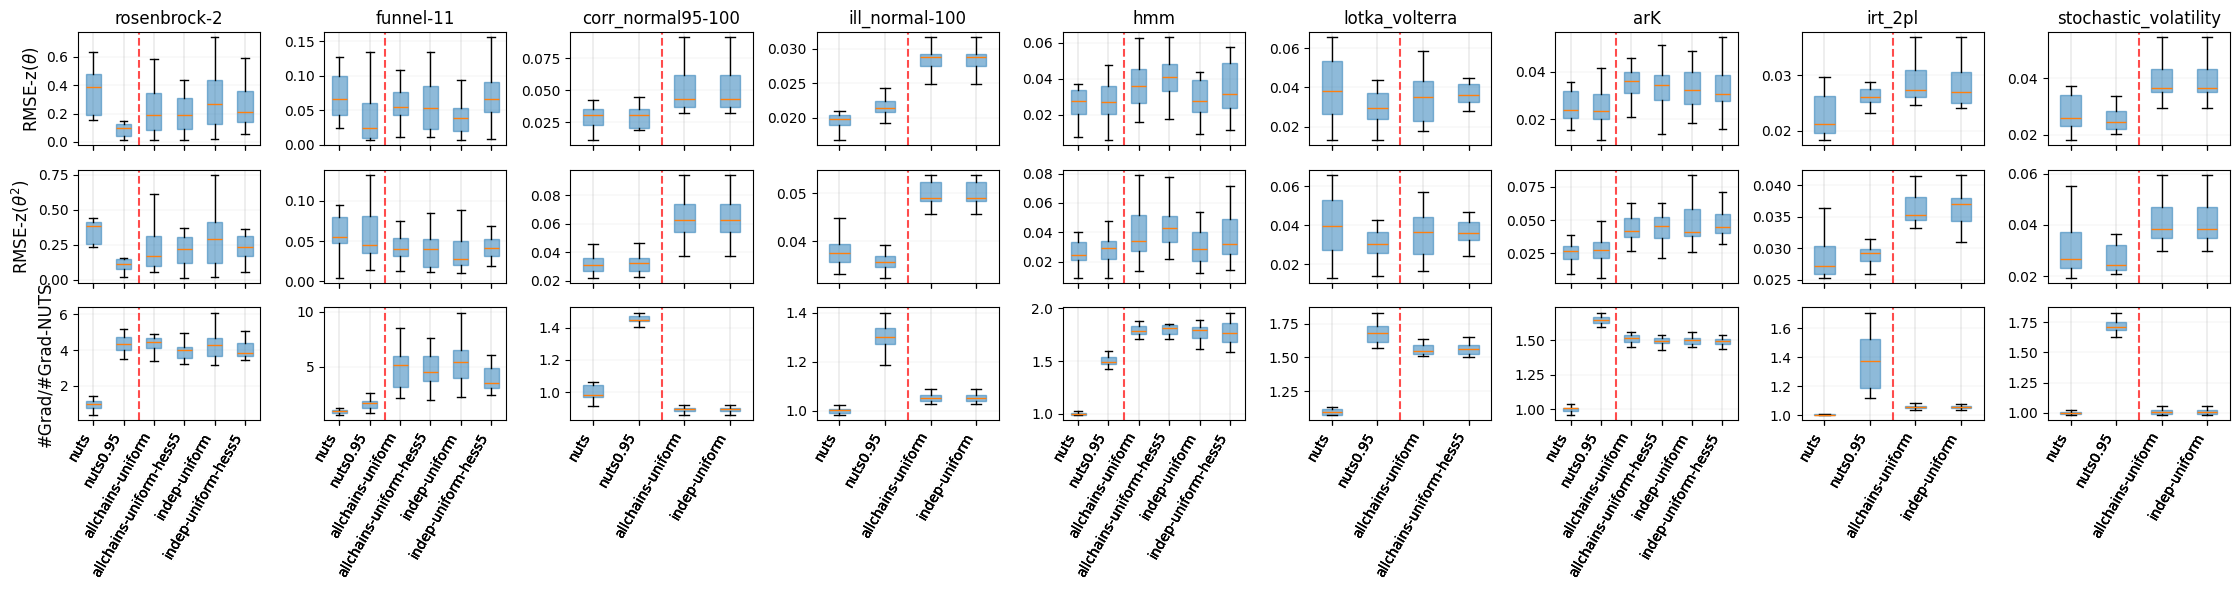

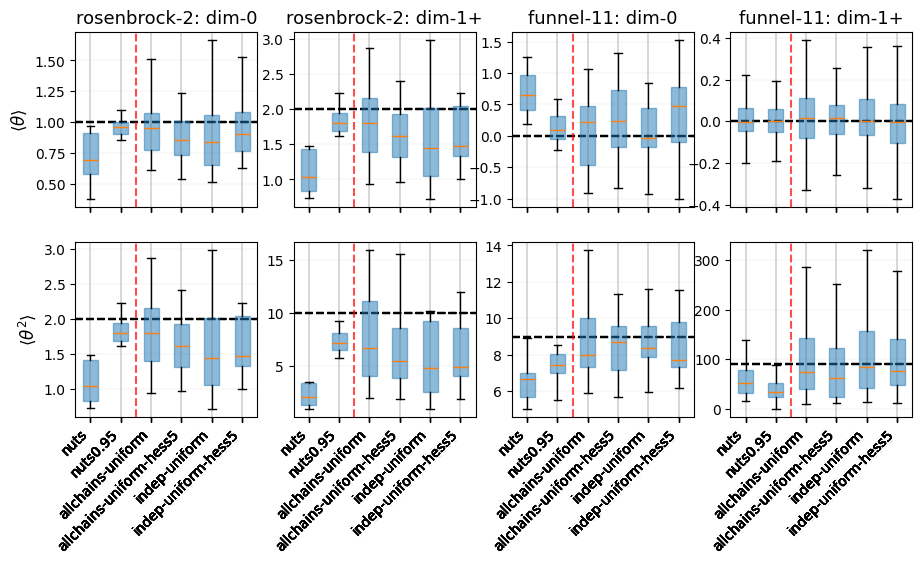

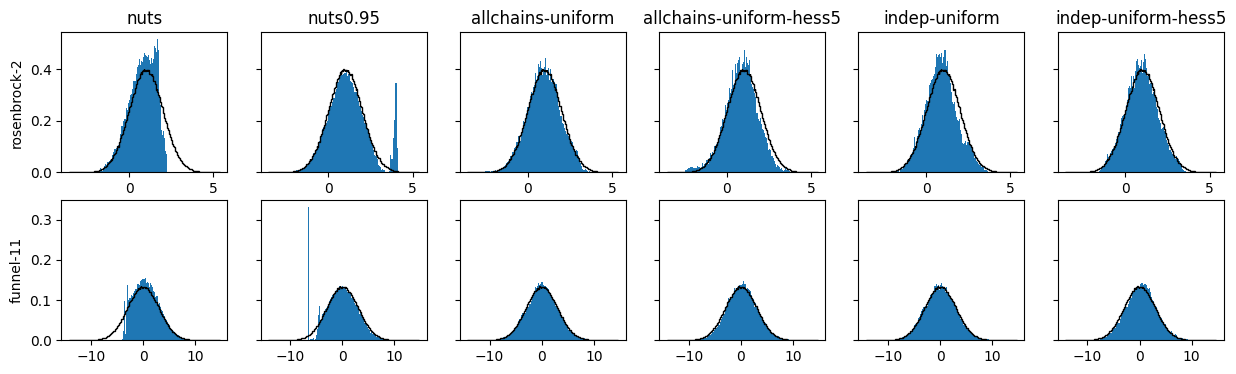

In [34]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# nleapadapt 200

In [103]:
nchains = 32
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [  "funnel-51"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 49999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    suffixes = [ '-prob1-ctraj1',  '-prob1-ctraj1-uninleap',  '-prob1-ctraj1-uninleap-adapt200']
    algfolder = 'atlas-nuts' 
    keys = ['allchains', 'allchains-uniform', 'allchains-uniform-nadapt200']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
            
    algfolder = 'atlas-nuts-indep' 
    keys = ['indep', 'indep-uniform', 'indep-uniform-nadapt200']
    i = 0 
    for suffix in suffixes: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)



    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
funnel-11
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise")

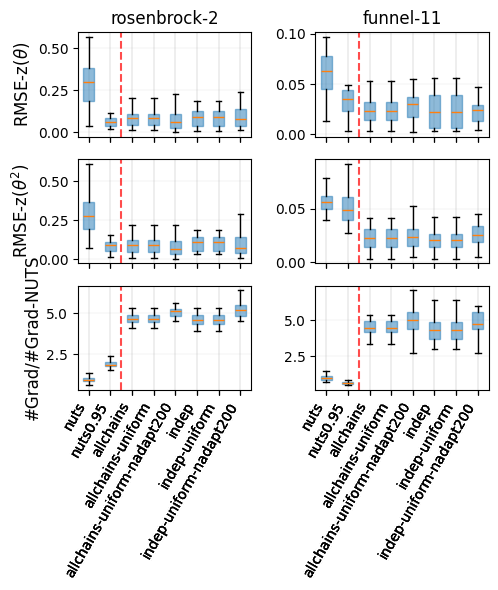

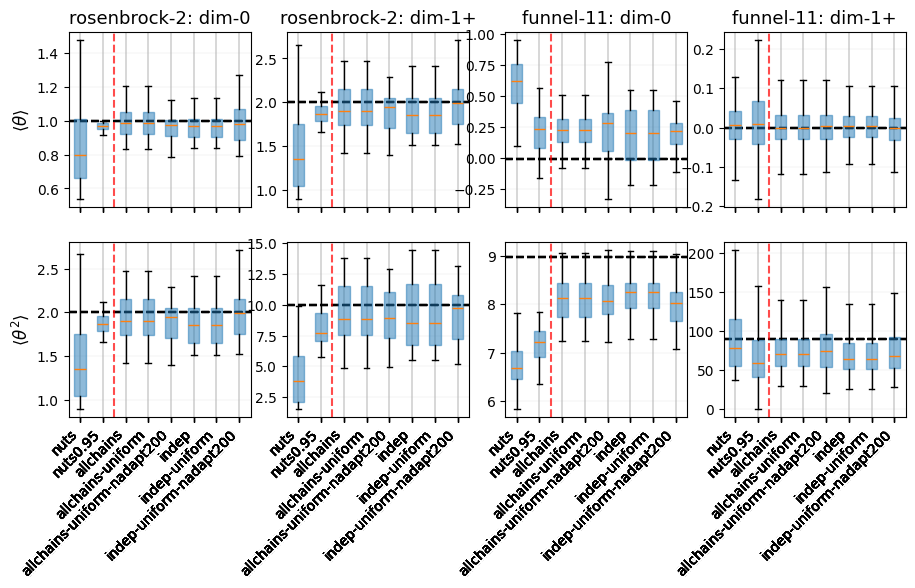

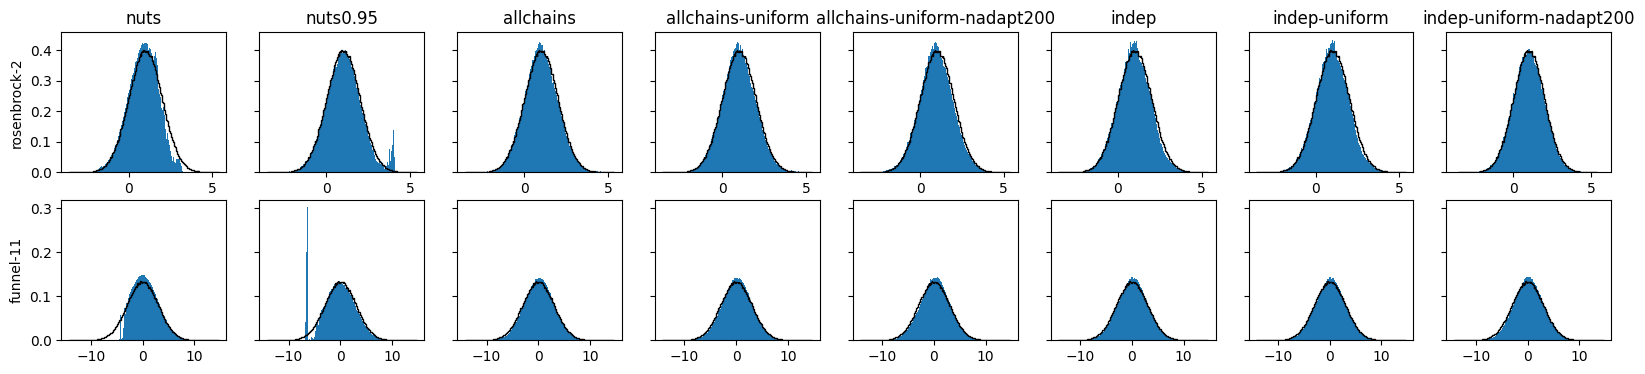

In [105]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Compare probabilistic vs not

In [26]:
nchains = 16
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11",  "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'rosenbrock-2' or exp == 'funnel-51':
        nsamples = 4999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        
        

    algfolder = 'atlas-nuts' 
    keys = ['atlas-allchains', 'atlas-allchains-noprob']
    i = 0 
    for suffix in [ '-prob1-ctraj1',  '-nodr-ctraj1']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlas-nuts-indep' 
    keys = ['atlas-independent', 'atlas-independent-noprob']
    i = 0 
    for suffix in [ '-prob1-ctraj1',  '-nodr-ctraj1']: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    # algfolder = 'atlas-uturn' 
    # keys = ['atlas-uturn']
    # i = 0 
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1']: 
    #         for offset in [ 1.0]:
    #             key = keys[i] #f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             i += 1
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             print(key, path)
    #             data = get_data(path, key, data)
    
    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise



KeyboardInterrupt



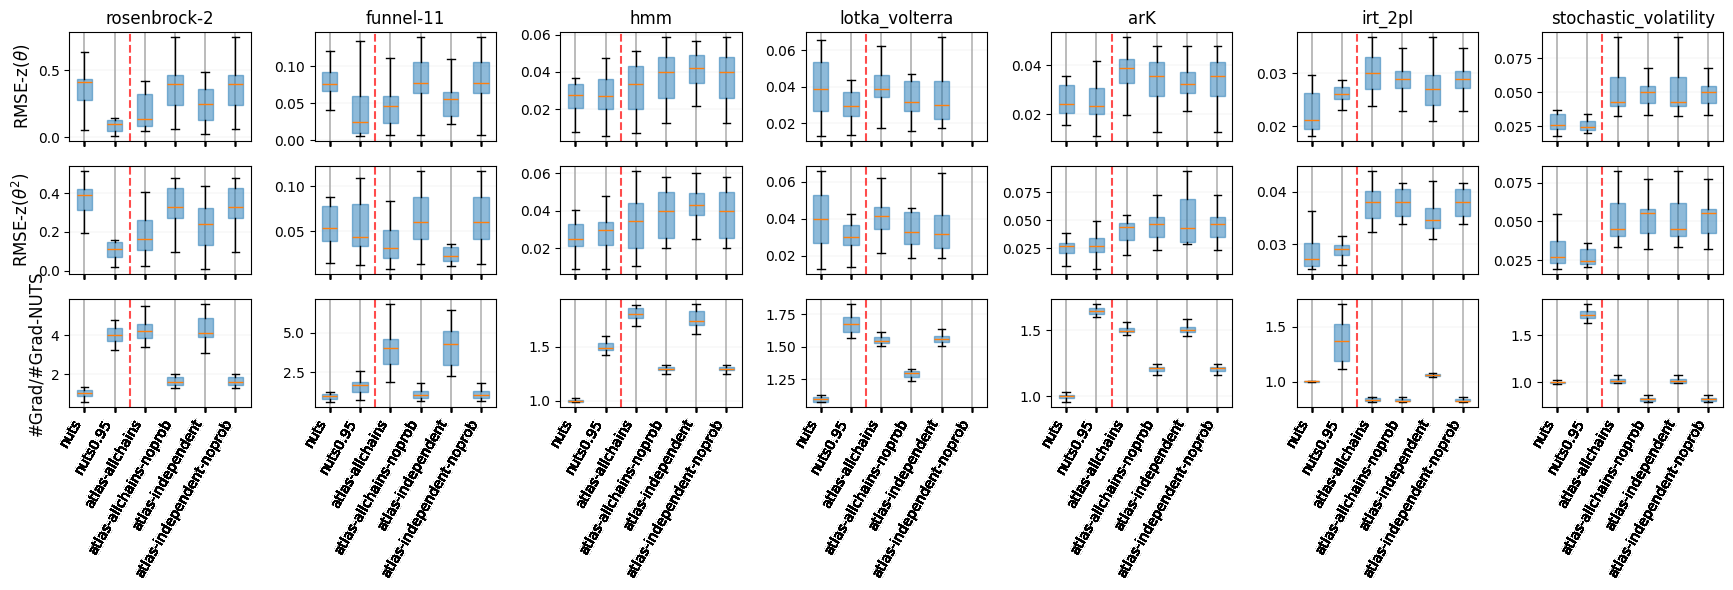

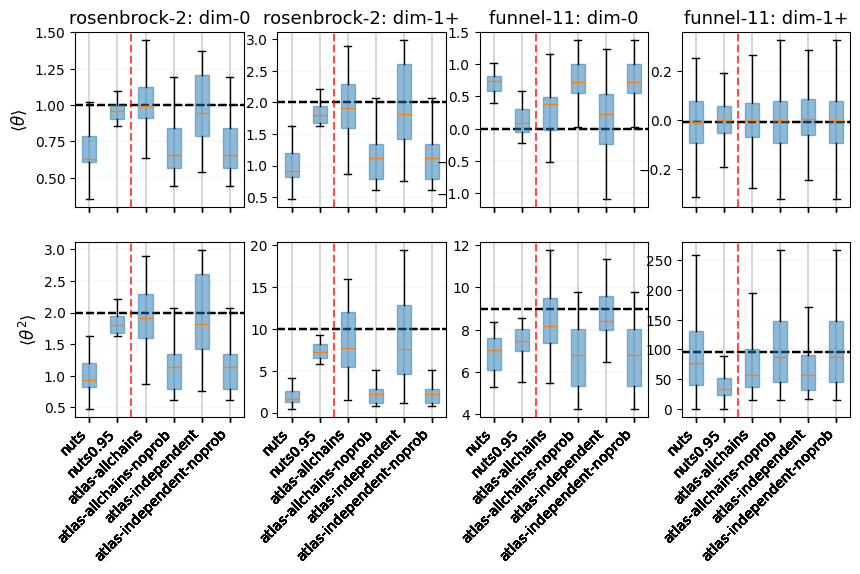

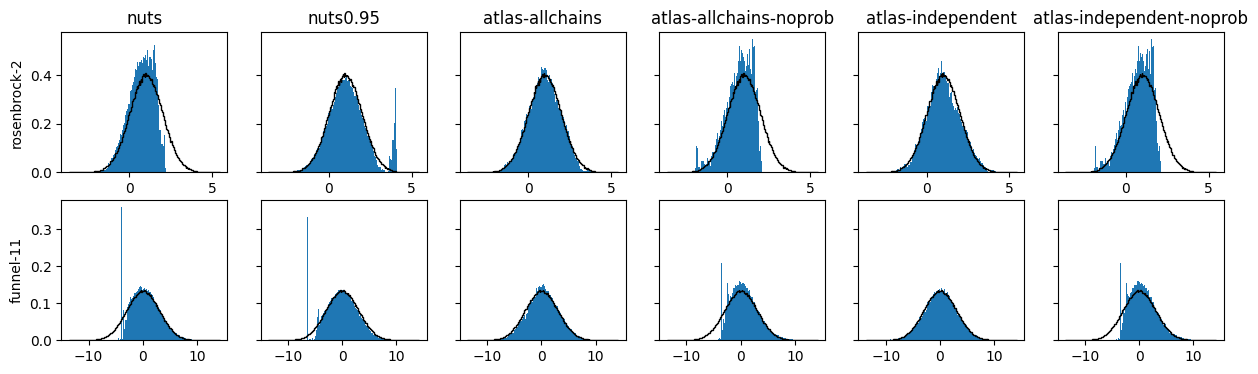

In [96]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# Compare lognormal vs beta for atlas

In [804]:
nchains = 32
alldata = {}

for exp in ["rosenbrock-2",  "funnel-11", "corr_normal95-100",   "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 9999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        assert snuts.shape[:2] == (nchains, nsamples)
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    # suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal', '-prob1-ctraj1-lognormal-stepsig1.2']
    # suffixes += [ '-prob1-ctraj2', '-prob1-ctraj2-lognormal', '-prob1-ctraj2-lognormal-stepsig1.2']
    suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal-stepsig1.2']
    suffixes += [ '-prob1-ctraj2', '-prob1-ctraj2-lognormal-stepsig1.2']
    keys = ['beta', 'lognormal']
    keys += [f'ct-{k}' for k in keys]
    i = 0 
    algfolder = 'atlasv2-nuts' 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = f"off{offset:0.2f}{suffix}"
            key = keys[i]
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    i = 0 
    for suffix in suffixes : #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            # key = f"off{offset:0.2f}{suffix}-indep"
            key = keys[i] + '-indep'
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)
            
            
    # algfolder = 'atlas-uturn' 
    # key = ['uturn-beta', 'uturn-lognormal']
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1', '-prob1-lognormal']: 
    #         for offset in [ 1.0]:
    #             key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             print(key, path)
    #             data = get_data(path, key, data)

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
beta /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts/offset1.00-prob1-ctraj1/
lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts/offset1.00-prob1-ctraj1-lognormal-stepsig1.2/
ct-beta /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts/offset1.00-prob1-ctraj2/
ct-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/
funnel-11
beta /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlasv2-nuts/offset1.00-prob1-ctraj1/
lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlasv2-nuts/offset1.00-prob1-ctraj1-lognormal-stepsig1.2/
ct-beta /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlasv2-nuts/offset1.00-prob1-ctraj2/
ct-lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlasv2-nuts/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/
corr_normal95-100
beta /mnt/ceph/users/cmodi/atlassampler/corr_normal95-100//atlasv2-nuts/offset1.00-prob1-ctraj1/
lognormal /mnt/ceph/us

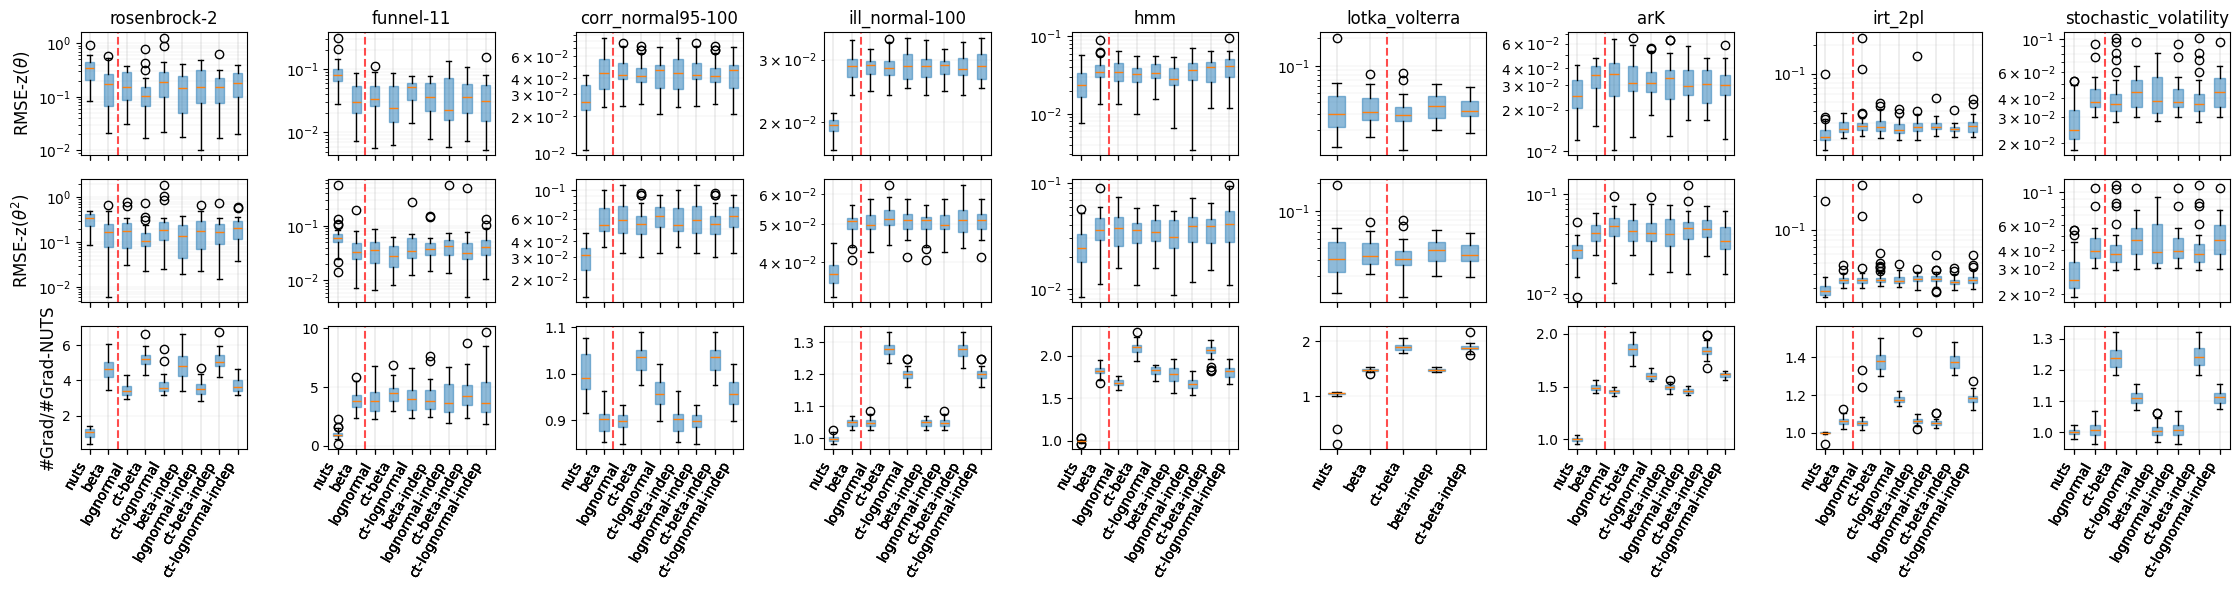

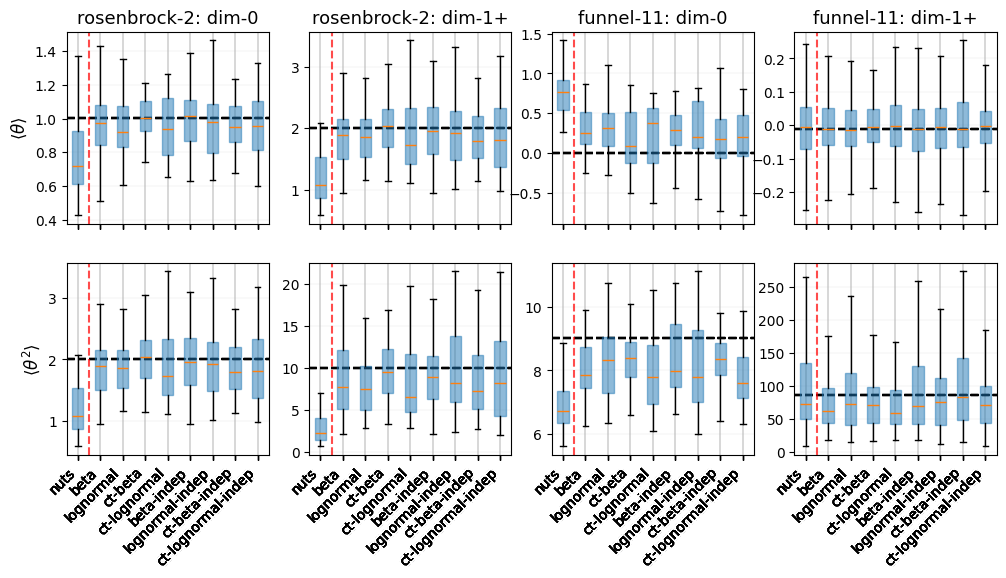

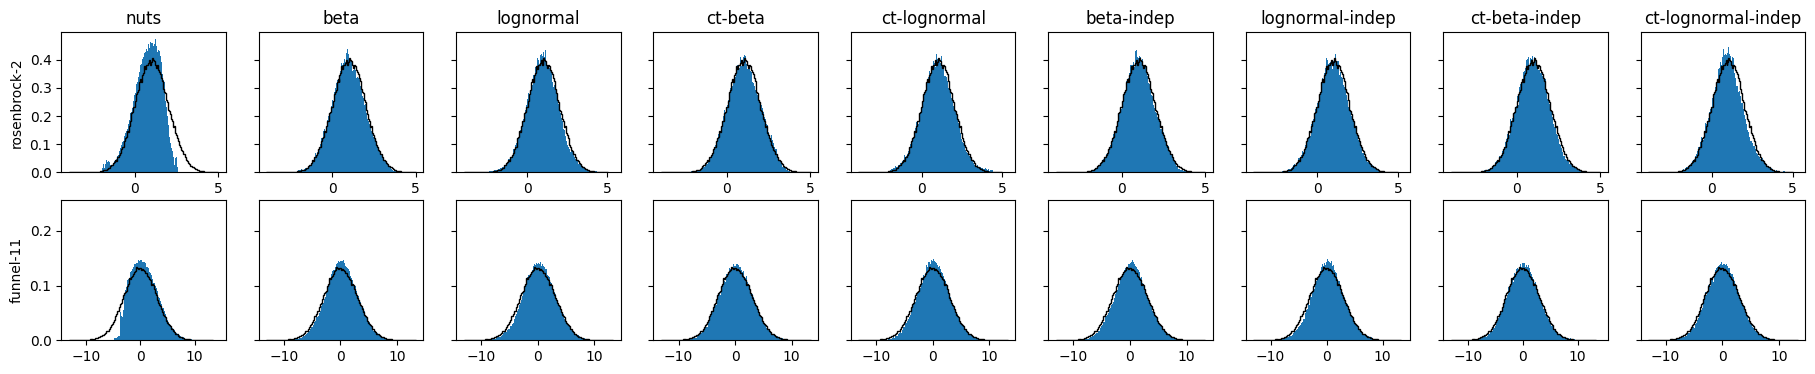

In [805]:
boxplot_experiments(alldata, fliers=True)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

In [ ]:
# nchains = 32
# alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "corr_normal95-100",   "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# # for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# # for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
#     print(exp)
#     data = {}
#     if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
#         nsamples = 19999
#     else: nsamples = 1999 

#     ref = reference_samples[exp]
#     data['ref'] = ref
    
#     for ta in [0.8, 0.95]:
#         nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
#         snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
#         gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
#         count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
#         key = f'nuts{ta:0.2f}'
#         if ta == 0.8: key = 'nuts'
#         data[key] = [count, err1, err2, snuts]        
        

#     suffixes = [ '-prob1-ctraj1-uninleap', '-prob1-ctraj1-uninleap-lognormal', '-prob1-ctraj1-uninleap-lognormal-stepsig1.2']
#     suffixes += [ '-prob1-ctraj2-uninleap', '-prob1-ctraj2-uninleap-lognormal', '-prob1-ctraj2-uninleap-lognormal-stepsig1.2']
#     keys = ['beta', 'logn2', 'lon1.2']
#     keys += ['ct2-beta', 'ct2-logn2', 'ct2-logn1.2']
#     i = 0 
#     algfolder = 'atlasv2-nuts' 
#     for suffix in suffixes: 
#         for offset in [1.0]:
#             # key = f"off{offset:0.2f}{suffix}"
#             key = keys[i]
#             i += 1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#             print(key, path)
#             data = get_data(path, key, data, nsamples)

            
#     algfolder = 'atlasv2-nuts-indep' 
#     i = 0 
#     for suffix in suffixes : #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
#         for offset in [1.0]:
#             # key = f"off{offset:0.2f}{suffix}-indep"
#             key = keys[i] + '-indep'
#             i += 1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#             data = get_data(path, key, data, nsamples)
            
            
#     # algfolder = 'atlas-uturn' 
#     # key = ['uturn-beta', 'uturn-lognormal']
#     # for offd in [ 1.0]:
#     #     for suffix in [ '-prob1', '-prob1-lognormal']: 
#     #         for offset in [ 1.0]:
#     #             key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
#     #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#     #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
#     #             print(key, path)
#     #             data = get_data(path, key, data)

#     alldata[exp] = data

    
# nexps = len(alldata.keys())
# allkeys = list(data.keys())

In [ ]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# sensitivity to initial step size

In [864]:
nchains = 32
alldata = {}

for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100",   "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100",   "ill_normal-100", "hmm", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 49999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.65, 0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        
    ta = 0.8
    for sfac in [1.5, 2.0]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}-stepfac{sfac:0.1f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}-sfac{sfac:0.1f}'
        data[key] = [count, err1, err2, snuts]        
        

    algfolder = 'atlasv2-nuts-indep' 
    keys = ['beta', 'beta-stepfac2', 'long', 'logn-stepfac2']
    # keys = ['beta', 'beta-targe0.65', 'long', 'logn-targe0.65']
    i = 0 
    # for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-target0.65',  '-prob1-ctraj1-lognormal-stepsig1.2', '-prob1-ctraj1-lognormal-stepsig1.2-target0.65']: 
    # for suffix in [ '-prob1-ctraj2', '-prob1-ctraj2-target0.65',  '-prob1-ctraj2-lognormal-stepsig1.2', '-prob1-ctraj2-lognormal-stepsig1.2-target0.65']: 
    for suffix in [ '-prob1-ctraj2', '-prob1-ctraj2-stepfac2.0',  '-prob1-ctraj2-lognormal-stepsig1.2', '-prob1-ctraj2-lognormal-stepsig1.2-stepfac2.0']: 
        for offset in [1.0]:
            # key = f"off{offset:0.2f}{suffix}"
            key = keys[i]
            i+=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            data = get_data(path, key, data, nsamples)

            
    # algfolder = 'atlas-nuts-indep' 
    # keys = ['indep-step1', 'indep-step2']
    # i = 0
    # for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-stepfac2']: 
    #     for offset in [1.0]:
    #         # key = f"off{offset:0.2f}{suffix}-indep"
    #         key = keys[i]
    #         i+=1
    #         path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #         data = get_data(path, key, data, nsamples)

            
#     algfolder = 'atlas-uturn' 
#     keys = ['uturn-step1', 'uturn-step2']
#     i = 0
#     for offd in [ 1.0]:
#         for suffix in [ '-prob1', '-prob1-stepfac2']: 
#             for offset in [ 1.0]:
#                 # key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
#                 key = keys[i]
#                 i+=1
#                 if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
#                 else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
#                 print(key, path)
#                 data = get_data(path, key, data, nsamples)

    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())

rosenbrock-2
EXCEPTION IN (/tmp/ipykernel_1461233/3424819675.py, LINE 11 "count, err1, err2 = np.load(f'{path}/rmse.npy')[..., :nsamples]"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler//rosenbrock-2/nuts/target0.80-stepfac1.5//rmse.npy'
beta /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts-indep/offset1.00-prob1-ctraj2/
beta-stepfac2 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts-indep/offset1.00-prob1-ctraj2-stepfac2.0/
long /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/
logn-stepfac2 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac2.0/
funnel-11
EXCEPTION IN (/tmp/ipykernel_1461233/3424819675.py, LINE 11 "count, err1, err2 = np.load(f'{path}/rmse.npy')[..., :nsamples]"): [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler//funnel-11/nuts/target0.80-stepfac1.5//rmse.npy'


In [808]:
# alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11",  "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# # for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# # for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK"]:
    
#     print(exp)
#     data = {}
#     if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
#         nsamples = 19999
#     else: nsamples = 1999 

#     ref = reference_samples[exp]
#     data['ref'] = ref
    
#     for ta in [0.8, 0.95]:
#         nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
#         snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
#         gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
#         count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
#         key = f'nuts{ta:0.2f}'
#         if ta == 0.8: key = 'nuts'
#         data[key] = [count, err1, err2, snuts]        
        

#     algfolder = 'atlas-indep' 
#     keys = ['target-0.50', 'target-0.65', 'target-0.80']
#     i = 0 
#     for suffix in [ '-prob1-ctraj1']: 
#         for target in [0.5, 0.65, 0.8]:
#             offset = 1.0
#             # key = f"off{offset:0.2f}{suffix}"
#             key = keys[i]
#             i+=1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target{target:0.2f}-offset{offset:0.2f}{suffix}/'
#             print(key, path)
#             data = get_data(path, key, data, nsamples)

#     algfolder = 'atlas' 
#     keys = ['pool-target-0.50', 'pool-target-0.65', 'pool-target-0.80']
#     i = 0 
#     for suffix in [ '-prob1-ctraj1']: 
#         for target in [0.5, 0.65, 0.8]:
#             offset = 1.0
#             # key = f"off{offset:0.2f}{suffix}"
#             key = keys[i]
#             i+=1
#             path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/target{target:0.2f}-offset{offset:0.2f}{suffix}/'
#             print(key, path)
#             data = get_data(path, key, data, nsamples)

#     alldata[exp] = data

    
# nexps = len(alldata.keys())
# allkeys = list(data.keys())

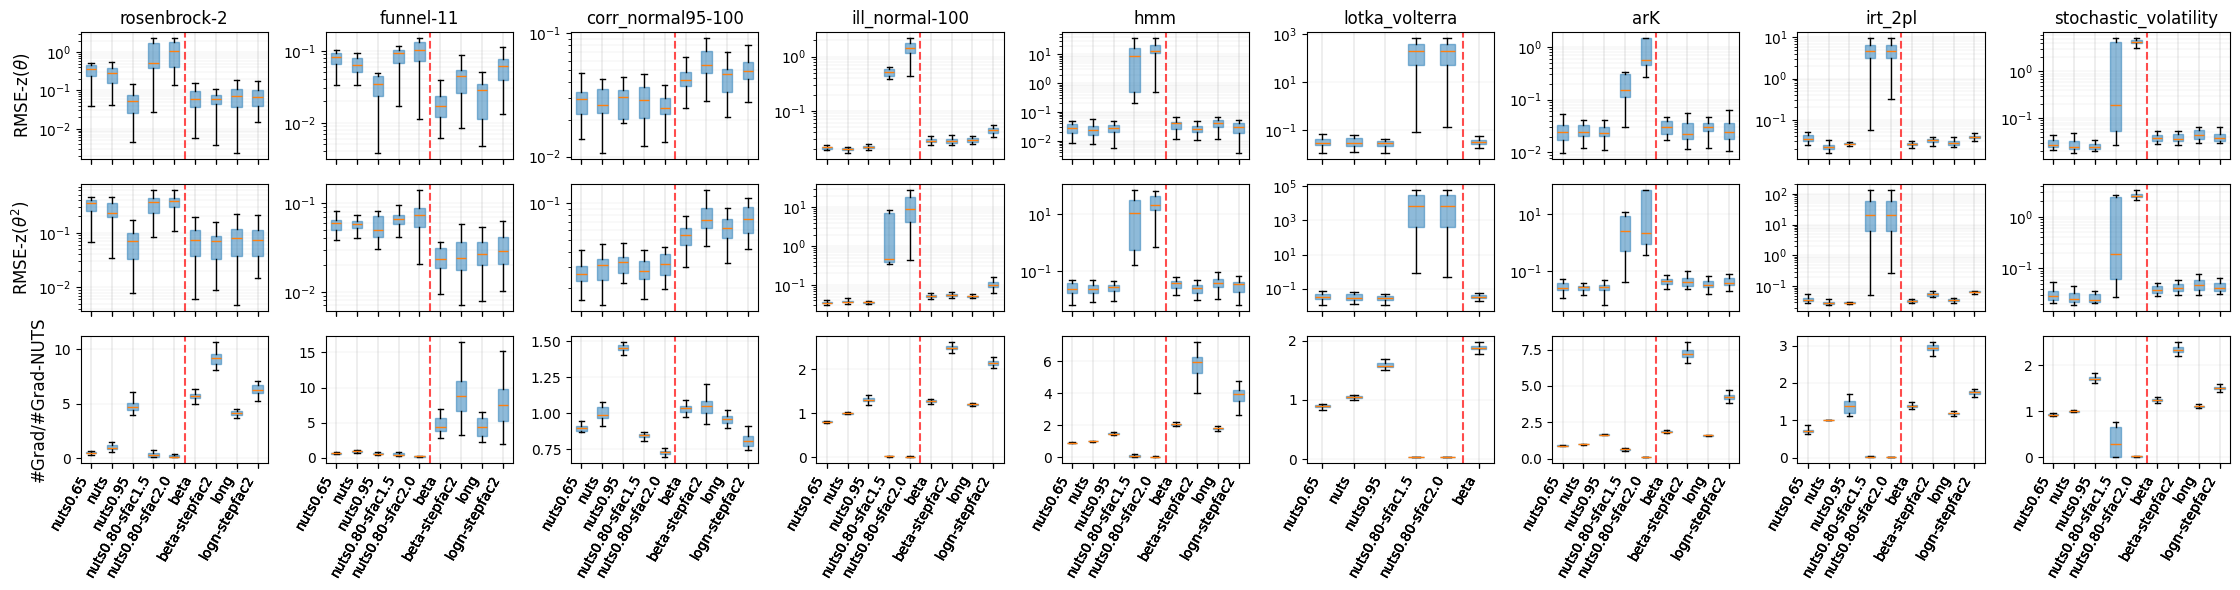

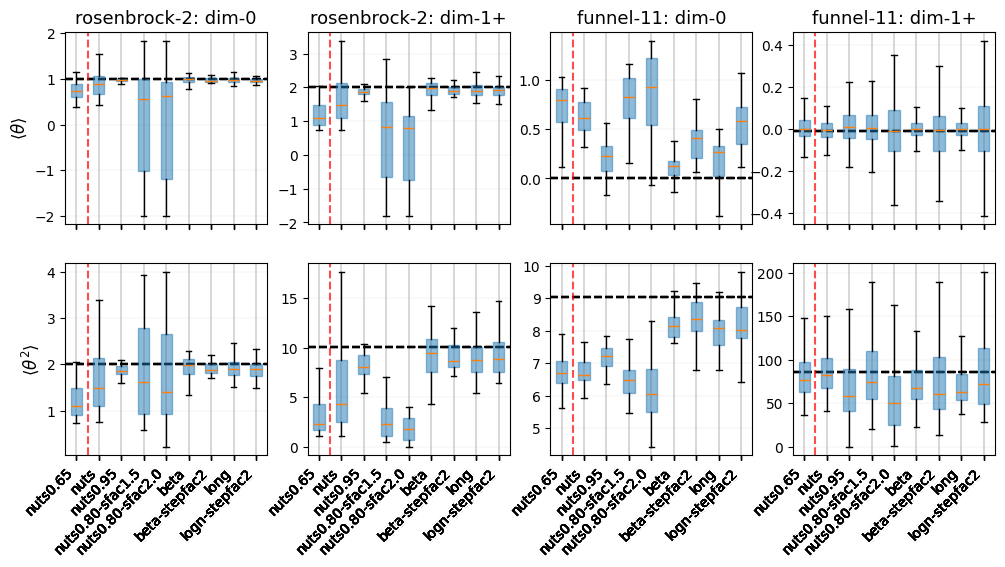

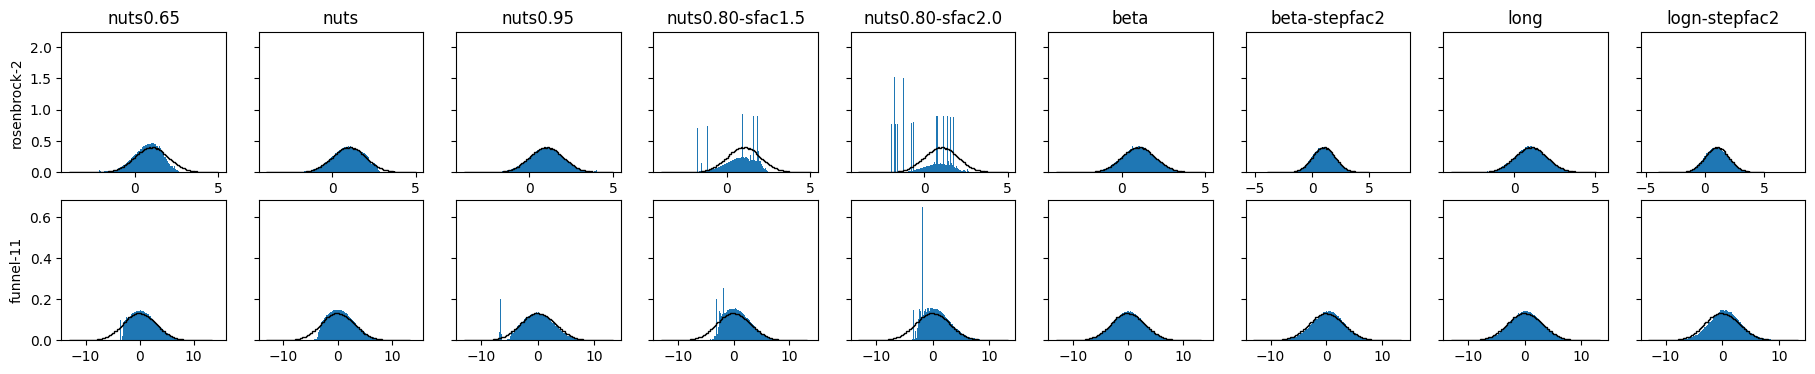

In [865]:
boxplot_experiments(alldata, baselines=5, logscale=True)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

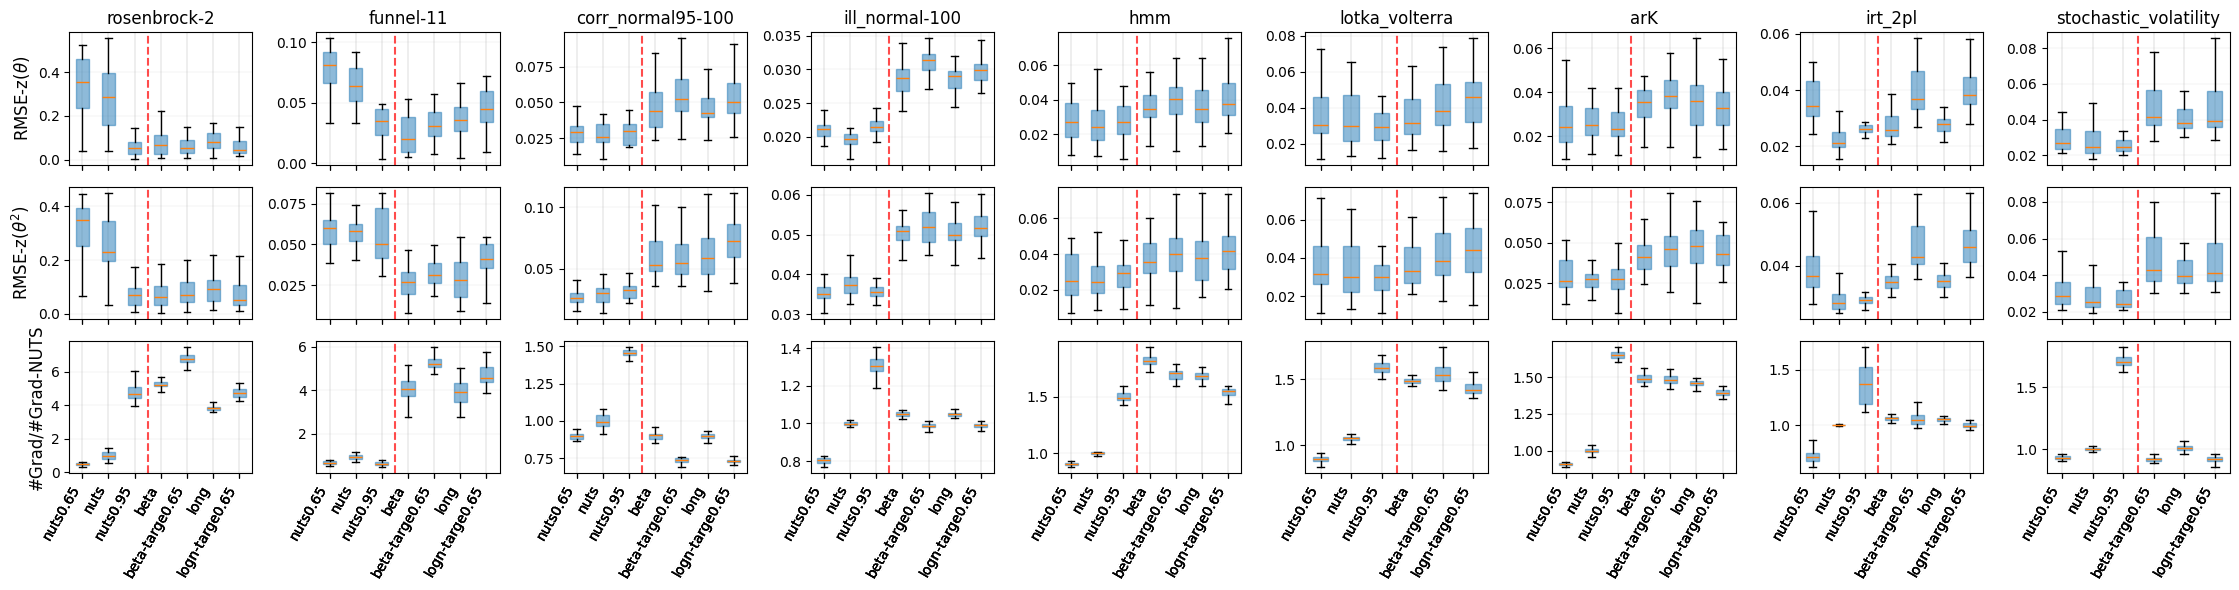

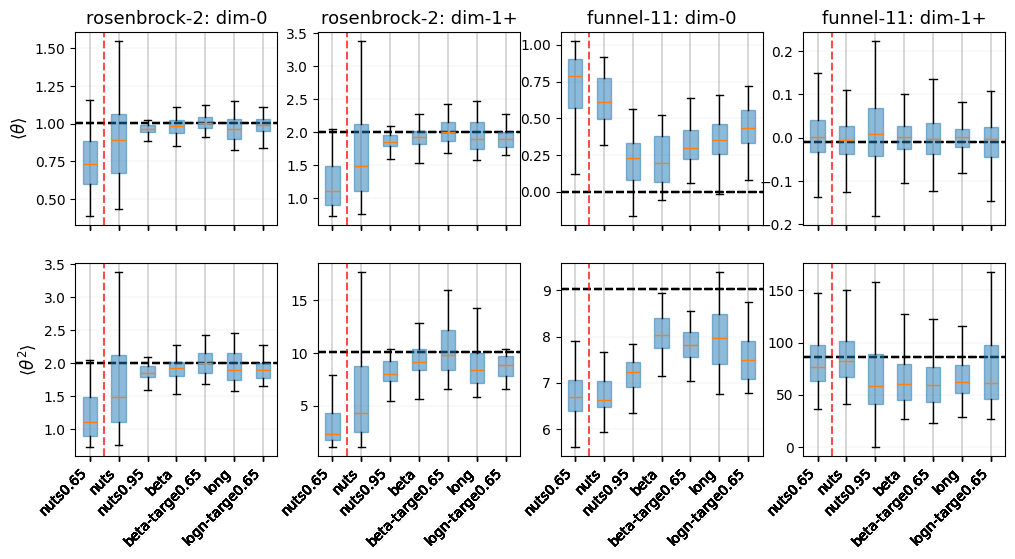

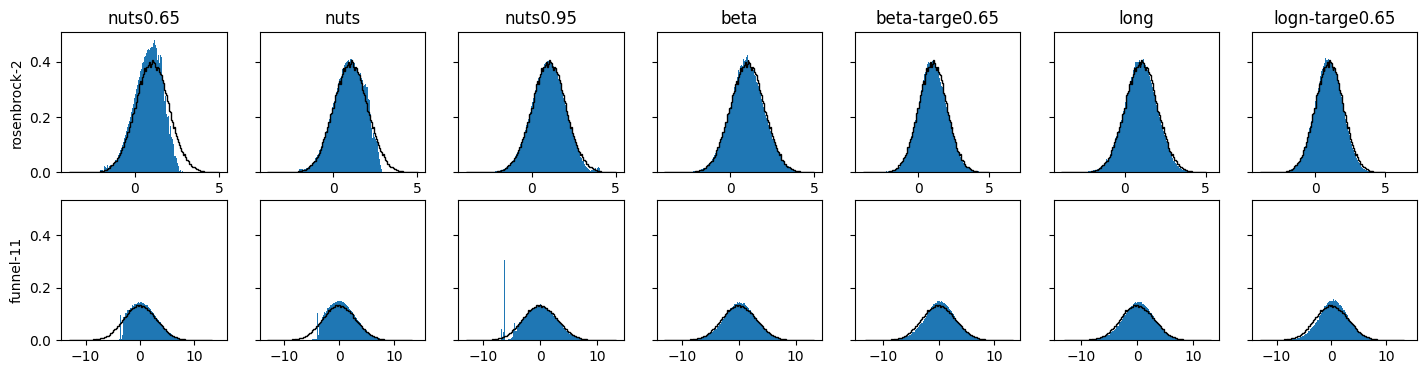

In [837]:
boxplot_experiments(alldata, baselines=3)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

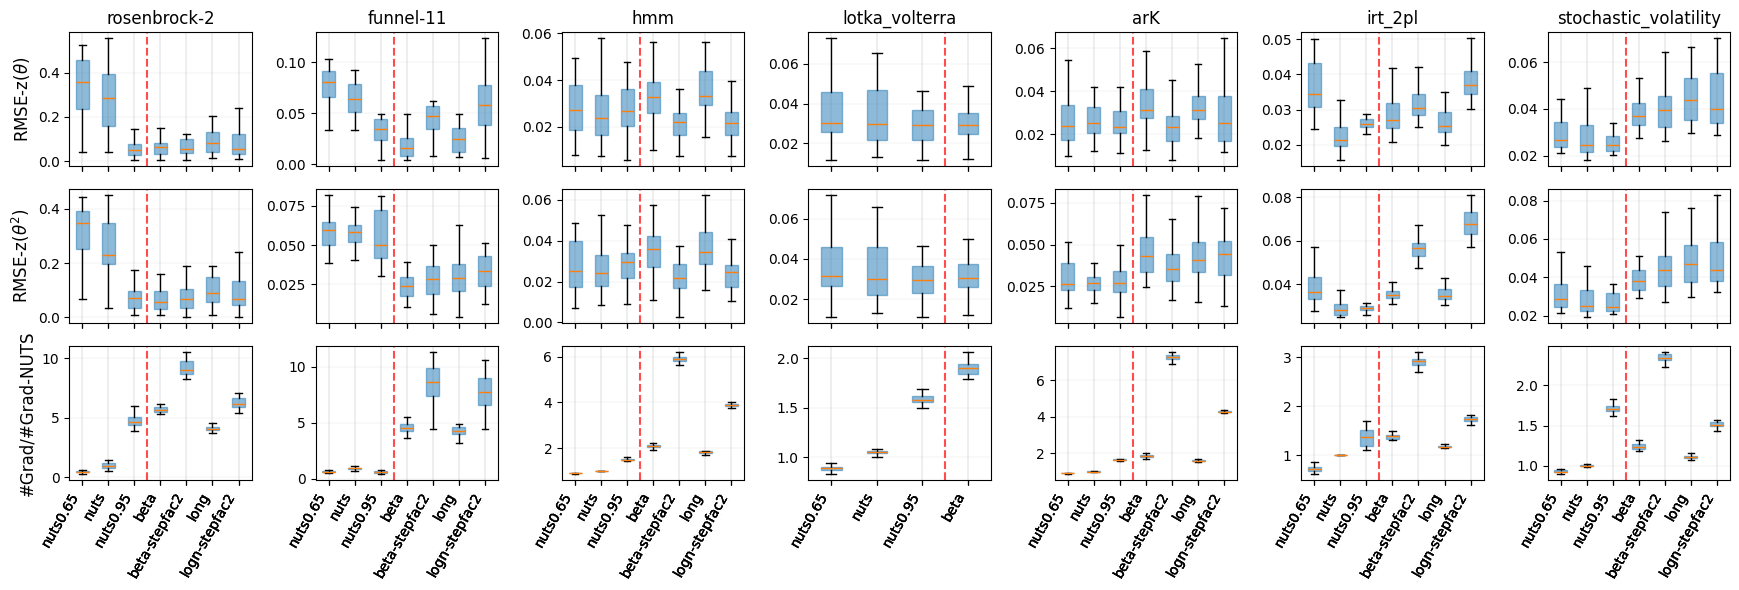

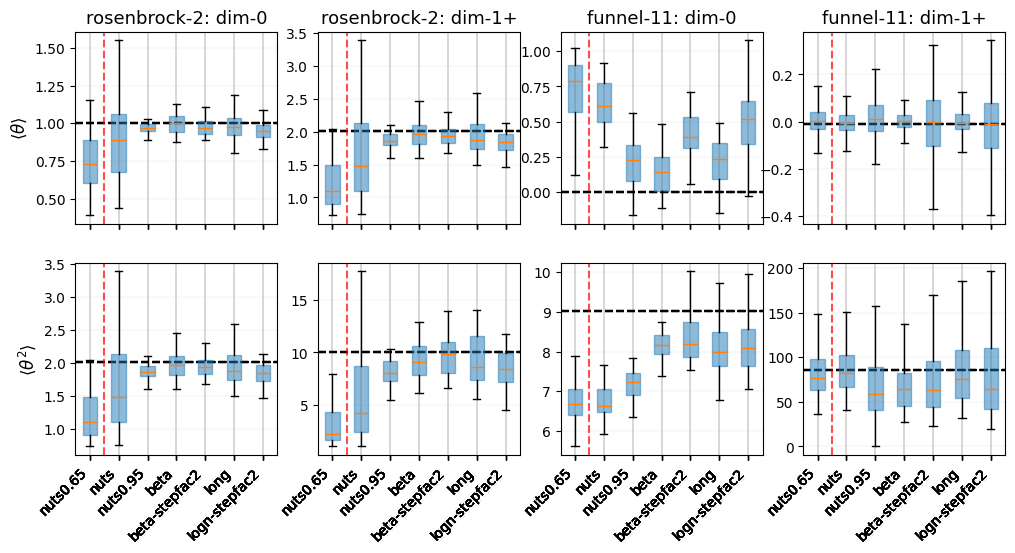

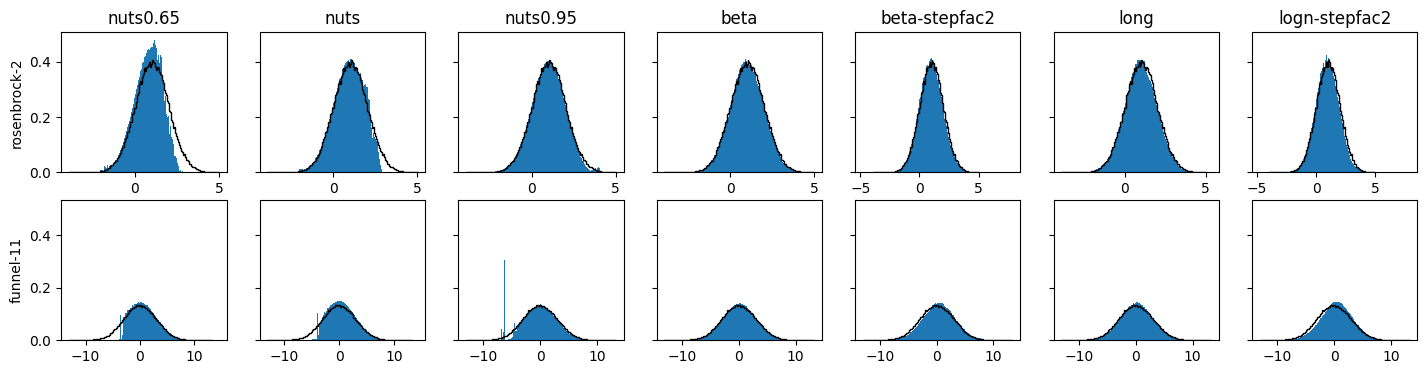

In [822]:
boxplot_experiments(alldata, baselines=3)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

# compare 2k vs 20k samples

In [129]:
nchains = 16
alldata2 = {}

# for exp in ["rosenbrock-2",  "funnel-11", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11"]:
    
    data = {}
    if exp == 'funnel-11' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//{exp}/samples.npy')
    if 'funnel2' in exp: ref = np.concatenate([np.repeat(ref[:, 0:1], int(exp.split('-')[1])/10, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/10*9, axis=1)], axis=1)
    elif 'funnel' in exp: ref = np.concatenate([ref[:, 0:1], np.repeat(ref[:, 1:2], int(exp.split('-')[1])-1, axis=1)], axis=1)
    elif 'rosenbrock' in exp: ref = np.concatenate([ np.repeat(ref[:, 0:1], int(exp.split('-')[1])/2, axis=1), np.repeat(ref[:, 1:2], int(exp.split('-')[1])/2, axis=1)], axis=1)
    data['ref'] = ref
    
    ta = 0.8
    snuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/samples.npy')[:nchains, :nsamples]
    gnuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/leapfrogs.npy')[:nchains, :nsamples]
    count, err1 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
    count, err2 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
    data['nuts'] = [count, err1, err2, snuts]

    for ta in [0.95]:
        snuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
        count, err2 = dg.cumulative_rmse_per_chain(snuts, counts=gnuts, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
        data[f'nuts{ta:0.2f}'] = [count, err1, err2, snuts]
        

    algfolder = 'atlas-nuts' 
    for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal']: 
        # for offset in [0.33, 0.5, 0.66, 1.0]:
        for offset in [1.0]:
            key = f"off{offset:0.2f}{suffix}"
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            data = get_data(path, key, data)

            
    algfolder = 'atlas-nuts-indep' 
    for suffix in [ '-prob1-ctraj1', '-prob1-ctraj1-lognormal']: #,  '-prob1-ctraj1-stepfac2', '-prob1-ctraj1-lognormal-stepfac2']: 
        for offset in [1.0]:
            key = f"off{offset:0.2f}{suffix}-indep"
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            print(key, path)
            data = get_data(path, key, data)

            
    algfolder = 'atlas-uturn' 
    for offd in [ 1.0]:
        for suffix in [ '-prob1', '-prob1-lognormal']: 
            for offset in [ 1.0]:
                key = f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
                if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
                else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
                print(key, path)
                data = get_data(path, key, data)
    alldata2[exp] = data

    
    
# nexps = len(alldata.keys())
# allkeys = list(data.keys())

off1.00-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-nuts/offset1.00-prob1-ctraj1/
off1.00-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-nuts/offset1.00-prob1-ctraj1-lognormal/
off1.00-prob1-ctraj1-indep /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-nuts-indep/offset1.00-prob1-ctraj1/
off1.00-prob1-ctraj1-lognormal-indep /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-nuts-indep/offset1.00-prob1-ctraj1-lognormal/
ut-off1.00-offd1.00-prob1 /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-prob1/
ut-off1.00-offd1.00-prob1-lognormal /mnt/ceph/users/cmodi/atlassampler/rosenbrock-2//atlas-uturn/offset1.00-prob1-lognormal/
off1.00-prob1-ctraj1 /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset1.00-prob1-ctraj1/
off1.00-prob1-ctraj1-lognormal /mnt/ceph/users/cmodi/atlassampler/funnel-11//atlas-nuts/offset1.00-prob1-ctraj1-lognormal/
off1.00-prob1-ctraj1-indep /mnt/ceph/users/cmodi/atlassa

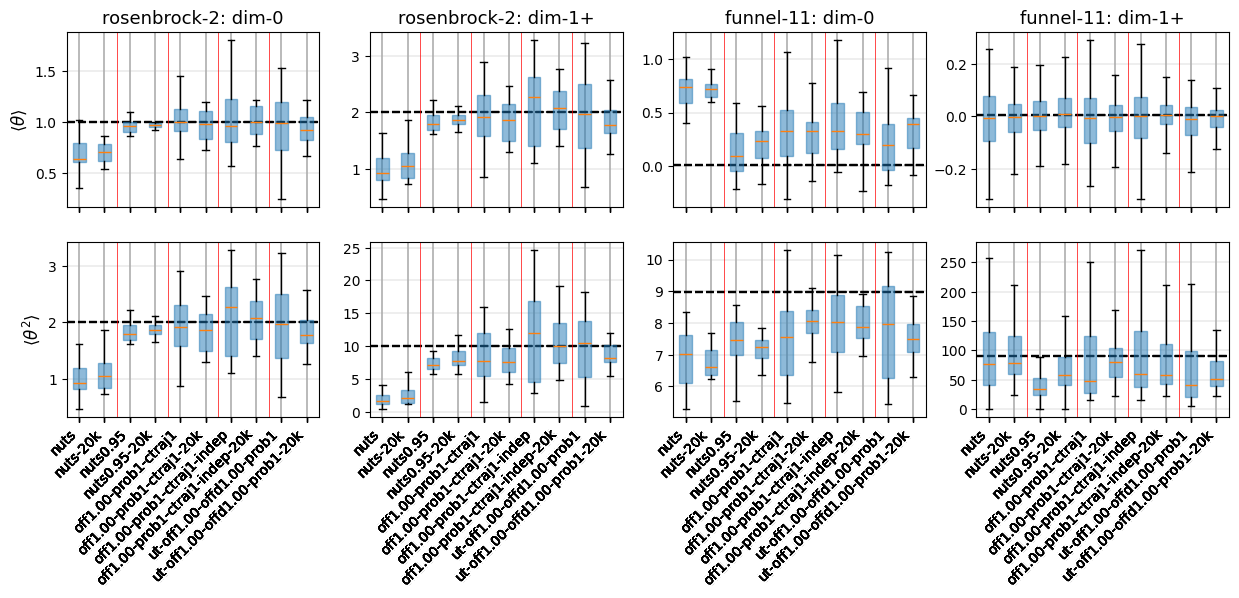

In [195]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5), sharex=True)
fliers=False

for i in range(2):
    for j in range(2):
        exp = ['rosenbrock-2', 'funnel-11'][i]
        data = alldata[exp]
        data2 = alldata2[exp]
        refs = reference_samples[exp]

        toplot, toplot2, lbls = [], [], []
        for key in data.keys():
            if key == 'ref': continue
            if 'lognormal' in key: continue
            if j == 0:
                toplot.append(data[key][-1].mean(axis=1)[:, 0].flatten())
                toplot2.append((data[key][-1]**2).mean(axis=1)[:, 0].flatten())
                toplot.append(data2[key][-1].mean(axis=1)[:, 0].flatten())
                toplot2.append((data2[key][-1]**2).mean(axis=1)[:, 0].flatten())
                ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
                ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
                ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)

            if j == 1:
                toplot.append(data[key][-1].mean(axis=1)[:, 1:].flatten())
                toplot2.append((data[key][-1]**2).mean(axis=1)[:, 1:].flatten())
                toplot.append(data2[key][-1].mean(axis=1)[:, 1:].flatten())
                toplot2.append((data2[key][-1]**2).mean(axis=1)[:, 1:].flatten())
                ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
                ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
                ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
            lbls.append(key)
            lbls.append(key + '-20k')

        ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
        ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
                    boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);

for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

for axis in ax.flatten():
    for j in range(1, len(toplot)//2):
        axis.axvline(2*j+0.5, color='r', lw=0.5)
        
ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
for axis in ax.flatten():
    axis.grid(which='both', lw=0.3)


In [142]:
data[key][-1].shape, data2[key][-1].shape

((16, 4999, 11), (16, 19999, 11))

In [185]:
(data['nuts'][-1][..., 0].std(axis=-1))
# (data['nuts'][-1][..., 0].std(axis=-1) < 1e-8).sum()

array([0.89055971, 0.76643983, 0.75452805, 0.67981418, 0.76589449,
       0.66919458, 0.744062  , 0.76076039, 0.66215187, 0.77373693,
       0.58952672, 0.70283228, 0.65554701, 0.75683014, 0.65314148,
       0.75311865])

# debug

rosenbrock-2
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 11 "raise"): No active exception to reraise
EXCEPTION IN (/tmp/ipykernel_3522325/1673655619.py, LINE 22 "suturn = np.stack

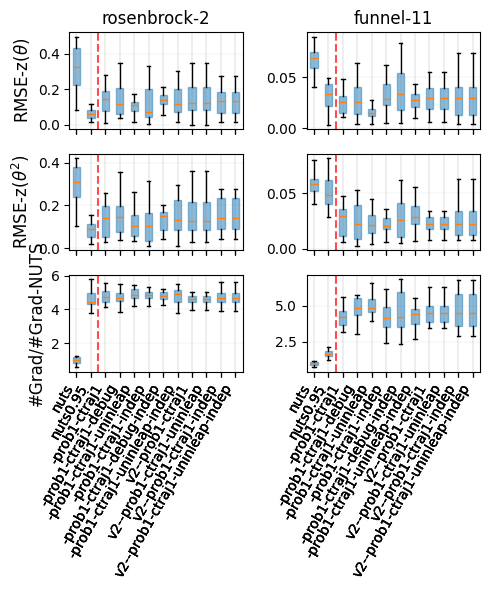

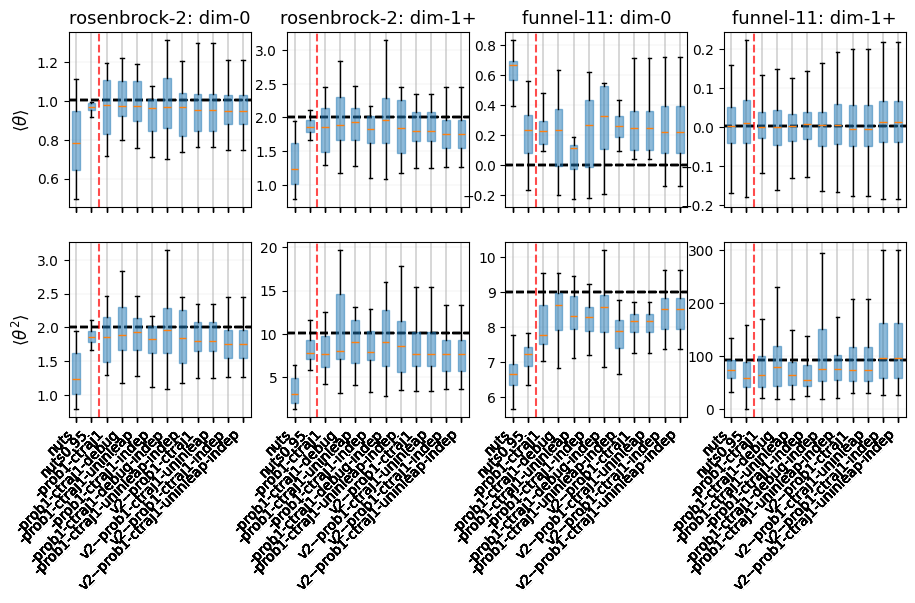

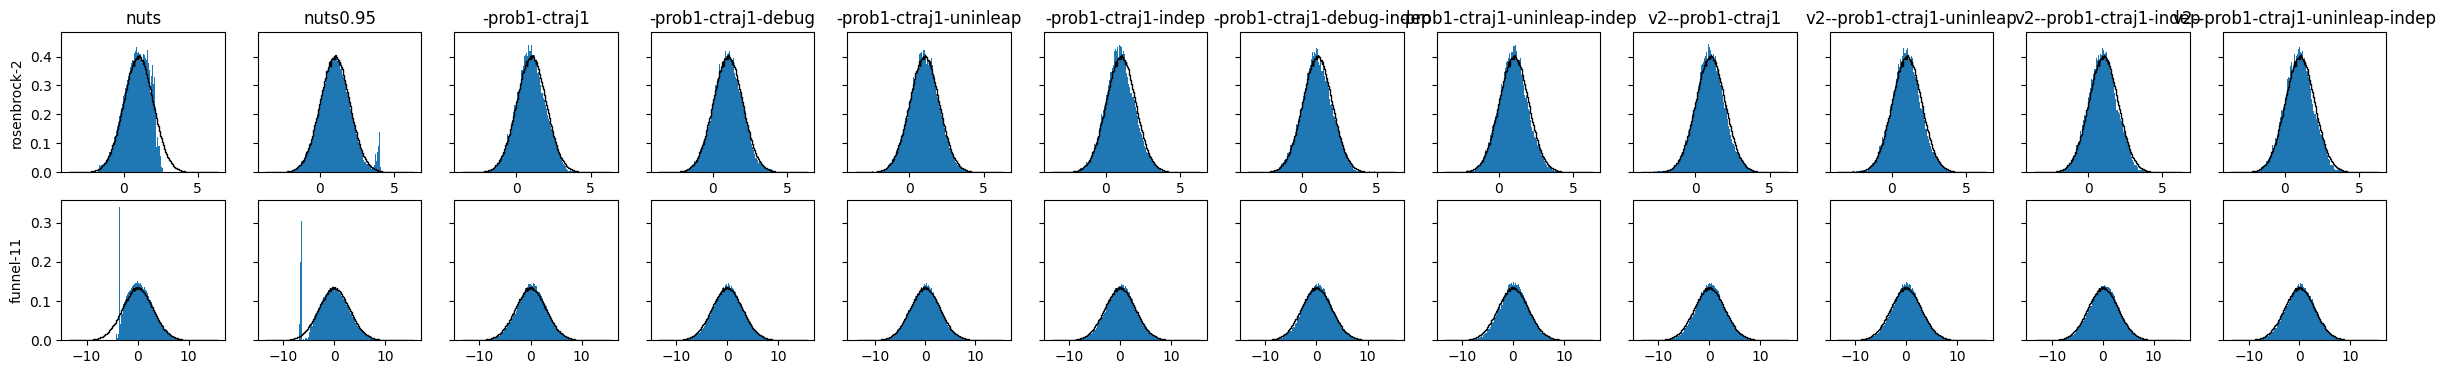

In [23]:
nchains = 16
alldata = {}

# for exp in ["rosenbrock-2",  "funnel-11", "funnel-51", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
for exp in ["rosenbrock-2",  "funnel-11"]:
# for exp in ["corr_normal90-100",  "corr_normal95-100",   "ill_normal-100"]:
# for exp in [  "funnel-51"]:
    
    print(exp)
    data = {}
    if exp == 'funnel-11' or exp == 'funnel-51' or exp == 'rosenbrock-2':
        nsamples = 19999
    else: nsamples = 1999 

    ref = reference_samples[exp]
    data['ref'] = ref
    
    for ta in [0.8, 0.95]:
        nutspath = f'/mnt/ceph/users/cmodi/atlassampler//{exp}/nuts/target{ta:0.2f}/'
        snuts = np.load(f'{nutspath}/samples.npy')[:nchains, :nsamples]
        gnuts = np.load(f'{nutspath}/leapfrogs.npy')[:nchains, :nsamples]
        count, err1, err2 = load_rmse(nutspath, snuts, gnuts, ref, nsamples)
        key = f'nuts{ta:0.2f}'
        if ta == 0.8: key = 'nuts'
        data[key] = [count, err1, err2, snuts]        
        

    suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-debug', '-prob1-ctraj1-uninleap']
    # suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-debug', '-prob1-ctraj1-test', '-prob1-ctraj1-atlasv2']
    # suffixes = [ '-prob1-ctraj1', '-prob1-ctraj1-debug', '-prob1-ctraj1-test', '-prob1-ctraj1-debug2']
    algfolder = 'atlas-nuts' 
    keys = ['allchains', 'allchains-debug']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = keys[i] #f"off{offset:0.2f}{suffix}"
            key = f"{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlas-nuts-indep' 
    keys = ['indep', 'indep-debug']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            key = f"{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

    algfolder = 'atlasv2-nuts' 
    keys = ['allchains', 'allchains-debug']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = keys[i] #f"off{offset:0.2f}{suffix}"
            key = f"v2-{suffix}"
            i +=1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)

            
    algfolder = 'atlasv2-nuts-indep' 
    keys = ['indep', 'indep-debug']
    i = 0 
    for suffix in suffixes: 
        for offset in [1.0]:
            # key = keys[i] #f"off{offset:0.2f}{suffix}-indep"
            key = f"v2-{suffix}-indep"
            i += 1
            path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
            data = get_data(path, key, data, nsamples)
    
            
    # algfolder = 'atlas-uturn' 
    # keys = ['atlas-uturn']
    # i = 0 
    # for offd in [ 1.0]:
    #     for suffix in [ '-prob1']: 
    #         for offset in [ 1.0]:
    #             key = keys[i] #f"ut-off{offset:0.2f}-offd{offd:0.2f}{suffix}"
    #             i += 1
    #             if offd == 1: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}{suffix}/'
    #             else: path = f'/mnt/ceph/users/cmodi/atlassampler/{exp}//{algfolder}/offset{offset:0.2f}-offsetd{offd:0.2f}{suffix}/'
    #             data = get_data(path, key, data, nsamples)
   
    alldata[exp] = data

    
nexps = len(alldata.keys())
allkeys = list(data.keys())


boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

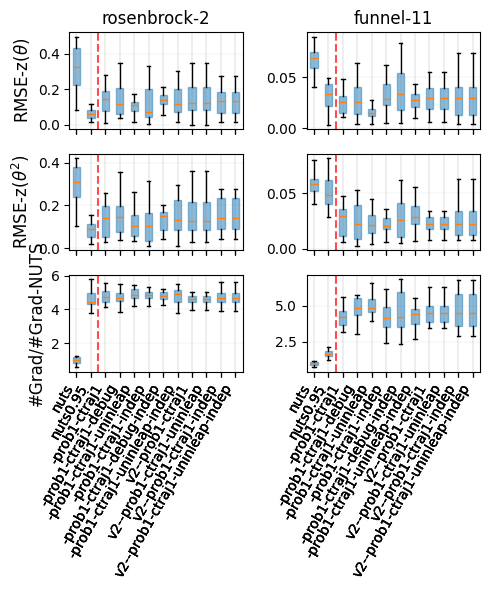

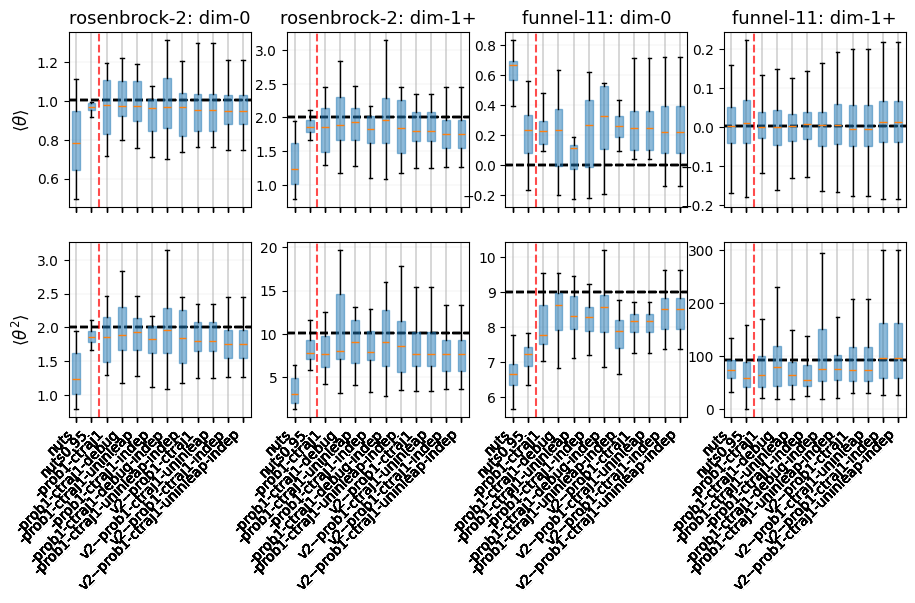

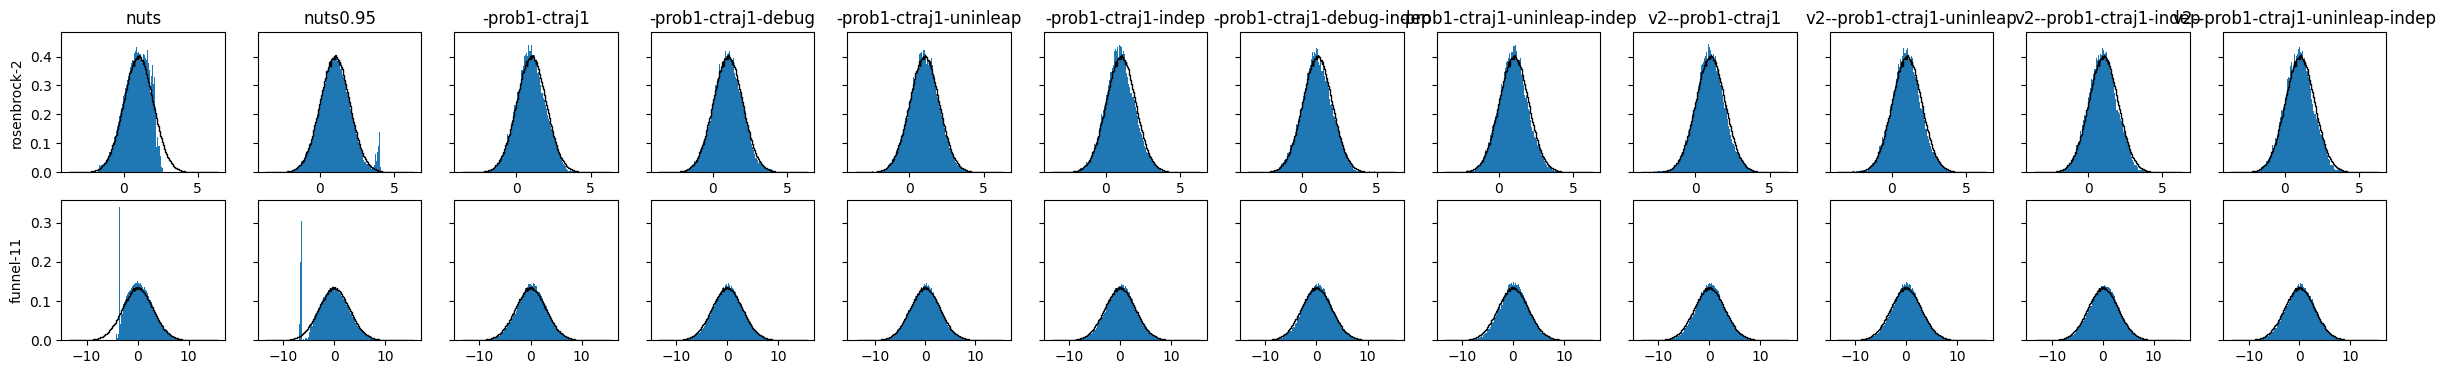

In [12]:
boxplot_experiments(alldata)
plt.show()
boxplot_funnel_rosenbrock(alldata)
plt.show()
histogram_funnel_rosenbrock(alldata)
plt.show()

In [267]:
# boxplot_experiments(alldata)
# plt.show()
# boxplot_funnel_rosenbrock(alldata)
# plt.show()
# histogram_funnel_rosenbrock(alldata)
# plt.show()

In [11]:
for dkey in alldata:
    print(dkey)
    for key in alldata[dkey]:
        print(alldata[dkey][key][-1].shape)

rosenbrock-2
(2,)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
(16, 19999, 2)
funnel-11
(11,)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)
(16, 19999, 11)


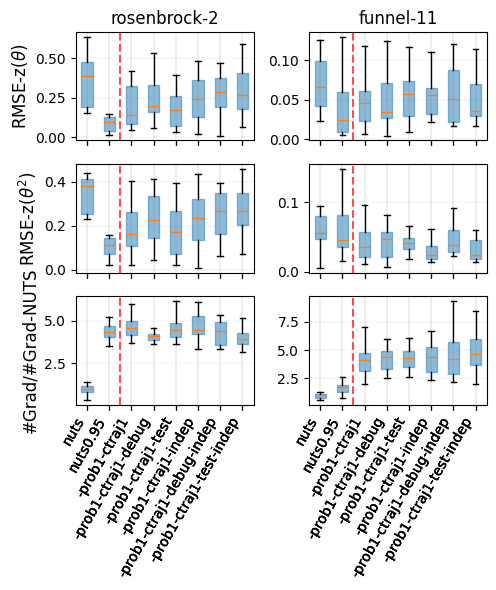

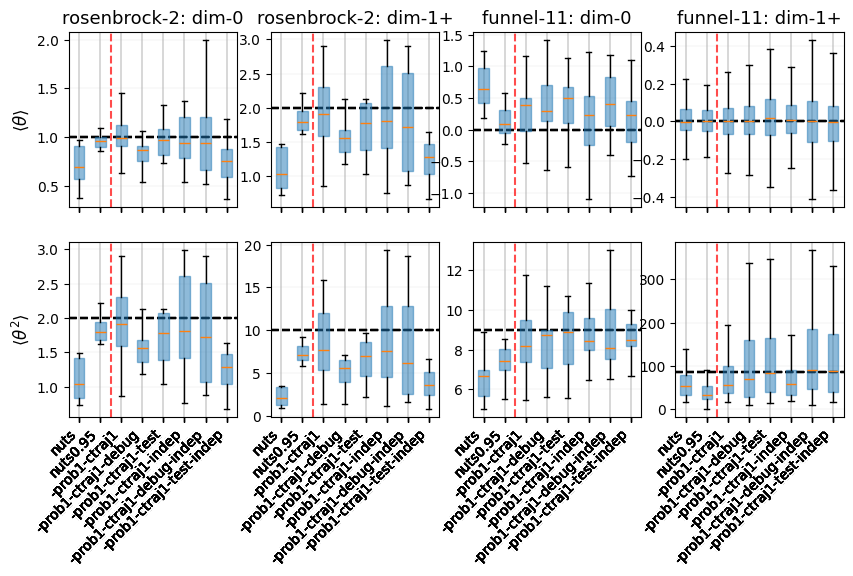

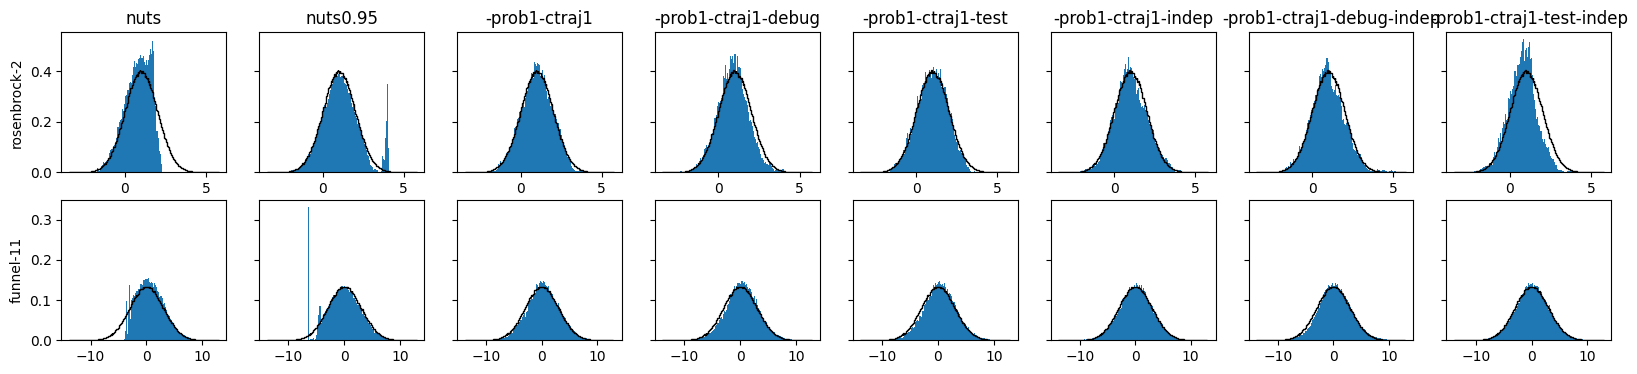

In [212]:
# boxplot_experiments(alldata)
# plt.show()
# boxplot_funnel_rosenbrock(alldata)
# plt.show()
# histogram_funnel_rosenbrock(alldata)
# plt.show()

# Scratchpad

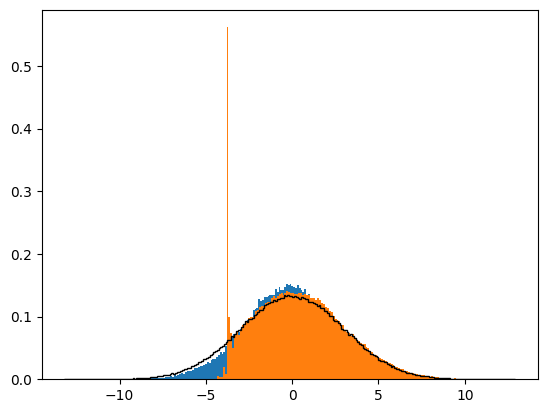

In [27]:
exp = 'funnel-51'
s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-51/atlas-nuts/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(16)])
# s2 = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-51/adaptive2re/offset1.00-ctraj1-prob1/samples_constrained-{i}.npy') for i in range(16)])
snuts = np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-51/nuts/target0.80/samples.npy')
# s2 = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-11/adaptive2/offset0.33-ctraj1-prob1/samples_constrained-{i}.npy') for i in range(16)])
plt.hist(reference_samples[exp][..., 0], density=True, color='k', lw=1, histtype='step', bins='auto')
plt.hist(s[..., 0].flatten(), density=True,  bins='auto')
# plt.hist(s2[..., 0].flatten(), density=True,  bins='auto', alpha=0.5)
plt.hist(snuts[..., 0].flatten(), density=True,  bins='auto')
# plt.hist(data2[key][-1][..., 0].flatten(), density=True,  bins='auto', alpha=0.7)
# plt.title(key)
plt.show()

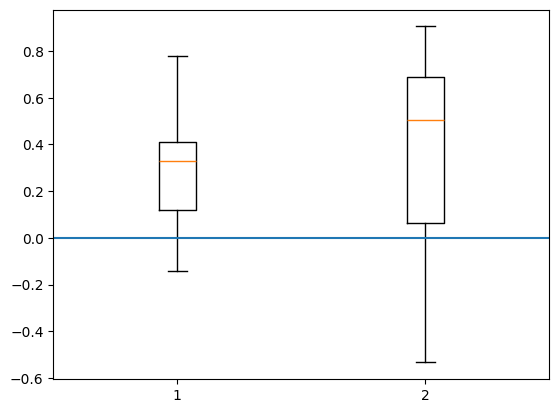

In [251]:
plt.boxplot([s[..., 0].mean(axis=1), s2[..., 0].mean(axis=1)]);
plt.axhline(0)
# plt.boxplot()

[]

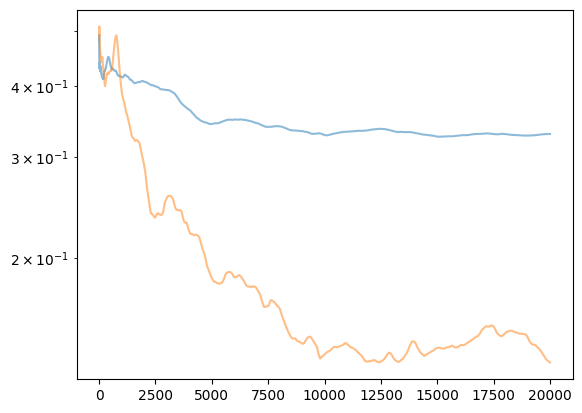

In [127]:
# plt.plot(alldata2['rosenbrock-2']['nuts'][1].T, 'C0', alpha=0.5);
# plt.plot(alldata2['rosenbrock-2']['off1.00-prob1-ctraj1'][1].T, 'C1', alpha=0.5);
# plt.loglog()
plt.plot(alldata2['rosenbrock-2']['nuts'][2].mean(axis=0), 'C0', alpha=0.5);
plt.plot(alldata2['rosenbrock-2']['off1.00-prob1-ctraj1'][2].mean(axis=0), 'C1', alpha=0.5);
# plt.plot(alldata2['rosenbrock-2']['nuts'][-1].mean(axis=0), 'C0', alpha=0.5);
# plt.plot(alldata2['rosenbrock-2']['off1.00-prob1-ctraj1'][1].mean(axis=0), 'C1', alpha=0.5);
# plt.loglog()
plt.semilogy()

In [45]:
sdr = np.load(f'/mnt/ceph/users/cmodi/hmc/outputs_long3/funnel/Ndim20/step020_nleap50_fac05_nsub3/samples.npy')


In [48]:
sdr[:20000, :16, 0].mean()

-0.015898667140735116

In [ ]:
# s4 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-hess5/samples_constrained-{i}.npy') for i in range(16)])
# s5 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-reduce1000/samples_constrained-{i}.npy') for i in range(16)])
# s6 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-hess5-reduce1000/samples_constrained-{i}.npy') for i in range(16)])
# s7 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-hess5-reduce1000-nleapmin5/samples_constrained-{i}.npy') for i in range(16)])
# s8 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-nleapmin5//samples_constrained-{i}.npy') for i in range(16)])
# s9 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlas-hmc/offset1.00//samples_constrained-{i}.npy') for i in range(16)])


In [736]:
# s = {}
# g = {}
# f = {}

# s[0] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/compare_stepadapt/target0.80-beta/samples_constrained-{i}.npy')[:50000] for i in range(32)])
# g[0] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/compare_stepadapt/target0.80-beta/gradcounts-{i}.npy')[:50000] for i in range(32)])
# # s[99] = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-11/adaptive2re/offset1.00-ctraj1-prob1/samples_constrained-{i}.npy') for i in range(16)])
# # g[99] = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-11/adaptive2re/offset1.00-ctraj1-prob1/gradcounts-{i}.npy') for i in range(16)])

# s[1] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy')[:50000] for i in range(32)])
# g[1] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1/gradcounts-{i}.npy')[:50000] for i in range(32)])

# s[2] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[3] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# # s[4] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# # s[5] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# #
# g[2] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# g[3] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# # g[4] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])
# # g[5] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])

# ## ctraj2
# s[6] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[7] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[8] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[9] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])

# # g[6] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2/gradcounts-{i}.npy') for i in range(32)])
# # g[7] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2/gradcounts-{i}.npy') for i in range(32)])
# # g[8] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])
# # g[9] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])



# ## lognormal
# s[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-lognormal/samples_constrained-{i}.npy') for i in range(32)])
# s[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])

# #ctraj 2
# s[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep//offset1.00-prob1-ctraj2-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])


# ## lognormal
# s[18] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[19] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap-lognormal/samples_constrained-{i}.npy') for i in range(32)])
# s[20] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[21] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])

# #ctraj 2
# s[22] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[23] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep//offset1.00-prob1-ctraj2-uninleap-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[24] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[25] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])


# ## atlasv3
# s[26] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[27] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[28] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[29] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])

# ## atlasv3
# s[30] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[31] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[32] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[33] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])

# # g[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj3/gradcounts-{i}.npy') for i in range(32)])
# # g[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj3/gradcounts-{i}.npy') for i in range(32)])
# # g[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj3-uninleap/gradcounts-{i}.npy') for i in range(32)])
# # g[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj3-uninleap/gradcounts-{i}.npy') for i in range(32)])


# # # s[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-nleap100/samples_constrained-{i}.npy') for i in range(32)])
# # s[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-nleap100/samples_constrained-{i}.npy') for i in range(32)])
# # # g[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-nleap100/gradcounts-{i}.npy') for i in range(32)])
# # g[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-nleap100/gradcounts-{i}.npy') for i in range(32)])

# # # s[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# # s[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# # # s[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# # s[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# # # g[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# # g[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2/gradcounts-{i}.npy') for i in range(32)])
# # g[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])
# # g[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])


# # ## V3
# # s[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# # g[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/gradcounts-{i}.npy') for i in range(32)])

# # s[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# # g[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])

# # # s[18] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-nleap100/samples_constrained-{i}.npy') for i in range(32)])

# # s[19] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# # g[19] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/gradcounts-{i}.npy') for i in range(32)])

# # s[20] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# # g[20] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])

# # s[21] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1-nleap100/samples_constrained-{i}.npy') for i in range(32)])
# # g[21] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-nleap100/gradcounts-{i}.npy') for i in range(32)])



In [61]:
s = {}
g = {}
f = {}


s['stepadapt'] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/dr_stepadapt-indep/target0.80/samples_constrained-{i}.npy')[:50000] for i in range(32)])
# g[0] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/compare_stepadapt/target0.80-beta/gradcounts-{i}.npy')[:50000] for i in range(32)])
# s[99] = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-11/adaptive2re/offset1.00-ctraj1-prob1/samples_constrained-{i}.npy') for i in range(16)])
# g[99] = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-11/adaptive2re/offset1.00-ctraj1-prob1/gradcounts-{i}.npy') for i in range(16)])

s['old'] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy')[:50000] for i in range(32)])
# g[1] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1/gradcounts-{i}.npy')[:50000] for i in range(32)])


# for folder in ['atlasv2-nuts', 'atlasv2-nuts-indep']:
for folder in ['atlasv2-nuts-indep']:
    for ct in ['-ctraj1', '-ctraj2']:
        for sdist in ['','-lognormal-stepsig1.2']:
            for ndist in ['','-uninleap']:
                # for t in ['', '-target0.65']:
                for t in ['']:
                    key = f"{folder}{ct}{ndist}{sdist}{t}"
                    print(key)
                    try:
                        s[key] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/{folder}/offset1.00-prob1{ct}{ndist}{sdist}{t}/samples_constrained-{i}.npy') for i in range(32)])
                    except:
                        PrintException()
# s[2] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[3] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# #

# ## ctraj2
# s[6] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[7] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[8] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[9] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])

# ## lognormal
# s[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-lognormal/samples_constrained-{i}.npy') for i in range(32)])
# s[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])

# #ctraj 2
# s[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep//offset1.00-prob1-ctraj2-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])


# ## lognormal
# s[18] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[19] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap-lognormal/samples_constrained-{i}.npy') for i in range(32)])
# s[20] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[21] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])

# #ctraj 2
# s[22] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[23] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep//offset1.00-prob1-ctraj2-uninleap-lognormal//samples_constrained-{i}.npy') for i in range(32)])
# s[24] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])
# s[25] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2//samples_constrained-{i}.npy') for i in range(32)])


# ## atlasv3
# s[26] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[27] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[28] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[29] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])

# ## atlasv3
# s[30] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[31] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# s[32] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[33] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])

# g[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj3/gradcounts-{i}.npy') for i in range(32)])
# g[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj3/gradcounts-{i}.npy') for i in range(32)])
# g[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj3-uninleap/gradcounts-{i}.npy') for i in range(32)])
# g[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj3-uninleap/gradcounts-{i}.npy') for i in range(32)])


# # s[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-nleap100/samples_constrained-{i}.npy') for i in range(32)])
# s[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-nleap100/samples_constrained-{i}.npy') for i in range(32)])
# # g[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-nleap100/gradcounts-{i}.npy') for i in range(32)])
# g[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-nleap100/gradcounts-{i}.npy') for i in range(32)])

# # s[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# s[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2/samples_constrained-{i}.npy') for i in range(32)])
# # s[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# s[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# # g[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# g[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2/gradcounts-{i}.npy') for i in range(32)])
# g[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])
# g[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])


# ## V3
# s[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# g[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/gradcounts-{i}.npy') for i in range(32)])

# s[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# g[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])

# # s[18] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-nleap100/samples_constrained-{i}.npy') for i in range(32)])

# s[19] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1/samples_constrained-{i}.npy') for i in range(32)])
# g[19] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/gradcounts-{i}.npy') for i in range(32)])

# s[20] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1-uninleap/samples_constrained-{i}.npy') for i in range(32)])
# g[20] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])

# s[21] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1-nleap100/samples_constrained-{i}.npy') for i in range(32)])
# g[21] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1-nleap100/gradcounts-{i}.npy') for i in range(32)])



atlasv2-nuts-indep-ctraj1
atlasv2-nuts-indep-ctraj1-uninleap
atlasv2-nuts-indep-ctraj1-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj1-uninleap-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj2
atlasv2-nuts-indep-ctraj2-uninleap
atlasv2-nuts-indep-ctraj2-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj2-uninleap-lognormal-stepsig1.2


atlasv2-nuts-indep-ctraj1
atlasv2-nuts-indep-ctraj1-uninleap
atlasv2-nuts-indep-ctraj1-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj1-uninleap-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj2
atlasv2-nuts-indep-ctraj2-uninleap
atlasv2-nuts-indep-ctraj2-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj2-uninleap-lognormal-stepsig1.2
8 8
['atlasv2-nuts-indep-ctraj1', 'atlasv2-nuts-indep-ctraj1-uninleap', 'atlasv2-nuts-indep-ctraj1-lognormal-stepsig1.2', 'atlasv2-nuts-indep-ctraj1-uninleap-lognormal-stepsig1.2', 'atlasv2-nuts-indep-ctraj2', 'atlasv2-nuts-indep-ctraj2-uninleap', 'atlasv2-nuts-indep-ctraj2-lognormal-stepsig1.2', 'atlasv2-nuts-indep-ctraj2-uninleap-lognormal-stepsig1.2']
atlasv2-nuts-indep-ctraj1
atlasv2-nuts-indep-ctraj1-uninleap
atlasv2-nuts-indep-ctraj1-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj1-uninleap-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj2
atlasv2-nuts-indep-ctraj2-uninleap
atlasv2-nuts-indep-ctraj2-lognormal-stepsig1.2
atlasv2-nuts-indep-ctraj2-uninleap-lognorma

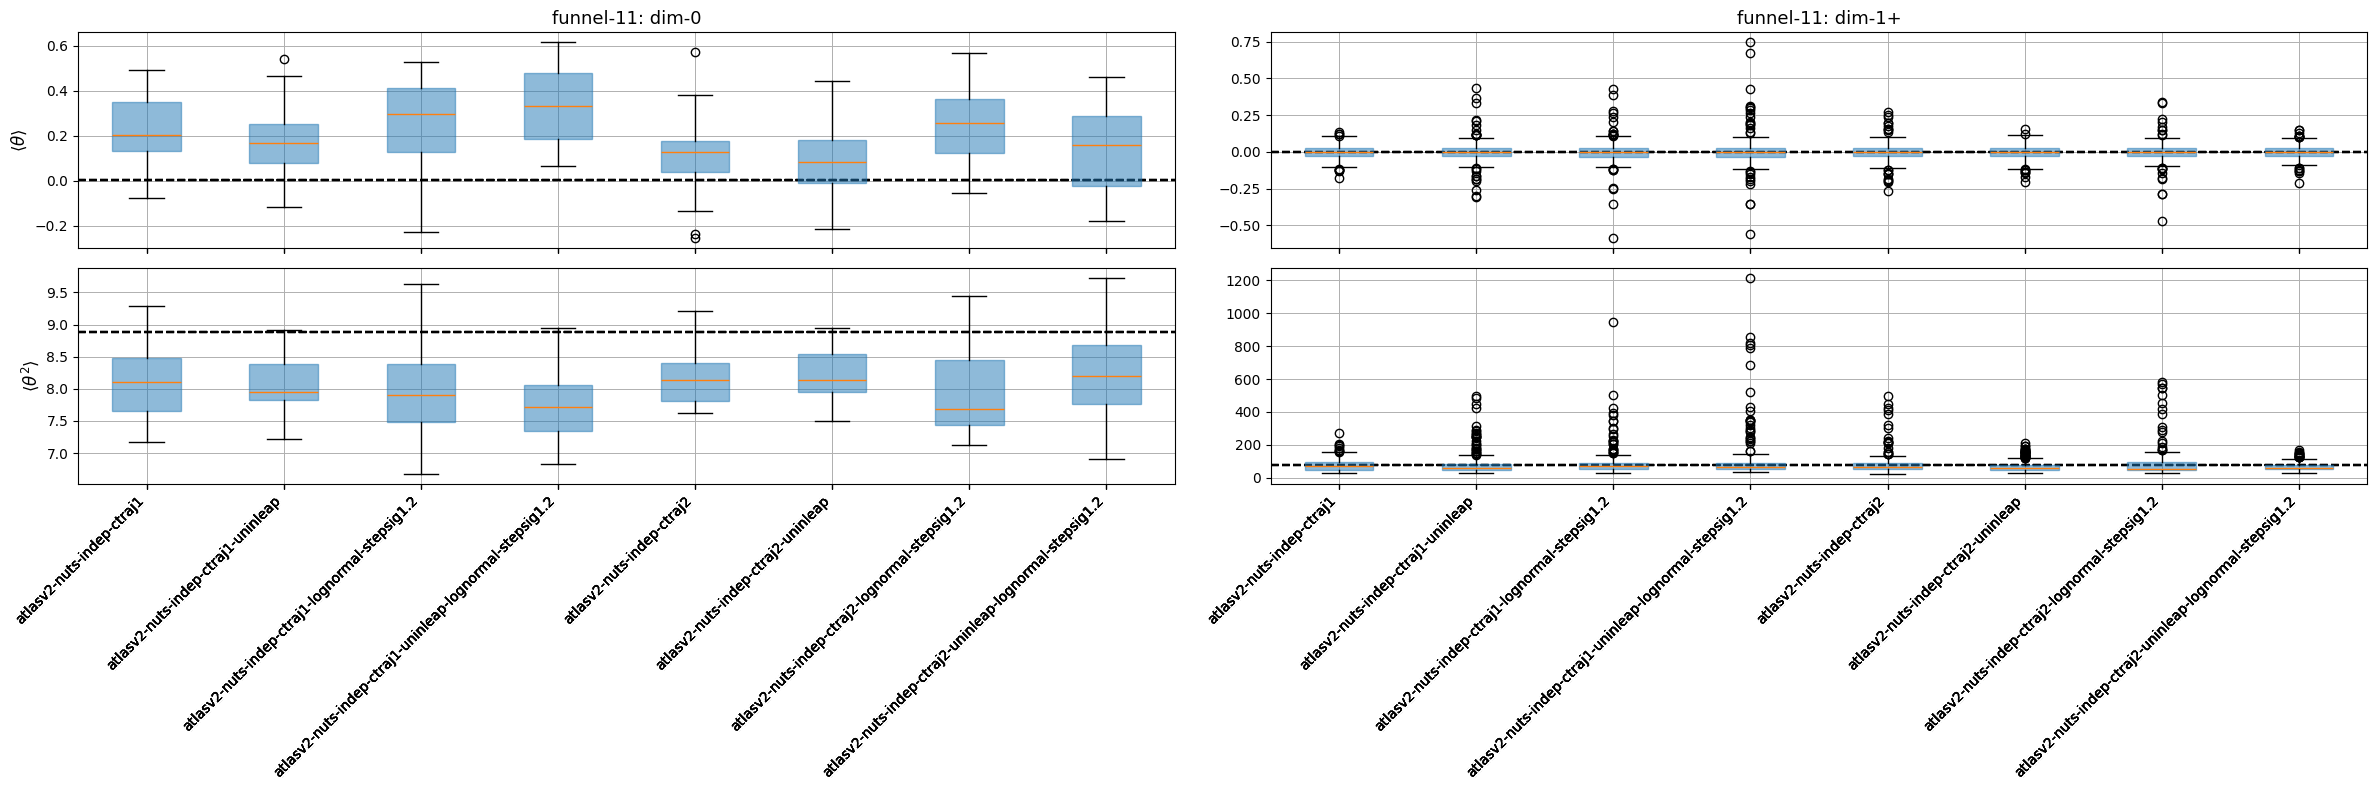

In [62]:
exp = 'funnel-11'
# exp = 'rosenbrock-2'
fig, ax = plt.subplots(2, 2, figsize=(24, 8), sharex=True)
fliers=True
i = 0 
for j in range(2):
    data = s
    refs = reference_samples[exp]

    toplot, toplot2, lbls = [], [], []
    for key in s.keys():
        if key == 'ref': continue
        # if 'lognormal-stepsig1.2'  in key: pass
        if 'lognormal'  in key: 
            if 'stepsig' in key: pass
            else: continue
        if 'ctraj3' in key: continue
        if 'indep' not in key: continue
        # if 'uninleap' in key: continue
        if 'target0.65' in key: continue
        print(key)
        lbls.append(key)
        if j == 0:
            toplot.append(s[key].mean(axis=1)[:, 0].flatten())
            toplot2.append((s[key]**2).mean(axis=1)[:, 0].flatten())
            ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
            ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
            ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)

        if j == 1:
            toplot.append(s[key].mean(axis=1)[:, 1:].flatten())
            toplot2.append((s[key]**2).mean(axis=1)[:, 1:].flatten())
            ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
            ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
            ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
        # if 'dist' not in key: ikey += 1 

    print(len(lbls), len(toplot))
    print(lbls)
    ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
    ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);


for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
for axis in ax.flatten():
    axis.grid(which='both', lw=0.7)
    # axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

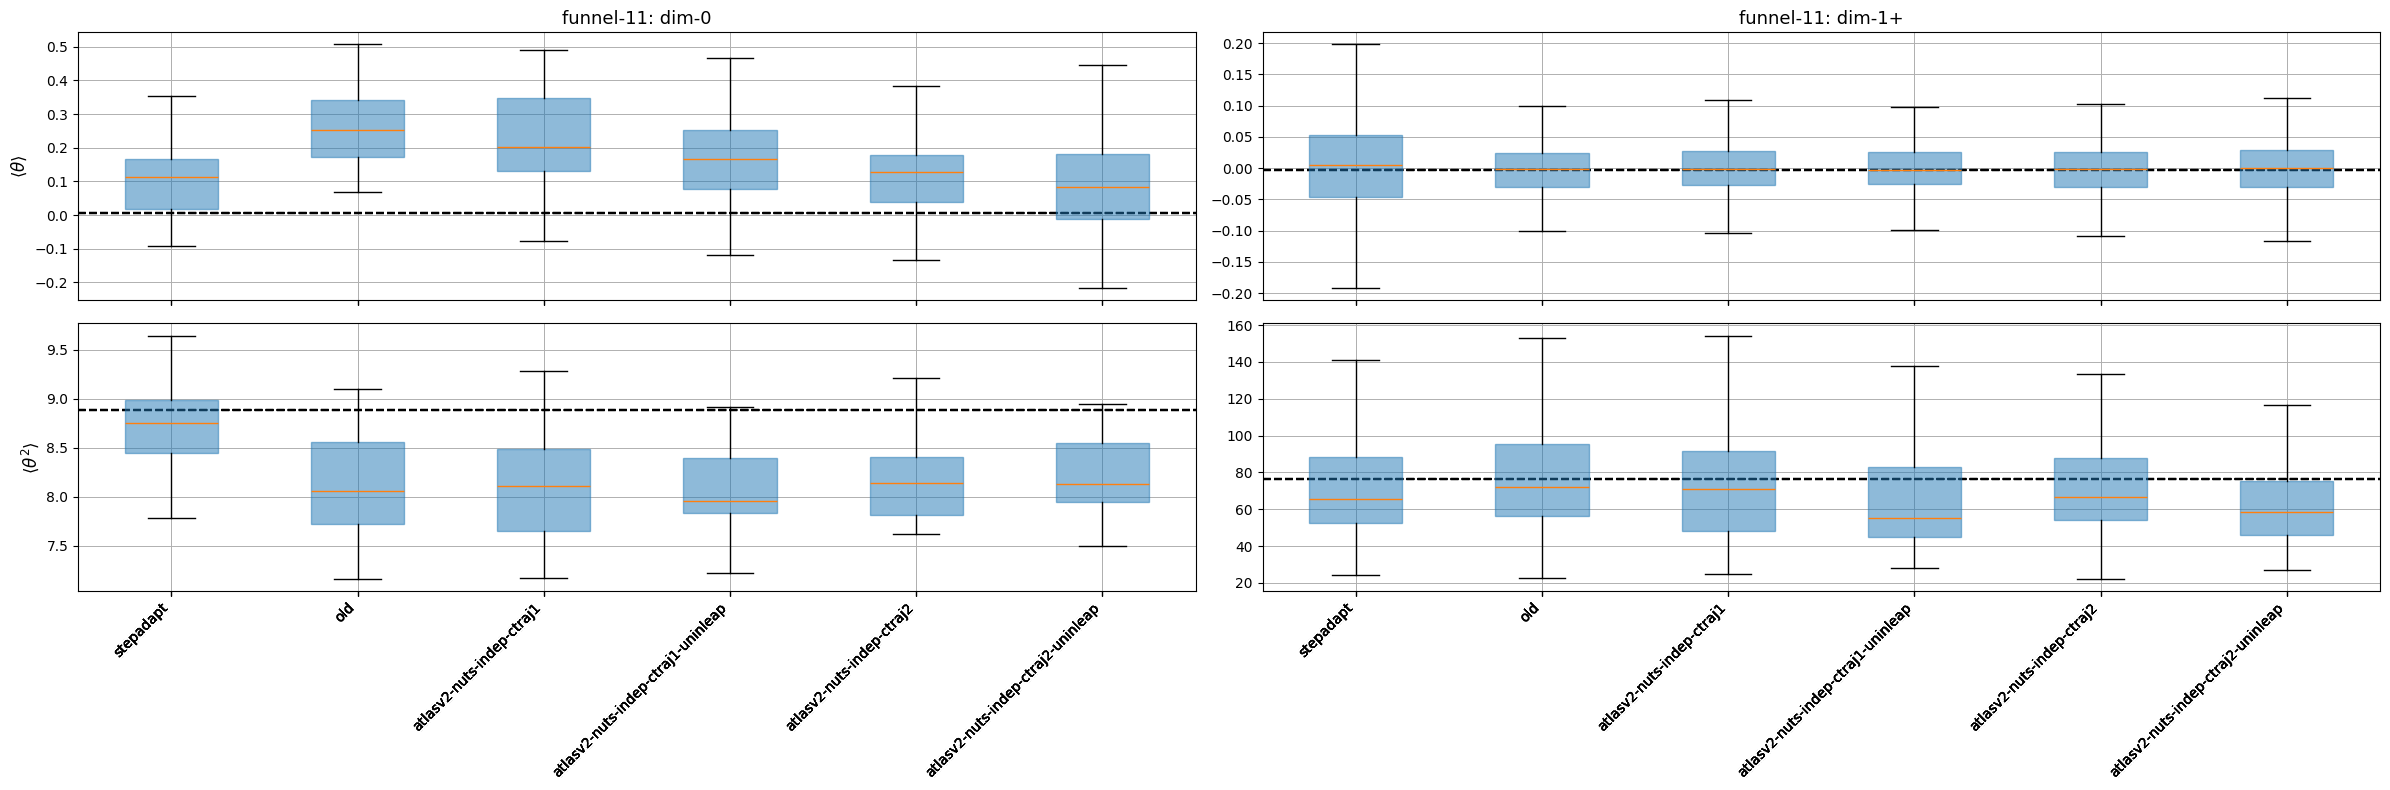

In [63]:
exp = 'funnel-11'
# exp = 'rosenbrock-2'
fig, ax = plt.subplots(2, 2, figsize=(24, 8), sharex=True)
fliers=False
i = 0 
for j in range(2):
    data = s
    refs = reference_samples[exp]

    toplot, toplot2, lbls = [], [], []
    for key in s.keys():
        if key == 'ref': continue
        if 'lognormal'  in key: continue
        if j == 0:
            toplot.append(s[key].mean(axis=1)[:, 0].flatten())
            toplot2.append((s[key]**2).mean(axis=1)[:, 0].flatten())
            ax[0, 2*i+j].axhline(refs[..., 0].mean(), color='k', ls="--");
            ax[1, 2*i+j].axhline((refs[..., 0]**2).mean(), color='k', ls="--");
            ax[0, 2*i+j].set_title(exp + ': dim-0', fontsize=13)

        if j == 1:
            toplot.append(s[key].mean(axis=1)[:, 1:].flatten())
            toplot2.append((s[key]**2).mean(axis=1)[:, 1:].flatten())
            ax[0, 2*i+j].axhline(refs[..., 1:].mean(), color='k', ls="--");
            ax[1, 2*i+j].axhline((refs[..., 1:]**2).mean(), color='k', ls="--");
            ax[0, 2*i+j].set_title(exp + ': dim-1+', fontsize=13)
        lbls.append(key)
        # if 'dist' not in key: ikey += 1 

    ax[0, 2*i+j].boxplot(toplot, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);
    ax[1, 2*i+j].boxplot(toplot2, patch_artist=True,
                boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, showfliers=fliers);


for axis in ax[-1]:
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=45, ha='right')

ax[0, 0].set_ylabel(r'$\langle \theta \rangle $', fontsize=12)
ax[1, 0].set_ylabel(r'$\langle \theta^2 \rangle $', fontsize=12)
for axis in ax.flatten():
    axis.grid(which='both', lw=0.7)
    # axis.axvline(baselines+0.5, color='r', ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

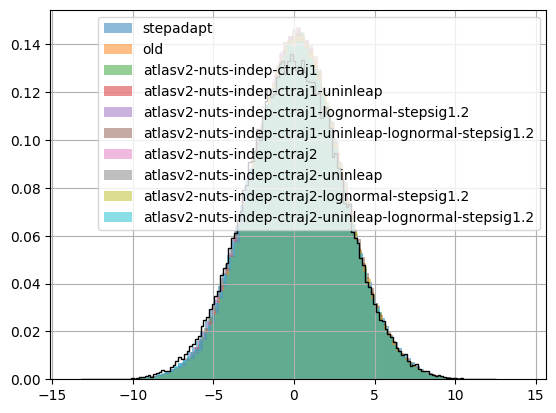

In [65]:
plt.hist(reference_samples['funnel-11'][..., 0], density=True, color='k', lw=1, histtype='step', bins='auto')
# plt.hist(reference_samples['rosenbrock-2'][..., 0], density=True, color='k', lw=1, histtype='step', bins='auto')

for key in s:    
    plt.hist(s[key][..., 0].flatten(), density=True,  bins=100, alpha=0.5, label=key)
# # plt.title(key)
plt.legend()
plt.grid()
plt.show()


In [66]:
print('shape')
for key in s:
    print(key, "\t", s[key][..., :, 0].shape, "\t%0.3f\t%0.3f"%(s[key][..., :, 0].mean(), s[key][..., :, 0].std()))

    

shape
stepadapt 	 (32, 50000) 	0.105	2.954
old 	 (32, 50000) 	0.239	2.837
atlasv2-nuts-indep-ctraj1 	 (32, 50001) 	0.220	2.840
atlasv2-nuts-indep-ctraj1-uninleap 	 (32, 50001) 	0.175	2.828
atlasv2-nuts-indep-ctraj1-lognormal-stepsig1.2 	 (32, 50001) 	0.249	2.809
atlasv2-nuts-indep-ctraj1-uninleap-lognormal-stepsig1.2 	 (32, 50001) 	0.334	2.765
atlasv2-nuts-indep-ctraj2 	 (32, 50001) 	0.117	2.859
atlasv2-nuts-indep-ctraj2-uninleap 	 (32, 50001) 	0.100	2.867
atlasv2-nuts-indep-ctraj2-lognormal-stepsig1.2 	 (32, 50001) 	0.253	2.802
atlasv2-nuts-indep-ctraj2-uninleap-lognormal-stepsig1.2 	 (32, 50001) 	0.142	2.864


In [67]:
# for key in g:
#     try: print(key, "\t", s[key][..., :, 0].shape, "\t%0.3f\t%0.3f"%(s[key][..., :, 0].mean(), s[key][..., :, 0].std()), "\t", g[key].sum()/g[1].sum())
#     except: print(key, "\t", g[key].shape, "\t", g[key].sum()/g[1].sum())

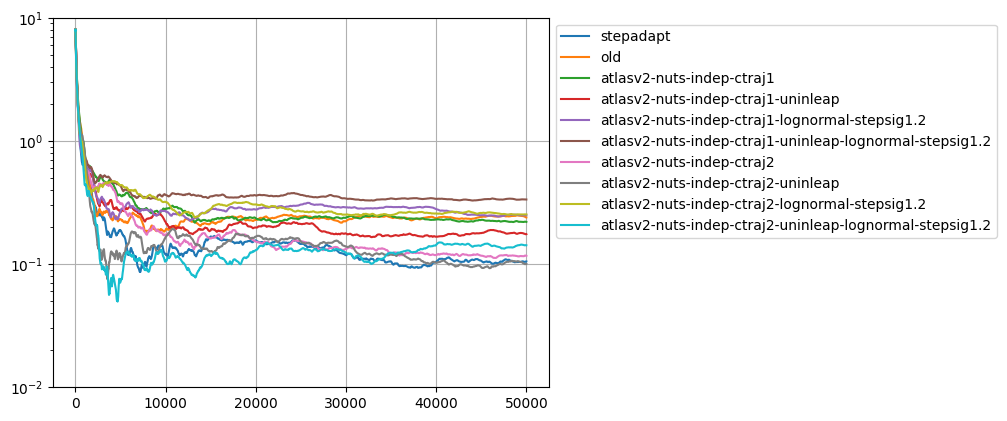

In [68]:
for key in s:
    ls = '-'
    # if key > 8: ls = '--'
    plt.plot(np.cumsum(s[key][..., 0].mean(axis=0))/np.arange(1, s[key].shape[1]+1), label=key, ls=ls)
# plt.loglog()
# plt.semilogx()
plt.semilogy()
plt.grid()
plt.ylim(0.01, 10)
plt.legend(bbox_to_anchor=(1,1))

In [ ]:
for key in s:
    ls = '-'
    if key > 8: ls = '--'
    plt.plot(np.cumsum( (s[key][..., 0]**2).mean(axis=0) )/np.arange(1, s[key].shape[1]+1), label=key, ls=ls)
# plt.loglog()
# plt.semilogx()
plt.semilogy()
plt.grid()
plt.ylim(6, 12)
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(9, color='k', lw=0.5)

In [641]:
# exp = 'funnel-11'

# g = {}
# g[0] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/compare_stepadapt/target0.80-beta/gradcounts-{i}.npy')[:50000] for i in range(32)])
# # g[99] = np.stack([np.load(f'/mnt/ceph/users/cmodi/adaptive_hmc//funnel-11/adaptive2re/offset1.00-ctraj1-prob1/gradcounts-{i}.npy') for i in range(16)])
# g[1] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1/gradcounts-{i}.npy')[:50000] for i in range(32)])
# g[2] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# g[3] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# g[4] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2/gradcounts-{i}.npy') for i in range(32)])
# g[5] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2/gradcounts-{i}.npy') for i in range(32)])

# g[6] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])
# g[7] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])
# g[8] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])
# g[9] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])

# g[10] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1-nleap100/gradcounts-{i}.npy') for i in range(32)])
# g[11] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj2-nleap100/gradcounts-{i}.npy') for i in range(32)])
# # g[12] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# # g[13] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2/gradcounts-{i}.npy') for i in range(32)])
# # g[14] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj1-uninleap/gradcounts-{i}.npy') for i in range(32)])
# # g[15] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv2-nuts/offset1.00-prob2-ctraj2-uninleap/gradcounts-{i}.npy') for i in range(32)])
# g[16] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts/offset1.00-ctraj1/gradcounts-{i}.npy') for i in range(32)])
# g[17] = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler///funnel-11/atlasv3-nuts-indep/offset1.00-ctraj1/gradcounts-{i}.npy') for i in range(32)])



In [ ]:
relative1 = 'scatter'
relative2 = 'scatter'
nevals = None
nchains = 32
ref = reference_samples['funnel-11']

boxgrads, boxerror, boxerror2, lbls = [], [], [], []
errs, errs2 = [], []
for key in s.keys():
    try:
        samples, grads = s[key], g[key]
        count, err1 = dg.cumulative_rmse_per_chain(samples, counts=grads, ref_samples=ref, mode=1, relative=relative1, nevals=nevals)
        count, err2 = dg.cumulative_rmse_per_chain(samples, counts=grads, ref_samples=ref, mode=2, relative=relative2, nevals=nevals)
        errs.append(err1)
        errs2.append(err2)
        nutsgrads = g[1][:, -1].mean(axis=0)
        boxgrads.append(count[:, -1]/nutsgrads)
        boxerror.append(err1[:, -1])
        boxerror2.append(err2[:, -1])
        lbls.append(key)
    except Exception as e:
        print(e)

In [606]:
len(boxerror), len(lbls)

(10, 10)

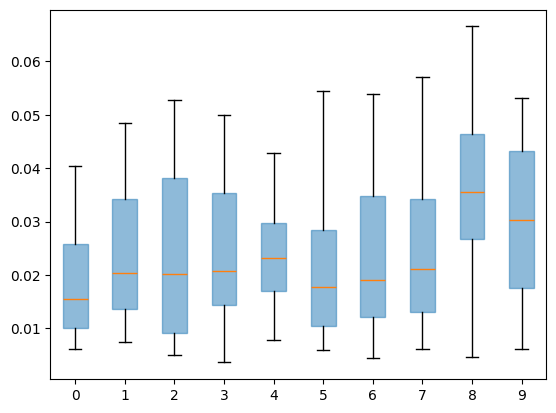

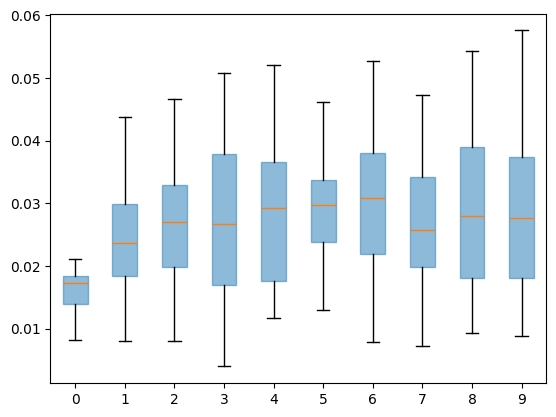

In [607]:
plt.boxplot(boxerror, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);
plt.show()
plt.boxplot(boxerror2, patch_artist=True,
            boxprops=dict(facecolor='C0', color='C0', alpha=0.5), labels=lbls, meanline=True, showfliers=fliers);
plt.show()


### rosenbrock

In [181]:
s = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset1.00-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(16)])
s2 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset0.50-prob1-ctraj1/samples_constrained-{i}.npy') for i in range(16)])
s3 = np.stack([np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts/offset1.00-prob1-ctraj1-test/samples_constrained-{i}.npy') for i in range(16)])


In [83]:
s.shape

(16, 20001, 2)

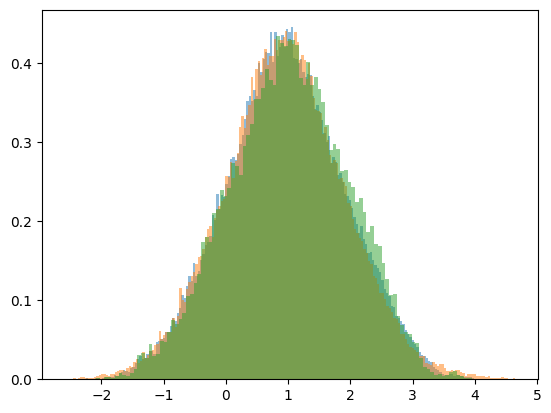

In [84]:
plt.hist(s[..., 0].flatten(), density=True, alpha=0.5, bins='auto')
plt.hist(s2[..., 0].flatten(), density=True, alpha=0.5, bins='auto');
plt.hist(s3[..., 0].flatten(), density=True, alpha=0.5, bins='auto');


# Check acceptances

In [723]:
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas/target0.65-offset1.00-prob1-ctraj1/'
s0 = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
a0 = np.stack([np.load(f'{folder}/accepts-{i}.npy')[:50000] for i in range(32)])
g0 = np.stack([np.load(f'{folder}/gradcounts-{i}.npy')[:50000] for i in range(32)])

print(s0[..., 0].mean(), s0[..., 0].std())
print(az.rhat(s0[..., 0]), az.rhat(s0[..., 1]))


0.1421572139497582 2.8636457810049207
1.0045211418807414 1.0028970262859436


In [451]:
stepsizes = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.80/stepsize.npy')
stepsizes2 = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.65/stepsize.npy')
test = np.load('/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.80-stepfac2.0/samples.npy')

In [452]:
stepsizes2/stepsizes

array([1.25451778, 1.37366377, 1.08696189, 1.30189744, 1.4710674 ,
       1.45621054, 1.27290501, 1.27663005, 0.81990516, 1.38068932,
       1.13883151, 1.27463095, 1.1268364 , 2.81878067, 1.3046836 ,
       1.7361552 , 2.28590074, 1.31113561, 1.37515296, 1.22768819,
       1.01581857, 1.51991781, 1.21776568, 1.66952494, 1.15324565,
       1.44952602, 1.26188159, 1.20061985, 1.1494812 , 2.34065301,
       3.03631968, 1.1383709 ])

In [734]:

folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-hmc/offset1.00//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts-indep/offset1.00-prob1-ctraj1/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-test/'
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-uninleap-test/'
# # folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj2-uninleap-test/'
# # folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-ctraj1-uninleap-test/'

# # folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-uninleap/'
# # folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas2-nuts/offset1.00-prob1-ctraj1-uninleap/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-uninleap-adapt200/'
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-nleap100-lognormal-stepsig1.2/'
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-bam//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-test/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit-test//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgscorrect-test//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit-test//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgscorrect-test//'
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/'
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgscorrect/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit-reg1/'
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgsinit/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgscorrect/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgsinit-reg1/'

# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/'
# # folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-stepfac1.5/'
# # folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/nodr_stepadapt-indep/target0.80-lognormal-stepsig1.2-test/'


# s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:10000] for i in range(32)])
# a = np.stack([np.load(f'{folder}/accepts-{i}.npy')[:10000] for i in range(32)])
# g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy')[:10000] for i in range(32)])
# t = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(32)]

print(folder)
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
a = np.stack([np.load(f'{folder}/accepts-{i}.npy')[:50000] for i in range(32)])
g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy')[:50000] for i in range(32)])
t = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(32)]
print(s.shape)

print(s[..., 0].mean(), s[..., 0].std())
# print(az.rhat(s[..., 0]), az.rhat(s[..., 1]))
print(list(zip(*np.unique(a, return_counts=True))))



/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam//
(32, 50000, 11)
0.1422896898492421 2.8648241379907278
[(-298, 10146), (-24, 68425), (-21, 81089), (-14, 16103), (-12, 9499), (-11, 119829), (-1, 319063), (1, 852938), (2, 37841), (3, 85067)]


In [721]:
g.sum()/g0.sum()


0.9965454828257481

In [614]:
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac1.5/'

s1 = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
a1 = np.stack([np.load(f'{folder}/accepts-{i}.npy')[:10000] for i in range(32)])
g1 = np.stack([np.load(f'{folder}/gradcounts-{i}.npy')[:10000] for i in range(32)])
t1 = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(32)]

folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac2.0/'
s2 = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
a2 = np.stack([np.load(f'{folder}/accepts-{i}.npy')[:10000] for i in range(32)])
g2 = np.stack([np.load(f'{folder}/gradcounts-{i}.npy')[:10000] for i in range(32)])
t2 = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(32)]


In [736]:
sfac=1.5
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/'

folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-stepfac{sfac}/'
folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgsinit/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgscorrect/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgsinit/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgscorrect/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgscorrect/'
# folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-stepfac{sfac}-bam/'

# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-lognormal-stepsig1.2-stepfac{sfac}/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj1-nleap100-lognormal-stepsig1.2-stepfac{sfac}-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-minnleap5-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-maxred2k-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-lownl25-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-nhess5-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-lownl25-highnl75-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-lownl25-highnl75-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-nladapt200-lownl25-highnl75-test/'
# # folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-nladapt200-lownl25-highnl75-test/'

s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
a = np.stack([np.load(f'{folder}/accepts-{i}.npy')[:10000] for i in range(32)])
g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy')[:10000] for i in range(32)])
t = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(32)]
tc = np.concatenate(t)

print(s[..., 0].mean(), s[..., 0].std())
print(az.rhat(s[..., 0]), az.rhat(s[..., 0]**2), az.rhat(s[..., 1]))
print(list(zip(*np.unique(a, return_counts=True))))

0.3742154141307143 2.7664088075585034
1.003874659658274 1.0025100273623444 1.0022603429067147
[(-298, 2720), (-24, 23882), (-21, 24508), (-14, 15762), (-12, 4350), (-11, 26941), (-1, 60641), (1, 120767), (2, 17328), (3, 23101)]


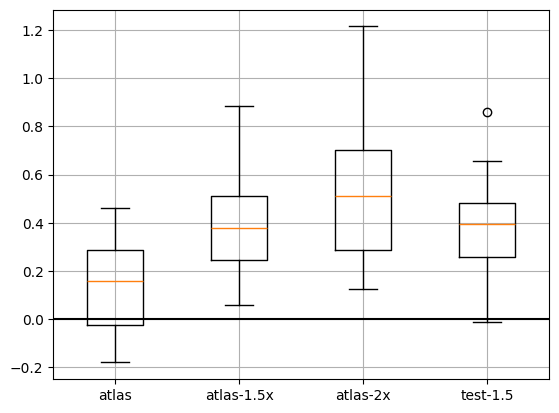

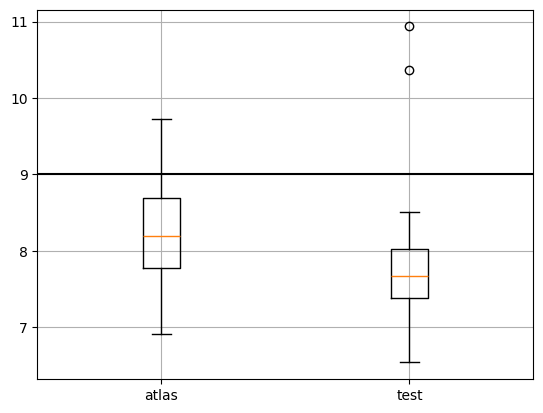

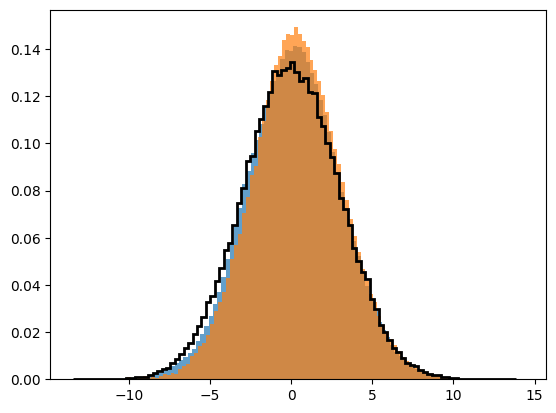

In [737]:
plt.boxplot([s0[..., 0].mean(axis=1), s1[..., 0].mean(axis=1), s2[..., 0].mean(axis=1), s[..., 0].mean(axis=1)], \
            labels=['atlas', 'atlas-1.5x', 'atlas-2x', f'test-{sfac}']);
plt.axhline(0, color='k')
plt.grid()
plt.show()
plt.boxplot([(s0[..., 0]**2).mean(axis=1), (s[..., 0]**2).mean(axis=1)], labels=['atlas', 'test']);
plt.axhline(9, color='k')
plt.grid()
plt.show()
plt.hist(ref_samples_funnel[..., 0], bins=100, density=True, histtype='step', lw=2, color='k')
plt.hist(s0[..., 0].flatten(), bins=100, density=True, alpha=0.7);
plt.hist(s[..., 0].flatten(), bins=100, density=True, alpha=0.7);


In [757]:
toplot = [s0[..., 0].mean(axis=1), s1[..., 0].mean(axis=1), s2[..., 0].mean(axis=1)]
toplot2 = [(s0[..., 0]**2).mean(axis=1), (s1[..., 0]**2).mean(axis=1), (s2[..., 0]**2).mean(axis=1)]
labels=['atlas', 'atlas-1.5x', 'atlas-2x']


sfac=1.5
unileap= True
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/'
if unileap: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam/'
else: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
toplot.append((s[..., 0]**1).mean(axis=1))
toplot2.append((s[..., 0]**2).mean(axis=1))
labels.append('bam')
if unileap: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgsinit/'
else: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgsinit/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
toplot.append((s[..., 0]**1).mean(axis=1))
toplot2.append((s[..., 0]**2).mean(axis=1))
labels.append('bam-init')
if unileap: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgscorrect/'
else: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-stepfac{sfac}-bam-bfgscorrect/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
toplot.append((s[..., 0]**1).mean(axis=1))
toplot2.append((s[..., 0]**2).mean(axis=1))
labels.append('bam-correct')


In [753]:
toplot = [s0[..., 0].mean(axis=1), s1[..., 0].mean(axis=1), s2[..., 0].mean(axis=1)]
toplot2 = [(s0[..., 0]**2).mean(axis=1), (s1[..., 0]**2).mean(axis=1), (s2[..., 0]**2).mean(axis=1)]
labels=['atlas', 'atlas-1.5x', 'atlas-2x']


sfac=1.5
unileap= True
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2/'
if unileap: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/'
else: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
toplot.append((s[..., 0]**1).mean(axis=1))
toplot2.append((s[..., 0]**2).mean(axis=1))
labels.append('bam')
if unileap: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit/'
else: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgsinit/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
toplot.append((s[..., 0]**1).mean(axis=1))
toplot2.append((s[..., 0]**2).mean(axis=1))
labels.append('bam-init')
if unileap: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgscorrect/'
else: folder = f'/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgscorrect/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy')[:50000] for i in range(32)])
toplot.append((s[..., 0]**1).mean(axis=1))
toplot2.append((s[..., 0]**2).mean(axis=1))
labels.append('bam-correct')


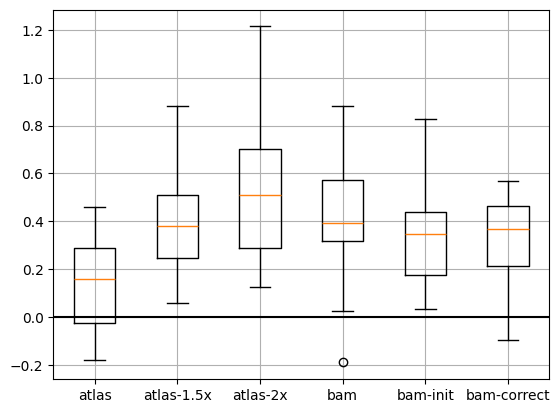

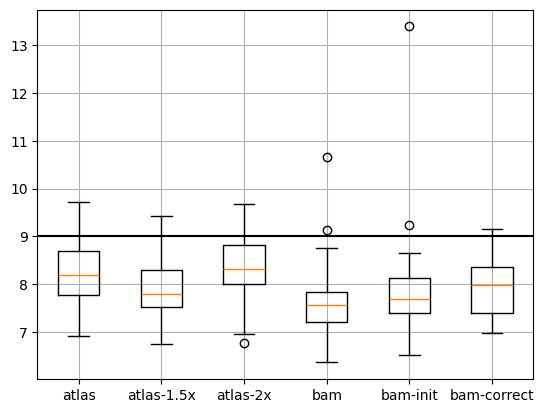

In [758]:
plt.boxplot(toplot, labels=labels);
plt.axhline(0, color='k')
plt.grid()
plt.show()
plt.boxplot(toplot2, labels=labels);
plt.axhline(9, color='k')
plt.grid()
plt.show()


In [750]:
nt = []
for i in range(32):
    nt.append(t[i]/stepsizes[i])
ntc = np.concatenate(nt)


(array([5., 4., 2., 5., 3., 6., 2., 3., 0., 2.]),
 array([ 77.9325 , 142.82625, 207.72   , 272.61375, 337.5075 , 402.40125,
        467.295  , 532.18875, 597.0825 , 661.97625, 726.87   ]),
 <BarContainer object of 10 artists>)

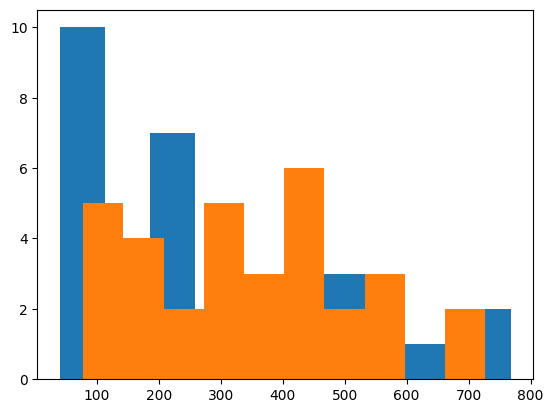

In [705]:
plt.hist(list(map(np.median, nt)))
plt.hist(list(map(np.mean, nt)))


In [706]:
print(np.median(ntc))

lnl = np.percentile(ntc, 25)
hnl = np.percentile(ntc, 75)
print(lnl, hnl)

199.49999999999997
62.25 567.9375


In [707]:
ntc.min()

2.2499999999999996

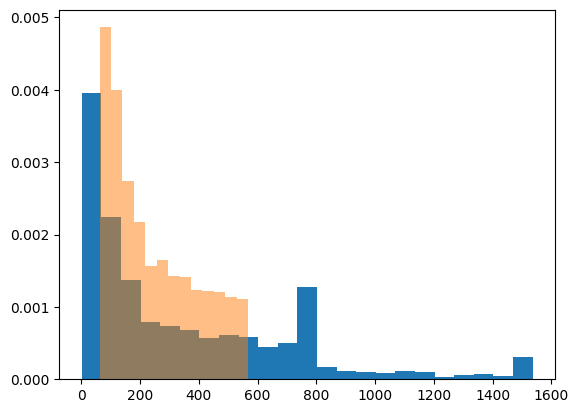

In [708]:
# plt.hist(np.concatenate(t)/stepsizes.mean(), bins=100);
lnl = np.percentile(ntc, 25)
hnl = np.percentile(ntc, 75)

plt.hist(ntc,  density=True, bins='auto');
plt.hist(ntc[(ntc > lnl) & (ntc< hnl)], bins='auto', density=True, alpha=0.5);


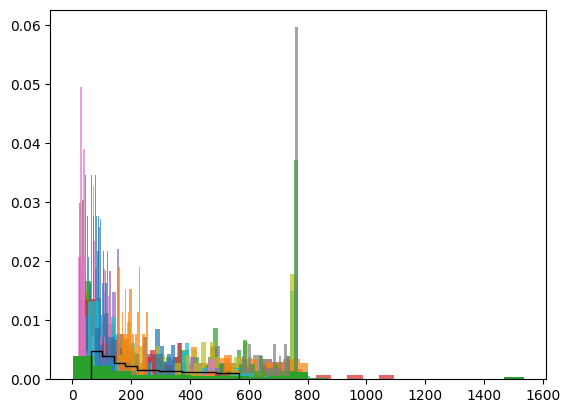

In [709]:
# plt.hist(np.concatenate(t)/stepsizes.mean(), bins=100);
i = 0 
for nts in nt:
    lnl = np.percentile(nts, 25)
    hnl = np.percentile(nts, 75)    
    # print(i, ((nts >= lnl) & (nts <= hnl)).sum(), lnl, hnl)
    plt.hist(nts[(nts >= lnl) & (nts <= hnl)], bins=20, density=True, alpha=0.7);
    i += 1
    
lnl = np.percentile(ntc, 25)
hnl = np.percentile(ntc, 75)

plt.hist(ntc,  density=True, bins='auto');
plt.hist(ntc[(ntc > lnl) & (ntc< hnl)], bins='auto', density=True, alpha=1.0, histtype='step', color='k');


In [710]:
u, v = np.unique(a, return_counts=True)
v = v/ a.size
print(list(zip(*[u, v])))

[(-298, 0.01584375), (-24, 0.0743625), (-21, 0.071871875), (-14, 0.04811875), (-12, 0.01356875), (-11, 0.080671875), (-1, 0.190478125), (1, 0.378103125), (2, 0.0532375), (3, 0.07374375)]


In [711]:
s[..., 0].mean(axis=1)

array([ 0.27349984,  0.46708839,  0.22532525,  0.32351511,  0.28068681,
        0.24061725,  0.2554798 ,  0.4698247 , -0.0480296 ,  0.44355005,
        0.56001311,  0.23105945,  0.51018935,  0.65306656,  0.4873559 ,
        0.26318866,  0.1663661 ,  0.35411531,  0.54391193,  0.76081009,
        0.48047912,  0.36266941,  0.52518491, -0.03596748,  0.23507046,
        0.46070591,  0.51855213,  0.36387268,  0.07385018,  0.13564124,
        0.54401907,  0.45349975])

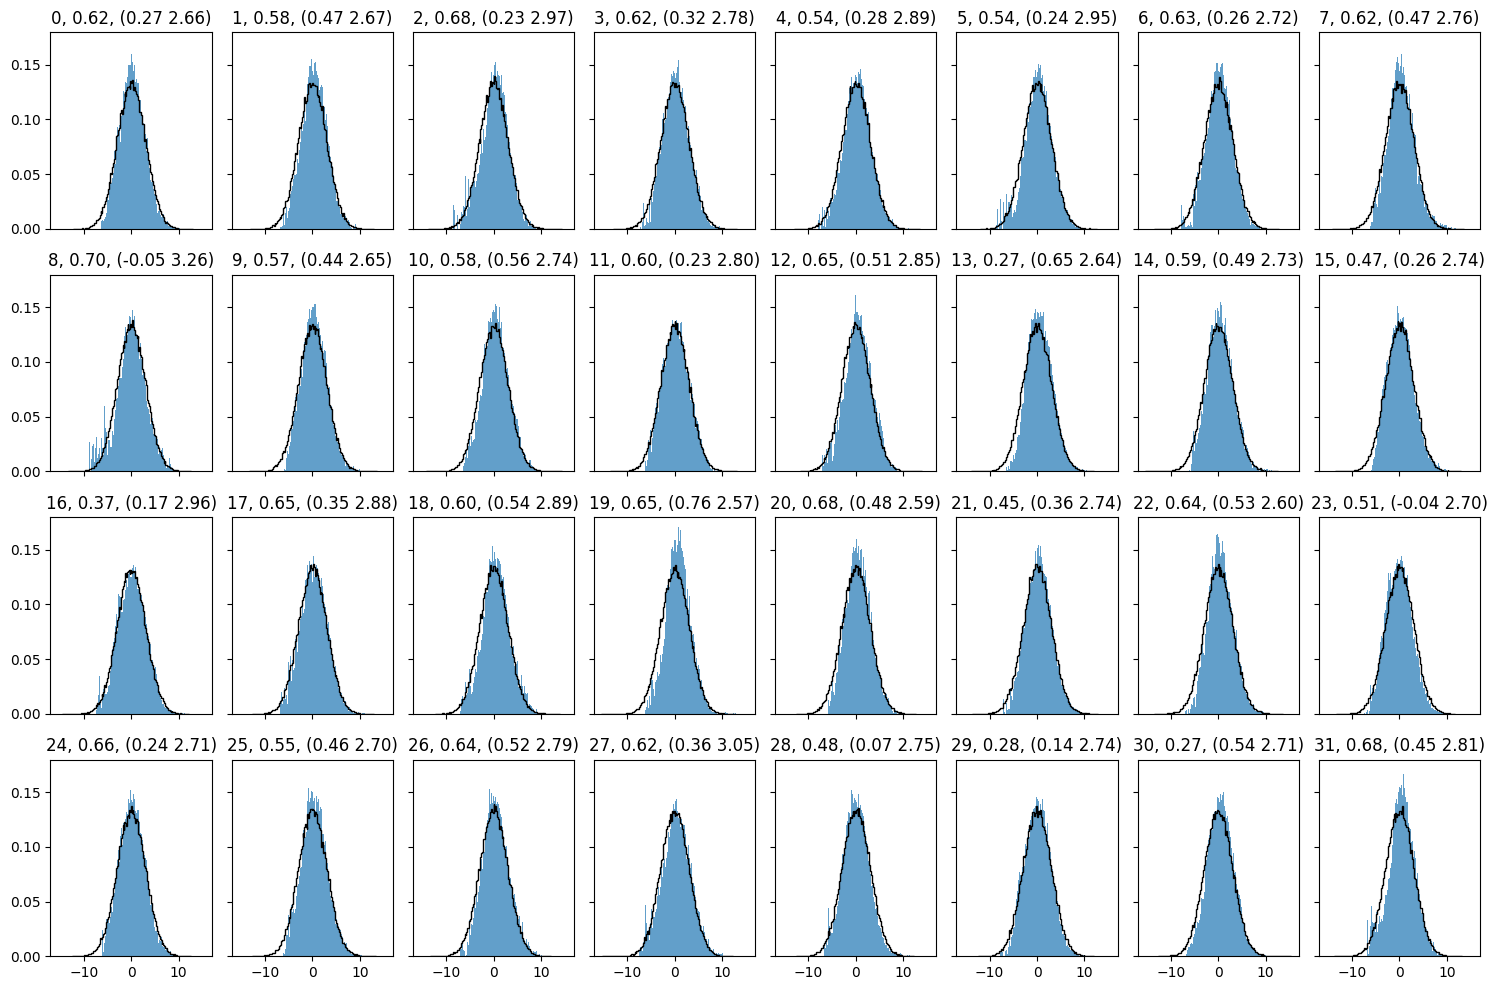

In [712]:
fig, ax = plt.subplots(4, 8, figsize=(15, 10), sharex=True, sharey=True)
for i in range(32):
    ax.flatten()[i].hist(s[i, :, 0], bins='auto', alpha=0.7, density=True)
    ax.flatten()[i].hist(np.random.normal(0, 3, 100000), bins='auto', density=True, histtype='step', color='k')
    ax.flatten()[i].set_title(f"{i}, {(stepsizes[i] * sfac):0.2f}, ({s[i, :, 0].mean():0.2f} {s[i, :, 0].std():0.2f})")
plt.tight_layout()
plt.show()

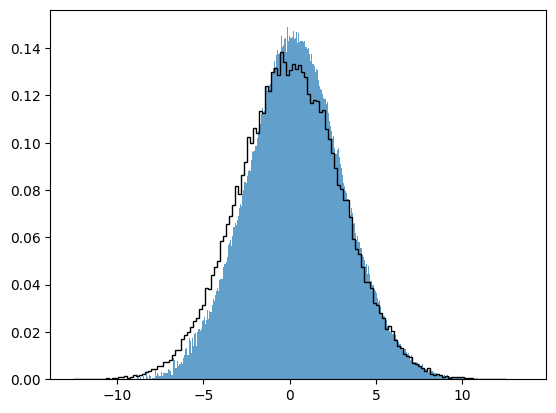

In [701]:
plt.hist(s[..., 0].flatten(), bins='auto', alpha=0.7, density=True)
plt.hist(np.random.normal(0, 3, 100000), bins='auto', density=True, histtype='step', color='k');

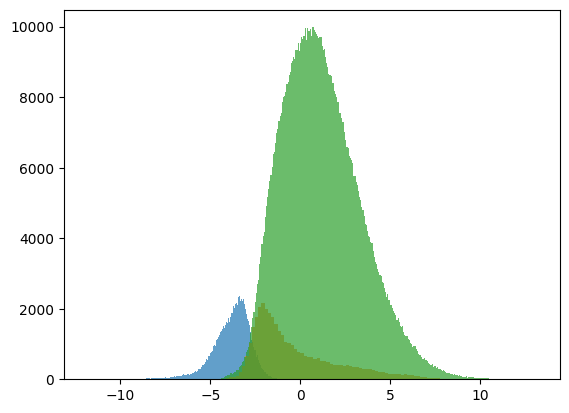

In [162]:
dens = False
plt.hist(s[np.where(a==3)][..., 0], alpha=0.7, density=dens, bins='auto')
plt.hist(s[np.where(a==2)][..., 0], alpha=0.7, density=dens, bins='auto')
plt.hist(s[np.where(a==1)][..., 0], alpha=0.7, density=dens, bins='auto');

/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


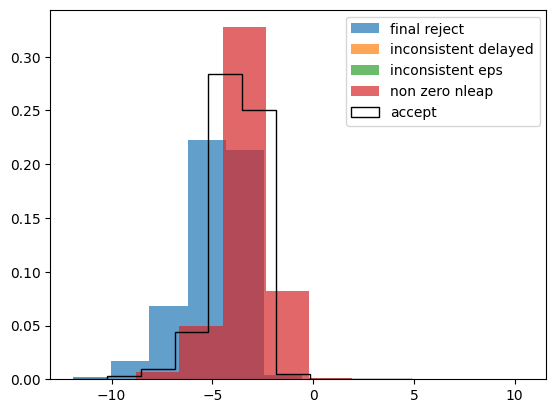

In [163]:
dens=True
plt.hist(s[np.where(a==-21)][..., 0], alpha=0.7, density=dens, label='final reject');
plt.hist(s[np.where(a==-22)][..., 0], alpha=0.7, density=dens, label='inconsistent delayed');
plt.hist(s[np.where(a==-23)][..., 0], alpha=0.7, density=dens, label='inconsistent eps');
plt.hist(s[np.where(a==-24)][..., 0], alpha=0.7, density=dens, label='non zero nleap');
plt.hist(s[np.where(a==3)][..., 0],  histtype='step', density=dens, label='accept', color='k', lw=1);
plt.legend()
# plt.hist(s[np.where(a==2)][..., 0], alpha=0.7)
# plt.hist(s[np.where(a==1)][..., 0], alpha=0.7);

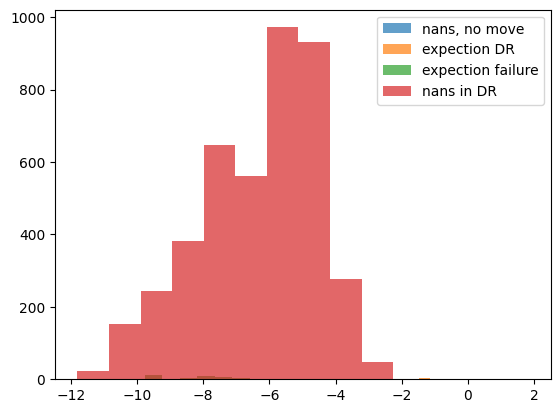

In [164]:
dens = False
plt.hist(s[np.where(a==-99)][..., 0], alpha=0.7, density=dens, label='nans, no move');
plt.hist(s[np.where(a==-199)][..., 0], alpha=0.7, density=dens, label='expection DR');
plt.hist(s[np.where(a==-299)][..., 0], alpha=0.7, density=dens, label='expection failure');
plt.hist(s[np.where(a==-298)][..., 0], alpha=0.7, density=dens, label='nans in DR');
plt.legend()

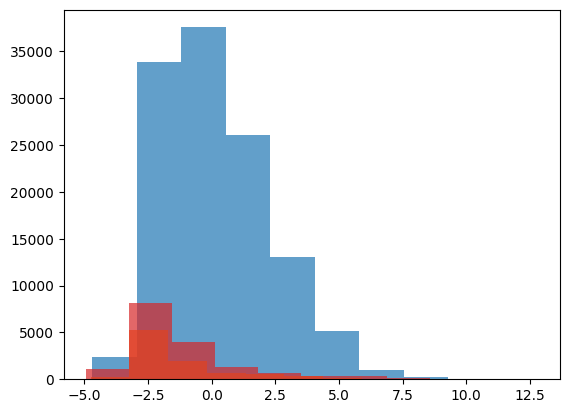

In [165]:
dens = False
plt.hist(s[np.where(a==-11)][..., 0], alpha=0.7, density=dens);
plt.hist(s[np.where(a==-12)][..., 0], alpha=0.7, density=dens);
plt.hist(s[np.where(a==-13)][..., 0], alpha=0.7, density=dens);
plt.hist(s[np.where(a==-14)][..., 0], alpha=0.7, density=dens);


(array([  656.,  3317.,  8391., 12522., 12972.,  7966.,  3256.,   800.,
          102.,    18.]),
 array([-8.29053652, -6.22639973, -4.16226294, -2.09812616, -0.03398937,
         2.03014742,  4.09428421,  6.158421  ,  8.22255779, 10.28669457,
        12.35083136]),
 <BarContainer object of 10 artists>)

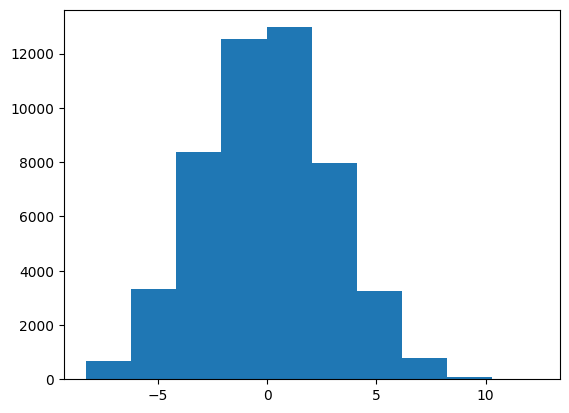

In [166]:
plt.hist(s[1, :, 0])

In [167]:
np.unique(a[1], return_counts=True)

(array([-298,  -24,  -21,  -14,  -12,  -11,   -1,    1,    2,    3]),
 array([  168,  2253,  3600,   471,   307,  3661,  9569, 25579,  1111,
         3281]))

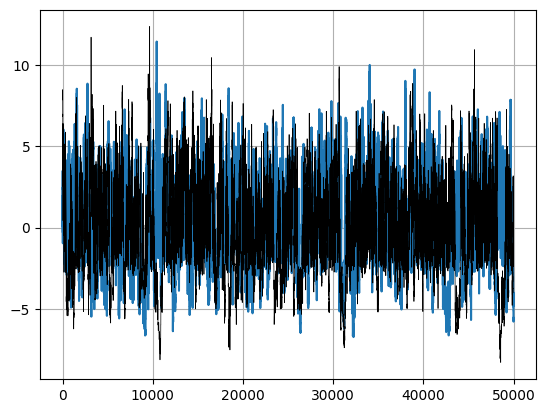

In [168]:
i = 6
plt.plot(s[i, :, 0])
plt.plot(s[1, :, 0], 'k', lw=0.5)
plt.grid()

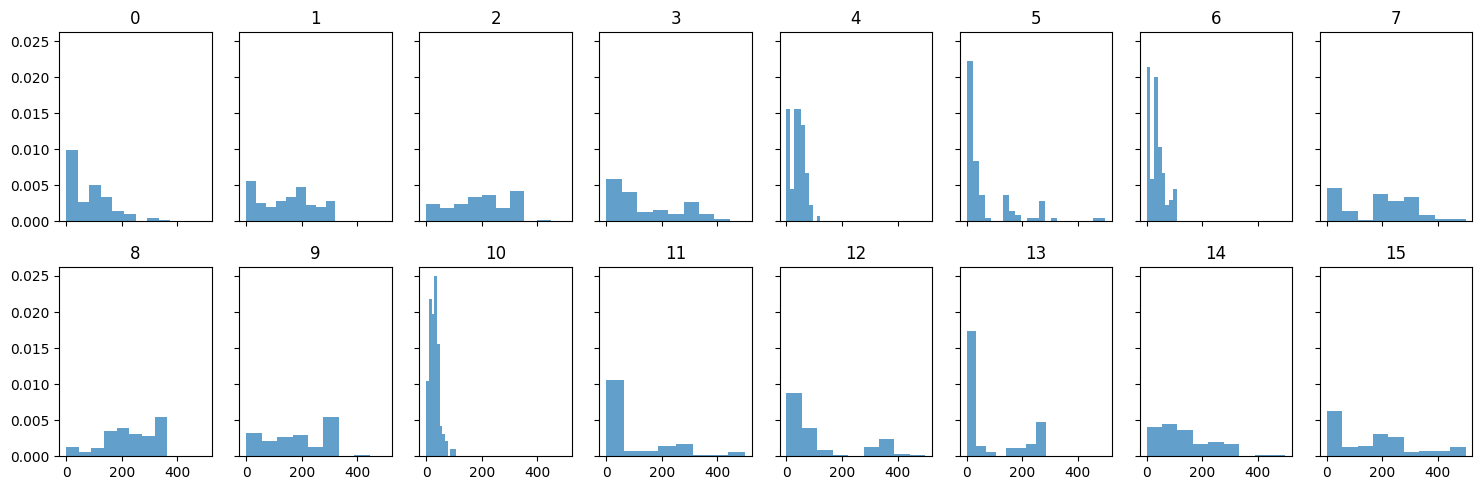

In [916]:
fig, ax = plt.subplots(2, 8, figsize=(15, 5), sharex=True, sharey=True)
for i in range(16):
    ax.flatten()[i].hist(t[i], bins='auto', alpha=0.7, density=True, range=(0, 500))
    ax.flatten()[i].set_title(i)
plt.tight_layout()
plt.show()

In [256]:
for i in range(16):
    print(i, t[i].min(), t[i].max())

0 1.780676 191.42266999999998
1 1.375515 151.581753
2 3.212768 253.067264
3 5.181096 442.120192
4 6.610032 111.131163
5 6.91429 372.64384
6 1.72458 98.732205
7 2.436264 415.789056
8 2.468352 315.949056
9 1.692355 346.594304
10 1.93063 113.90717000000001
11 3.5823869999999998 407.596032
12 2.14018 140.39580800000002
13 1.108482 378.361856
14 7.764597 467.702784
15 2.0846400000000003 426.934272


1458
2934


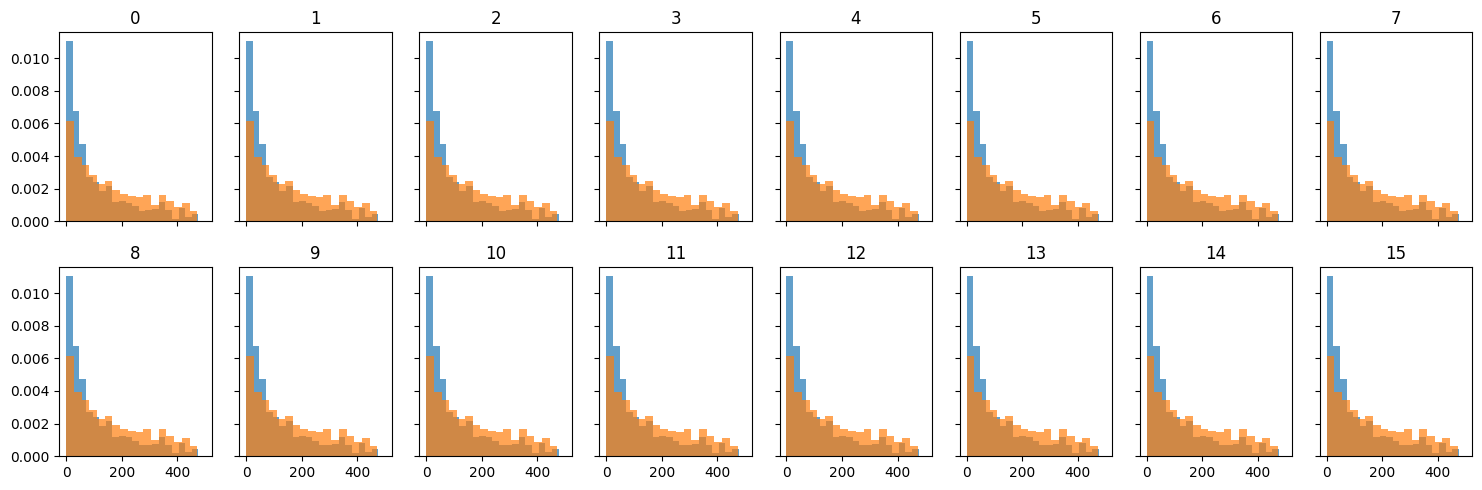

In [70]:
# fig, ax = plt.subplots(2, 8, figsize=(15, 5), sharex=True, sharey=True)

# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-uninleap//'

# s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(16)])
# a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
# g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(16)])
# t1 = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(16)]
# print(len(t1[-1]))

# for i in range(16):
#     ax.flatten()[i].hist(t1[i], bins='auto', alpha=0.7, density=True, range=(0, 500))
#     # ax.flatten()[i].hist(t[i], alpha=0.7, density=True)
#     ax.flatten()[i].set_title(i)

# folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlas-nuts/offset1.00-prob1-ctraj1-uninleap-adapt200//'

# s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(16)])
# a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
# g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(16)])
# t2 = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(16)]
# print(len(t2[-1]))


# for i in range(16):
#     ax.flatten()[i].hist(t2[i], bins='auto', alpha=0.7, density=True, range=(0, 500))
#     # ax.flatten()[i].hist(t[i], alpha=0.7, density=True) 
#     ax.flatten()[i].set_title(i)
# plt.tight_layout()
# plt.show()

In [74]:
np.stack(t1).min(), np.stack(t1).max(), np.stack(t2).min(), np.stack(t2).max()

(1.108482, 467.702784, 1.108482, 467.702784)

In [75]:
np.stack(t1).mean(), np.stack(t2).mean()

(112.74569376131689, 162.17032573517383)

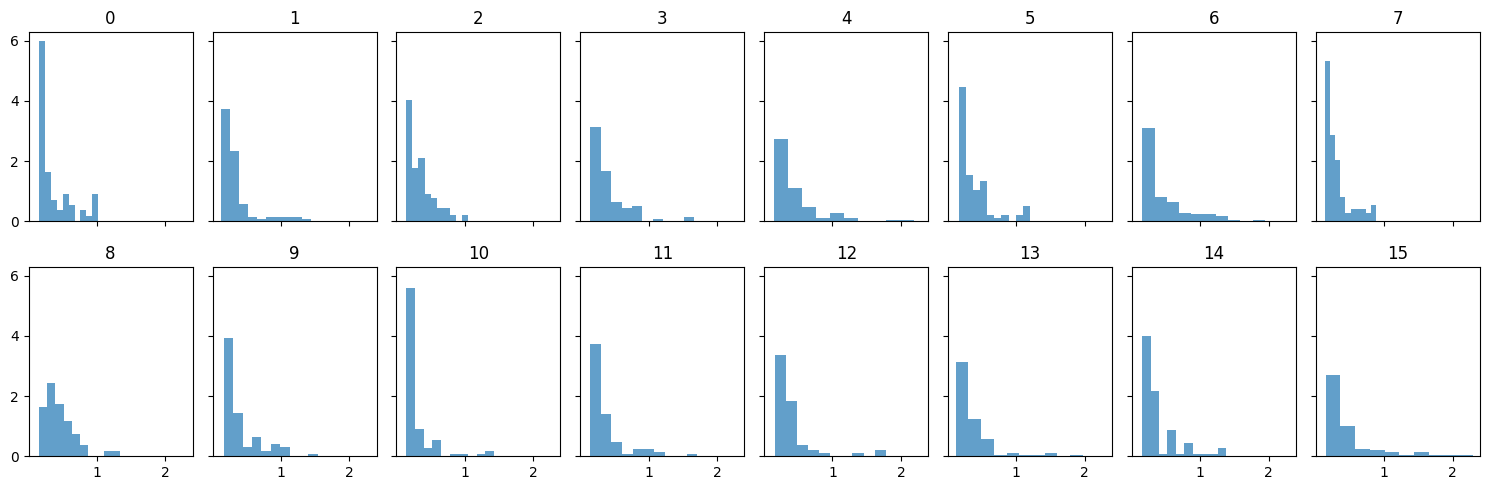

In [30]:
folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts-indep/offset1.00-prob1-ctraj1//'
folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts-indep/offset1.00-prob1-ctraj1-uninleap/'

s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(16)])
a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(16)])
t = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(16)]


fig, ax = plt.subplots(2, 8, figsize=(15, 5), sharex=True, sharey=True)
for i in range(16):
    # ax.flatten()[i].hist(t[i], bins='auto', alpha=0.7, density=True, range=(0, 500))
    ax.flatten()[i].hist(t[i], alpha=0.7, density=True)
    ax.flatten()[i].set_title(i)
plt.tight_layout()
plt.show()

In [36]:
np.array(results['Seniority']).sum()

100

## rosenbrock

(32, 50001, 2)
1.0252488344931143 0.9965002016709025
1.0046079495160547 1.0047658717074162
[(-298, 3), (-24, 150636), (-21, 40053), (-14, 35975), (-12, 16543), (-11, 51183), (-1, 450573), (1, 346552), (2, 18567), (3, 489947)]


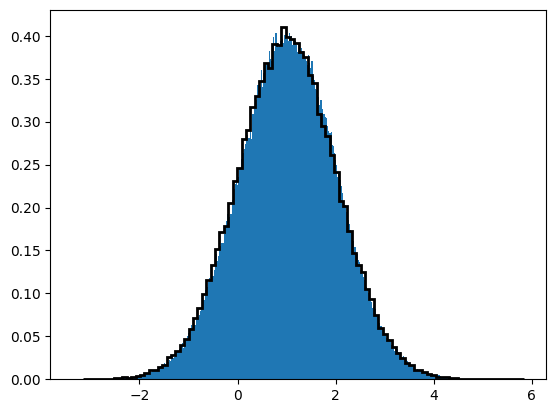

In [595]:
nleapdist = 'empirical'
if nleapdist == 'empirical' : ndist=''
else: ndist='-uninleap'

# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlas-nuts-indep/offset1.00-prob1-ctraj1-uninleap/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-test/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgscorrect-test//'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit-test//'
folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/'
folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgscorrect/'
folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam-bfgsinit-reg1/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgsinit/'
# folder = '/mnt/ceph/users/cmodi/atlassampler/rosenbrock-2/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-lognormal-stepsig1.2-bam-bfgscorrect/'

s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(32)])
a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(32)])
g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(32)])
t = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(32)]

print(s.shape)
print(s[..., 0].mean(), s[..., 0].std())
print(az.rhat(s[..., 0]), az.rhat(s[..., 1]))
print(list(zip(*np.unique(a, return_counts=True))))


plt.hist(ref_samples_rosenbrock[..., 0].flatten(), density=True, bins=100, histtype='step', color='k', lw=2);
plt.hist(s[..., 0].flatten(), density=True, bins='auto');


In [531]:
# exp = 'corr_normal95-100'
# # for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100", "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
# for exp in ["rosenbrock-2",  "funnel-11",  "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
#     print(exp)
#     try:
#         folder = f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlasv2-nuts/offset1.00-prob1-ctraj1/'
#         a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
#         print(list(zip(*np.unique(a, return_counts=True))))
#     except: PrintException()
#     try:
#         folder = f'/mnt/ceph/users/cmodi/atlassampler/{exp}/atlas-nuts/offset1.00-nodr-ctraj1/'
#         a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
#         print(list(zip(*np.unique(a, return_counts=True))))
#     except: PrintException()

rosenbrock-2
[(-24, 68321), (-23, 372), (-21, 16593), (-14, 33366), (-13, 1206), (-12, 7679), (-11, 9244), (-1, 227441), (1, 174008), (2, 9472), (3, 252314)]
[(-299, 92548), (-1, 146831), (1, 80637)]
funnel-11
[(-298, 315), (-24, 28724), (-23, 361), (-21, 14799), (-14, 23638), (-13, 335), (-12, 8665), (-11, 34245), (-1, 159424), (1, 429308), (2, 26054), (3, 74148)]
[(-299, 14039), (-1, 115716), (1, 190261)]
hmm
[(-24, 1115), (-21, 4), (-14, 1085), (-13, 1), (-12, 380), (-11, 462), (-1, 16961), (1, 11121), (2, 587), (3, 300)]
[(-299, 14595), (-1, 195807), (1, 109614)]
lotka_volterra
[(-24, 143), (-14, 1575), (-13, 2), (-12, 485), (-11, 782), (-1, 16013), (1, 12145), (2, 864), (3, 7)]
[(-299, 38985), (-1, 174369), (1, 106662)]
arK
[(-24, 216), (-14, 1463), (-13, 6), (-12, 543), (-11, 870), (-1, 15357), (1, 12622), (2, 921), (3, 18)]
[(-299, 2265), (-1, 193038), (1, 124713)]
irt_2pl
[(-24, 95), (-14, 397), (-12, 197), (-11, 2670), (-1, 4337), (1, 22376), (2, 1943), (3, 1)]
[(-299, 37), (-

0
1
2
3
3


In [527]:
exp = 'lotka_volterra'
print(exp)
folder = f'/mnt/ceph/users/cmodi/atlassampler/lotka_volterra//atlas-nuts/offset1.00-nodr-ctraj1/'
s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(32)])
g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(32)])
folder2 = f'/mnt/ceph/users/cmodi/atlassampler/lotka_volterra//nuts/target0.80/samples.npy'
s2 = np.load(f'{folder2}')


lotka_volterra


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/atlassampler/lotka_volterra//atlas-nuts/offset1.00-nodr-ctraj1//samples_constrained-16.npy'

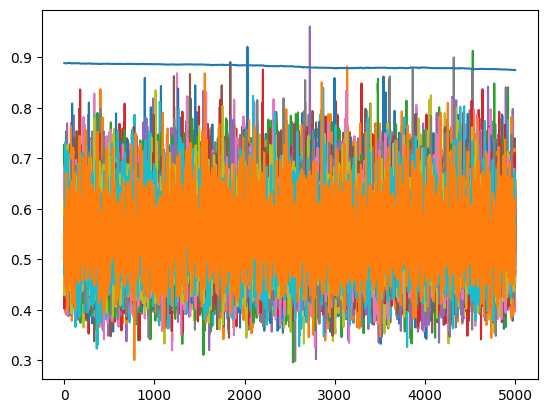

In [194]:
for i in range(32):
    plt.plot(s2[i, ..., 0])
# plt.plot(s2[-2, ..., 0])


In [199]:
np.where(s[:, :, 0].std(axis=1) < 0.05)

(array([30]),)

In [155]:
s2[:, :, 0].std(axis=1)

array([0.0656098 , 0.06470209, 0.06440549, 0.06075859, 0.0651172 ,
       0.06452571, 0.06413908, 0.06443772, 0.0646994 , 0.06312372,
       0.06210528, 0.06337247, 0.0644435 , 0.06379763, 0.06387255,
       0.06189496, 0.06283132, 0.06351709, 0.0656119 , 0.06219068,
       0.06409746, 0.06455297, 0.06499062, 0.06371764, 0.06300544,
       0.06319773, 0.06489181, 0.06507156, 0.06237467, 0.06424301,
       0.00386941, 0.06449041])

In [156]:
s[:, :, 0].std(),  s2[:, :, 0].std()

(0.08561785031163549, 0.08567340545107355)

In [586]:
folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/compare_stepadapt/target0.80/'

s = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(16)])
a = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
g = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(16)])
t = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(16)]

folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/compare_stepadapt/target0.80-beta//'

s2 = np.stack([np.load(f'{folder}/samples_constrained-{i}.npy') for i in range(16)])
a2 = np.stack([np.load(f'{folder}/accepts-{i}.npy') for i in range(16)])
g2 = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(16)])
t2 = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(16)]

folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/atlasv2-nuts/offset1.00-prob1-ctraj1//'

g3 = np.stack([np.load(f'{folder}/gradcounts-{i}.npy') for i in range(16)])
t3 = [np.load(f'{folder}/trajectories-{i}.npy') for i in range(16)]

folder = '/mnt/ceph/users/cmodi/atlassampler/funnel-11/nuts/target0.80/'

g4 = np.load(f'{folder}/leapfrogs.npy')[:16]



In [587]:
g.shape, g2.shape, g3.shape, g4.shape

((16, 50001), (16, 50001), (16, 50001), (16, 50001))

In [588]:
g.sum()/g4.sum(), g2.sum()/g4.sum(), g3.sum()/g4.sum()

(18.86560949243334, 16.31708643475663, 4.3433204457607655)

In [852]:
np.load('/mnt/ceph/users/cmodi/PosteriorDB/arK/samples.npy').shape

(16, 10000, 7)

In [862]:
np.load('/mnt/ceph/users/cmodi/PosteriorDB/glmm-poisson/samples.npy').shape

(16, 10000, 45)

In [878]:
for exp in ["rosenbrock-2",  "funnel-11",  "corr_normal95-100",   "ill_normal-100", "hmm", "lotka_volterra", "arK", "irt_2pl", "stochastic_volatility"]:
    f = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.80/stepsize.npy')
    f2 = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.65/stepsize.npy')
    try:
        f3 = np.load(f'/mnt/ceph/users/cmodi/atlassampler/{exp}/nuts/target0.5/stepsize.npy')
        print(exp, '\t', f.mean(), f2.mean(), f3.mean(), '\t', f2.mean()/f.mean(), '\t', f3.mean()/f.mean())
    except:
        print(exp, '\t', f.mean(), f2.mean(), '\t', f2.mean()/f.mean(), '\t')    

rosenbrock-2 	 0.073319653125 0.10722970625 	 1.4624960931987498 	
funnel-11 	 0.37504834375 0.50865509375 	 1.3562387415555677 	
corr_normal95-100 	 0.1054011875 0.13813659375 	 1.3105791028208293 	
ill_normal-100 	 0.145467125 0.16641693750000003 	 1.1440175056735329 	
hmm 	 0.024198818750000003 0.02773089375 	 1.1459606370248958 	
lotka_volterra 	 0.018656738368125 0.021291262499999998 	 1.1412103273301017 	
arK 	 0.013022521875 0.01534278125 	 1.1781728145494093 	
irt_2pl 	 0.045415740625 0.05313597528125 	 1.1699902842055656 	
stochastic_volatility 	 0.040714015625 0.048110656249999995 	 1.1816730801777795 	


# cov

In [114]:
s = np.load('/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/nuts/target0.80/samples.npy')
s1 = []
s2 = []
for i in range(32):
    s1.append(np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/atlasv2-nuts-indep/offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy'))
    # try: s2.append(np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/atlasv2-indep/target0.80-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy'))
    # try: s2.append(np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/atlasv2-indep/target0.80-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/samples_constrained-{i}.npy'))
    # try: s2.append(np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/atlasv2-indep/target0.85-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-bam/samples_constrained-{i}.npy'))
    # try: s2.append(np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/atlasv2-indep/target0.80-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2-long//samples_constrained-{i}.npy'))
    try: s2.append(np.load(f'/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/dr_stepadapt-indep/target0.80-uninleap-lognormal-stepsig1.2/samples_constrained-{i}.npy'))
    except: pass
s1 = np.array(s1)
s2 = np.array(s2)

In [115]:
# s2 = np.load('/mnt/ceph/users/cmodi/atlassampler/rosenbrockhy3-101/atlasv2-indep/target0.65-offset1.00-prob1-ctraj2-uninleap-lognormal-stepsig1.2/samples_constrained-1.npy')
s1.shape, s2.shape

((32, 50001, 101), (32, 50001, 101))

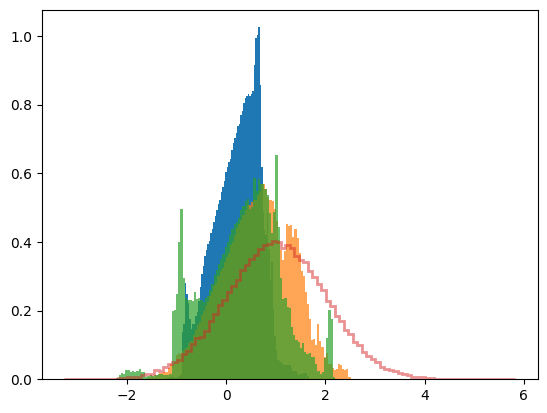

In [116]:
# plt.hist(s[..., :500].flatten(), bins=100, density=True)
plt.hist(s[..., 0].flatten(), bins=100, density=True)
plt.hist(s1[..., 0].flatten(), bins=100, density=True, alpha=0.7);
plt.hist(s2[..., 0].flatten(), bins=100, density=True, alpha=0.7);
plt.hist(np.random.normal(1, 1, 100000), bins=100, density=True, alpha=0.5, histtype='step', lw=2);

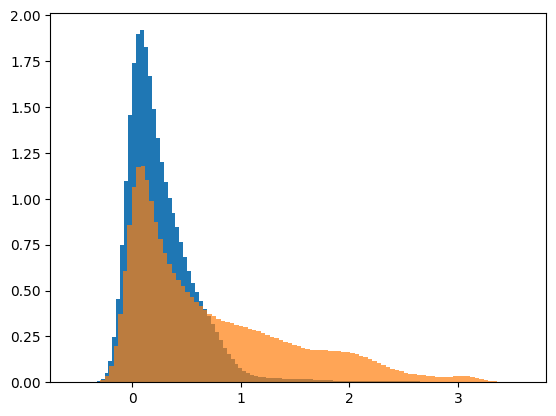

In [113]:
plt.hist(s[..., 1:50].flatten(), bins=100, density=True);
plt.hist(s2[..., 1:50].flatten(), bins=100, density=True, alpha=0.7);

# plt.hist(np.random.normal(1, 1, 100000), bins=100, density=True, alpha=0.5);

# GiST

In [15]:
sys.path.append('../experiments/')
import models

/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
sys.path.append('../experiments/')
import models

SAVEFOLDER = '/mnt/ceph/users/cmodi/atlassampler/'
REFERENCE_FOLDER = "/mnt/ceph/users/cmodi/PosteriorDB/"
BRIDGESTAN = "/mnt/home/cmodi/Research/Projects/bridgestan/"
MODELDIR = '../'
reference_path =  f'{REFERENCE_FOLDER}/'
from atlassampler import HMC_Uturn


In [125]:
model, D, lp, lp_g, ref_samples, files = models.stan_model('funnel', 2,
                                                           bridgestan_path=BRIDGESTAN,
                                                           model_directory=MODELDIR,
                                                           reference_samples_path=reference_path,
                                                           run_nuts=False)



..//stan/funnel.data.json
{'D': 2}
Exception in loading reference samples:  [Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/PosteriorDB///funnel-3//samples.npy'
Generate samples analytically


n_leapfrog argument is only used to adapt stepsize in U-turn sampler
Iteration 0 of 100
Iteration 10 of 100
Iteration 20 of 100
Iteration 30 of 100
Iteration 40 of 100
Iteration 50 of 100
Iteration 60 of 100
Iteration 70 of 100
Iteration 80 of 100
Iteration 90 of 100


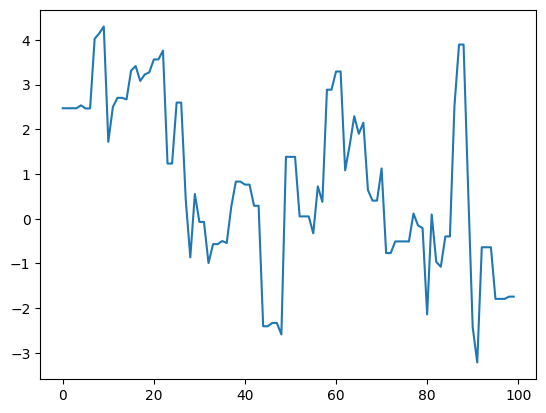

In [126]:
# Start run                                                                                                                                         
offset = 0.
step_size = 0.1
n_samples = 100 
np.random.seed(0)

q0 = np.random.normal(size=D)               
kernel = HMC_Uturn(D, lp, lp_g,
               mass_matrix = np.eye(D),
               offset = offset,
               min_nleapfrog = 3,
               max_nleapfrog = 1024)

sampler = kernel.sample(q0,
                        seed = 1,
                        step_size = step_size ,
                        n_samples = n_samples,
                        n_burnin = 0,
                        n_stepsize_adapt = 0)

plt.plot(sampler.samples[:, 0])                   

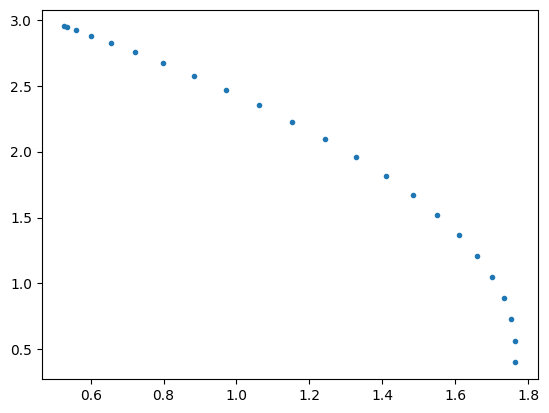

In [127]:
p0 = np.random.normal(size=D)
qs = np.array(kernel.nuts_criterion(q0, p0, step_size)[1])
plt.plot(qs[:, 0], qs[:, 1], '.')

In [161]:
for j in range(100):
    q0 = np.random.normal(size=D)
    p0 = np.random.normal(size=D)
    Nuturn, qs, ps, gs, success = kernel.nuts_criterion(q0, p0, step_size)
    nleapfrog, lp1 = kernel.nleapfrog_sample_and_lp(Nuturn, offset=offset)
    q1, p1, qlist, glist = qs[nleapfrog], ps[nleapfrog], qs, gs

    # Go backward                                                                                                                           
    Nuturn_rev, qs2 = kernel.nuts_criterion(q1, -p1, step_size)[:2]
    nleapfrog2, lp2 = kernel.nleapfrog_sample_and_lp(Nuturn_rev, offset=offset, nleapfrog=nleapfrog)
    if lp2 == -np.inf:
        print(lp1, lp2)
        print(Nuturn, Nuturn_rev, nleapfrog)
        qs = np.array(qs)
        qs2 = np.array(qs2)
        break

-3.9702919135521215 -inf
54 41 45


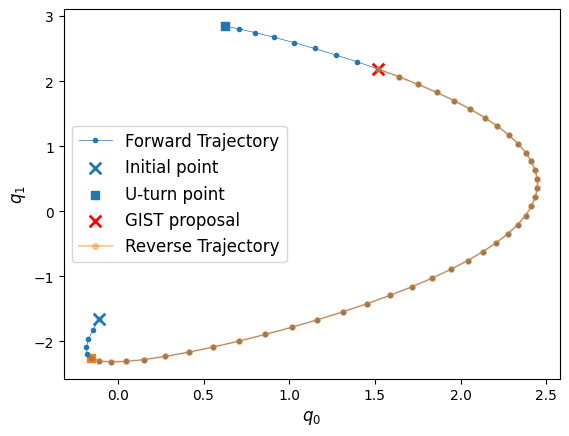

In [183]:

plt.plot(np.array(qs)[:, 0], np.array(qs)[:, 1], 'C0', marker='.', label='Forward Trajectory', lw=0.5)
plt.scatter(np.array(qs)[0, 0], np.array(qs)[0, 1], color='C0', marker='x', s=70, linewidth=2,  label='Initial point')
plt.scatter(np.array(qs)[-1, 0], np.array(qs)[-1, 1], color='C0', marker='s', s=40, label='U-turn point')
plt.scatter(np.array(qs)[nleapfrog, 0], np.array(qs)[nleapfrog, 1], color='r', marker='x', s=70, linewidth=2, label='GIST proposal')

plt.plot(np.array(qs2)[:, 0], np.array(qs2)[:, 1], 'C1', marker ='.', alpha=0.4, ms=8, label='Reverse Trajectory')
# plt.plot(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], 'C1s', ms=6)
plt.scatter(np.array(qs2)[-1, 0], np.array(qs2)[-1, 1], color='C1', marker='s', s=40)
plt.xlabel(r'$q_0$', fontsize=12)
plt.ylabel(r'$q_1$', fontsize=12)
plt.legend(fontsize=12)
# plt.savefig('./figs/gist_subuturn_traj.png')
# plt.savefig('./figs/gist_subuturn_traj.pdf')


In [130]:
# def gist_nuts_criterion(self, q, p, step_size):
#         """Run a leaprfrog trajectory until U-turn, divergence or max_leapfrog_steps"""
#         qs, ps, gs = [], [], []
#         log_joint_qp = self.H(q, p)
#         q_next = q
#         p_next = p
#         g_next =  self.V_g(q)
#         old_distance = 0
#         success = True

#         for n in range(self.max_nleapfrog):
#             qs.append(q_next)
#             ps.append(p_next)
#             gs.append(g_next)
#             q_next, p_next, qlist, glist = self.leapfrog(q_next, p_next, 1, step_size, g=g_next)
#             g_next = glist[-1]
#             log_joint_next = self.H(q_next, p_next)
#             if np.abs(log_joint_qp - log_joint_next) > 10:
#                 success = False
#                 break
#             distance = np.sum((q_next - q) ** 2)
#             if distance <= old_distance:
#                 break
#             old_distance = distance

#         return n+1, qs, ps, gs, success

